# Sales Forecasting Improved Version

In [22]:
# Loading Importent Files
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation


In [2]:
#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [3]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### READING IN DATA
Sales dataset from kaggle from Favorita stores in Ecuador. (ref: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [9]:
df = pd.read_csv('train.csv')

df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'])

In [10]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [11]:
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL. select date, family, sum(sales) from df group by date, family

In [12]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [13]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [14]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.drop('LIQUOR,WINE,BEER',axis='columns',inplace=True)
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  MAGAZINES    MEATS  PERSONAL CARE  \
date                                                                       
2013-01-01             2.00      5.00       0.00   110.80          25.00   
2013-01-02           121.00    469.00       0.00 20871.46       17204.00   
2013-01-03            83.00    366.00       0.00 16597.40       12568.00   
2013-01-04           127.00    382.00       0.00 21625.96       11303.00   
2013-01-05           180.00    458.00       0.00 20879.09       16819.00   

family      PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  PREPARED FOODS  \
date                                                                         
2013-01-01          0.00                     0.00    42.64           37.85   
2013-01-02          0.00                     0.00 13975.88         5338.11   
2013-01-03          0.00                     0.00 10674.39         3591.39   
2013-01-04          0.00                     0.00 10772.52         4472.97   
2013-01-05          0.00                     0.00 13475.01         5830.07   

family      PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                      
2013-01-01     0.00                        0.00     0.00  
2013-01-02     0.00                        0.00  1526.75  
2013-01-03     0.00                        0.00  1094.31  
2013-01-04     0.00                        0.00  1293.12  
2013-01-05     0.00                        0.00  1245.64

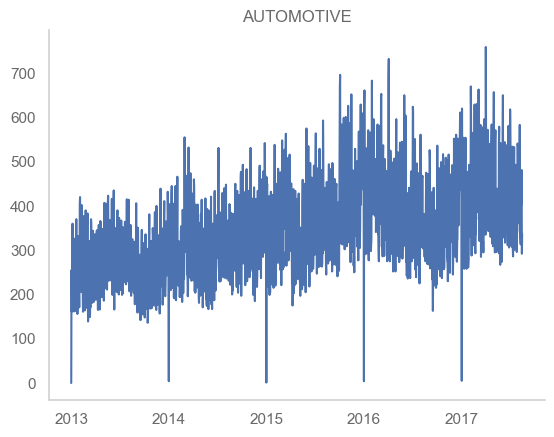

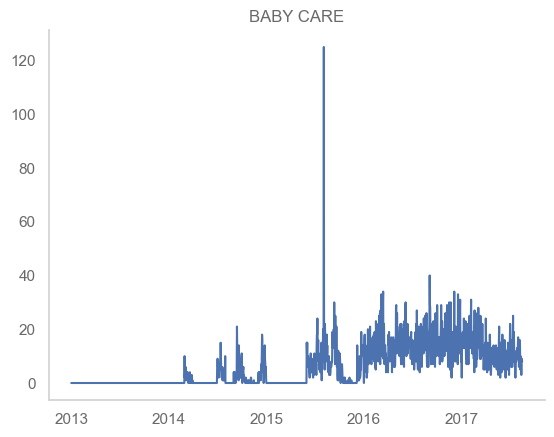

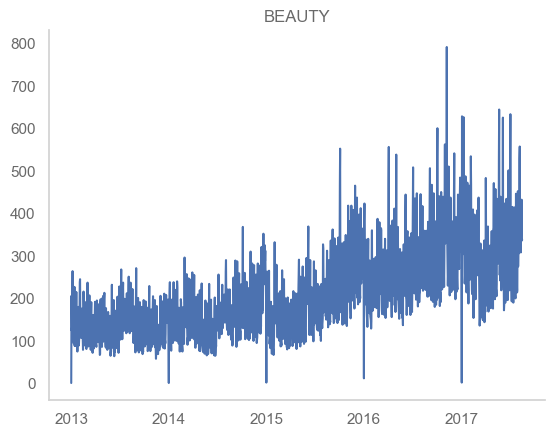

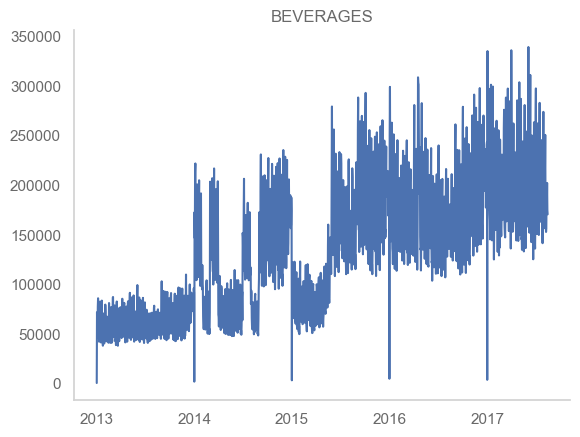

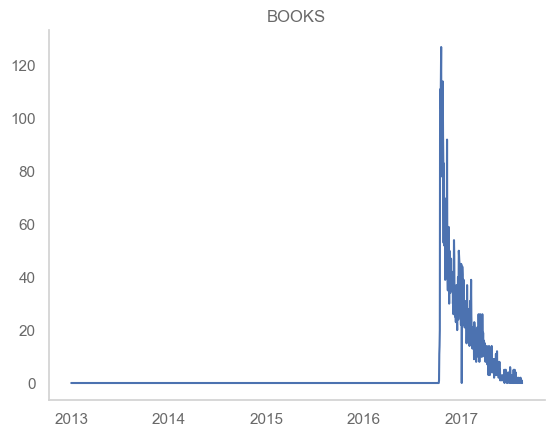

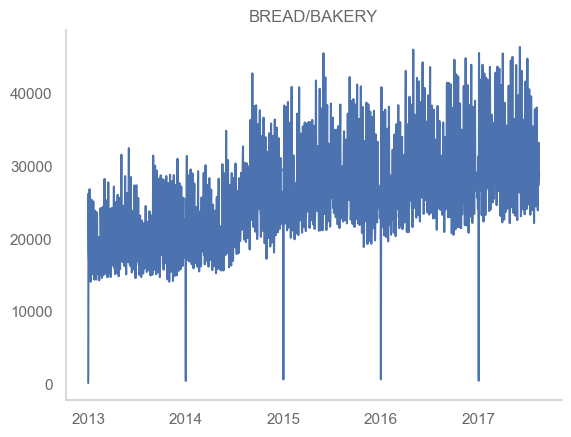

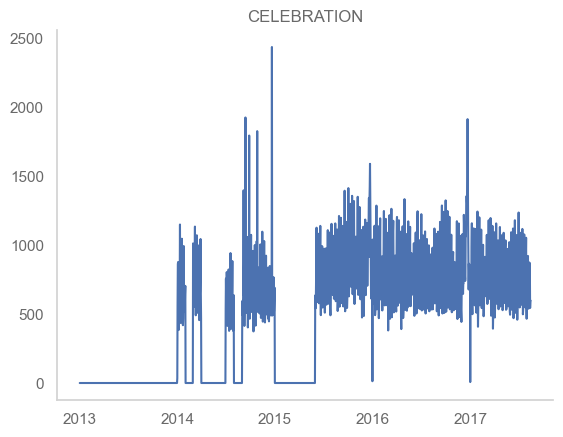

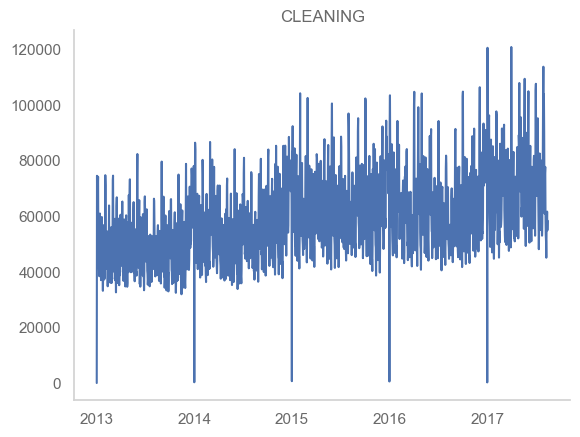

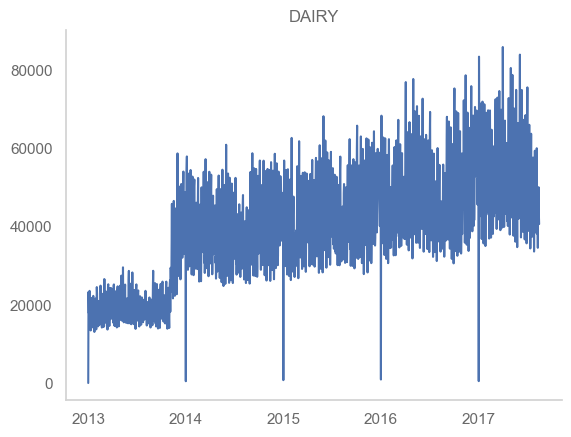

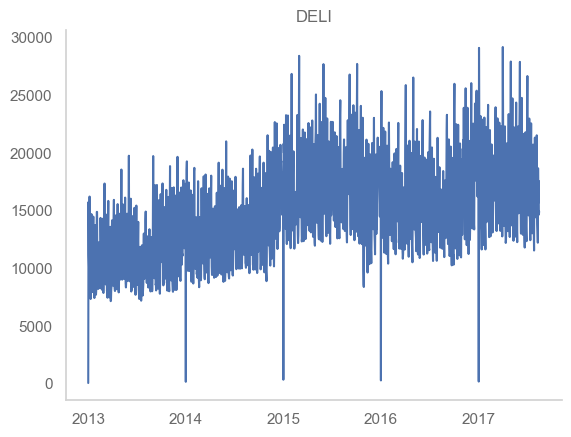

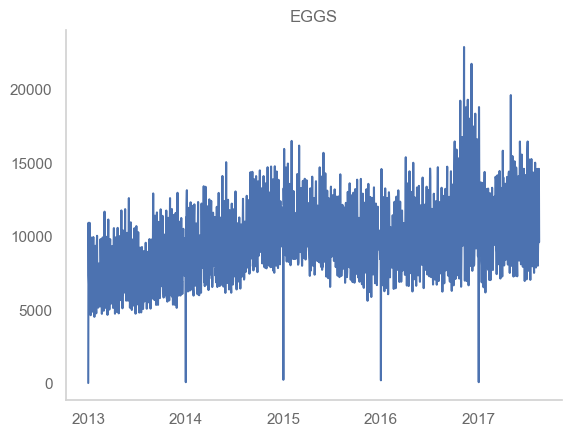

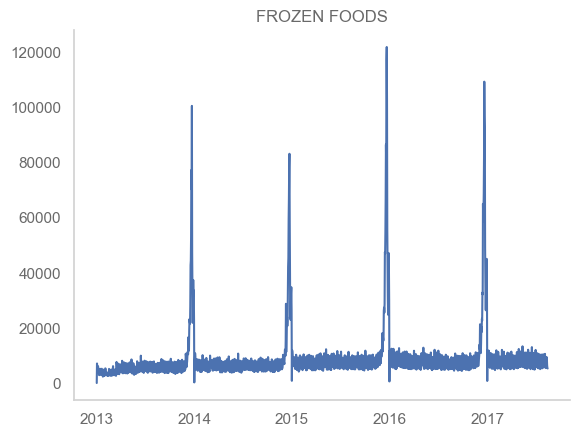

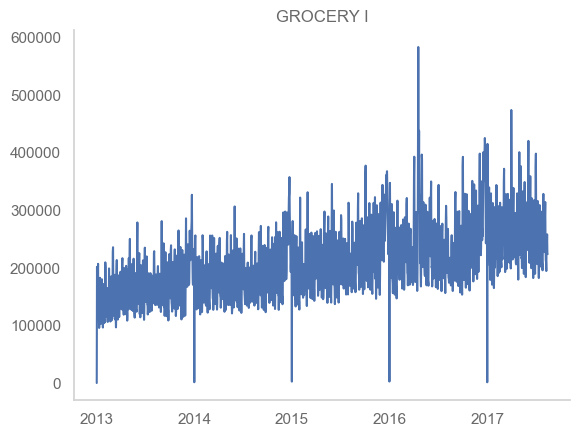

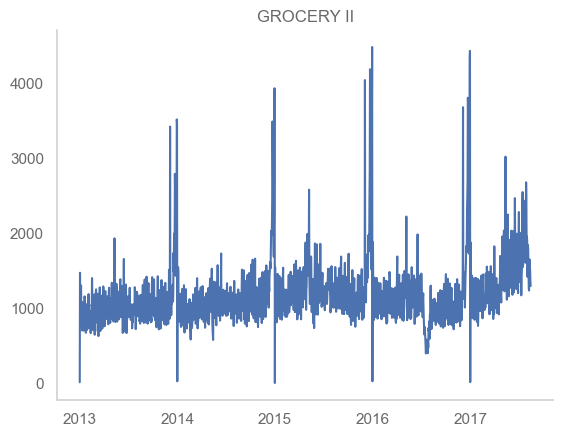

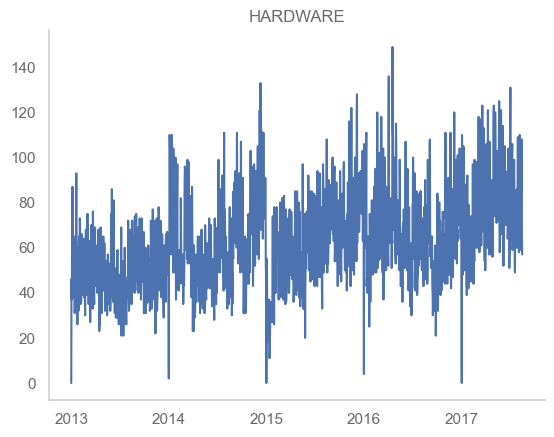

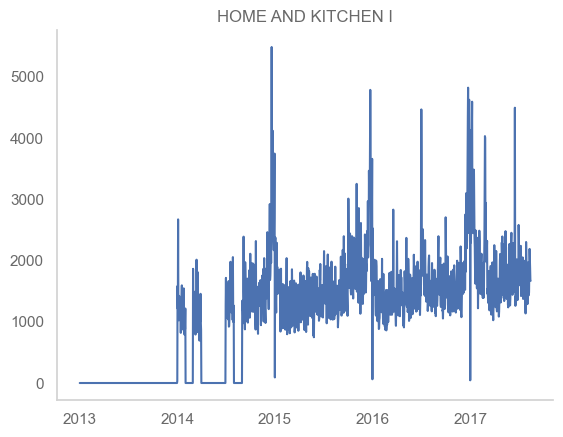

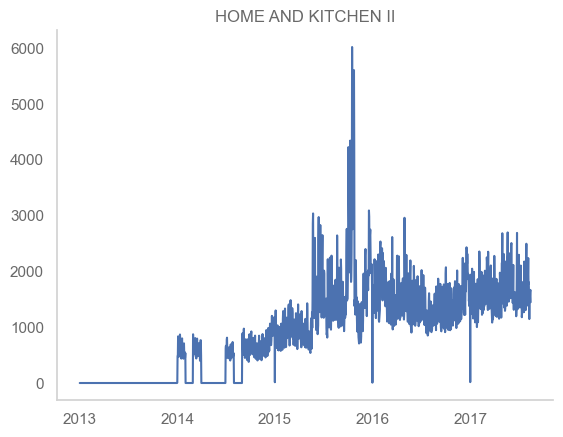

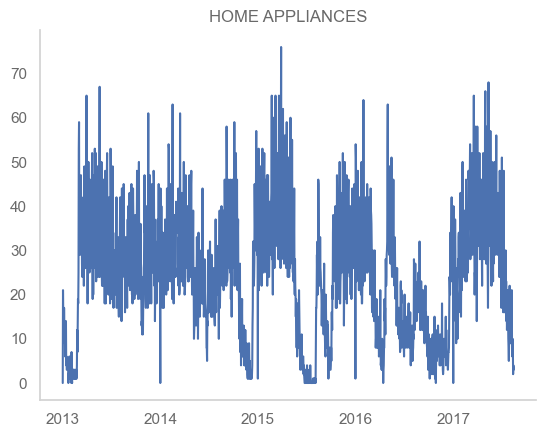

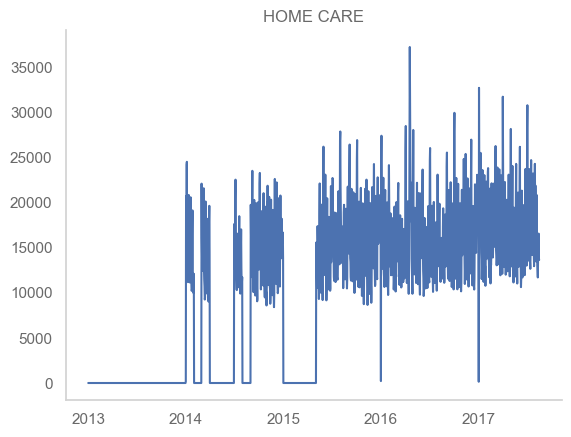

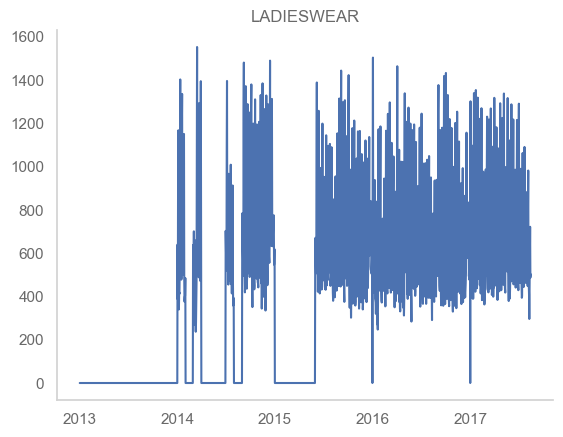

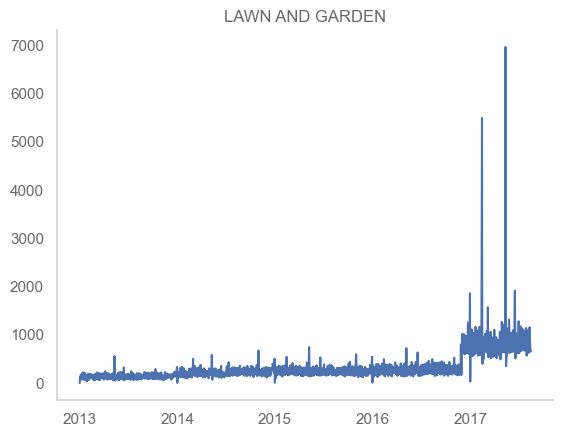

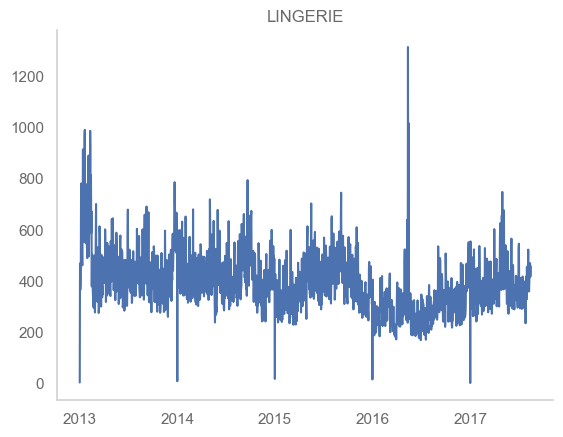

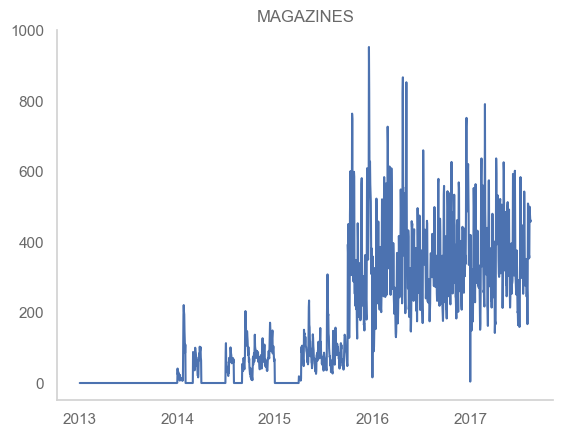

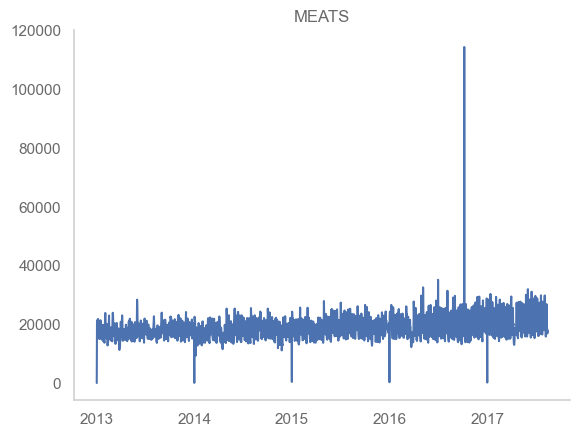

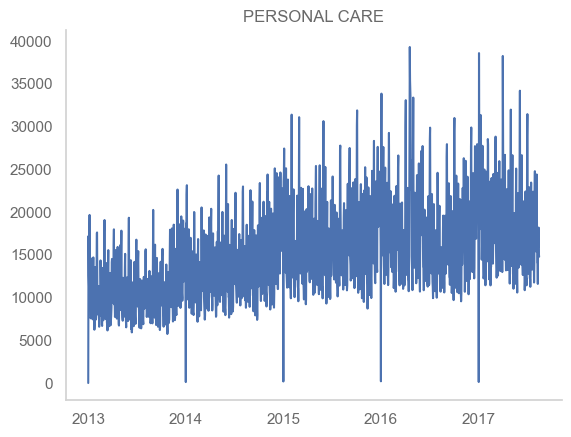

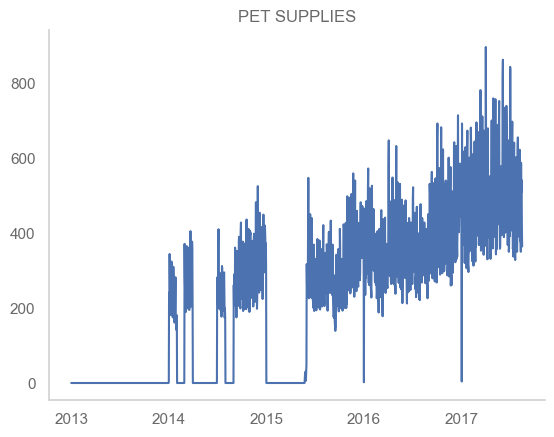

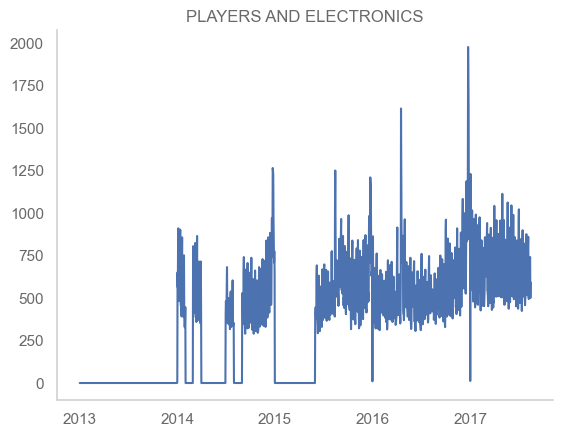

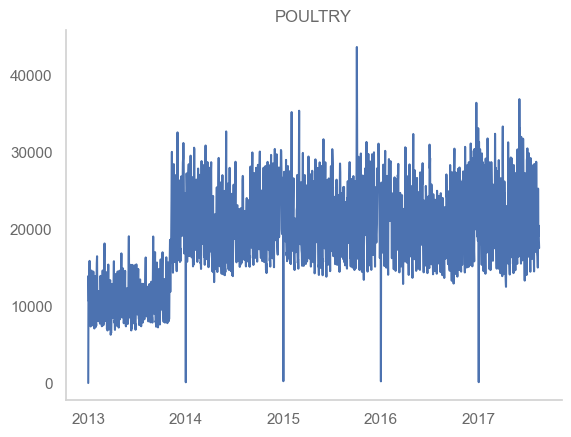

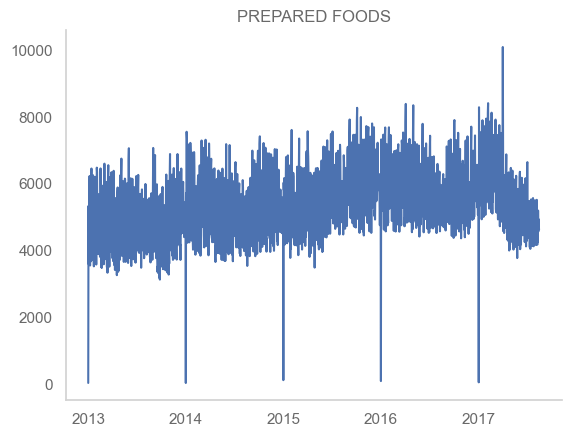

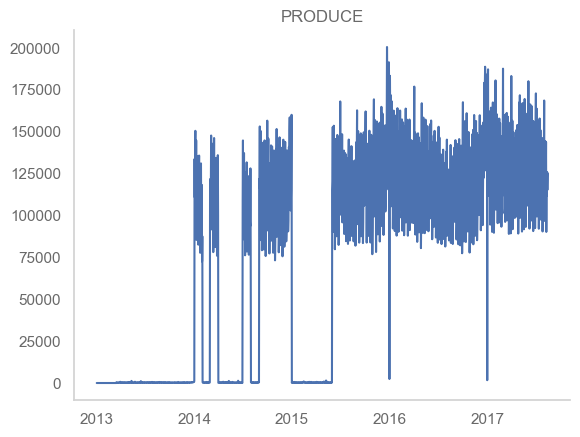

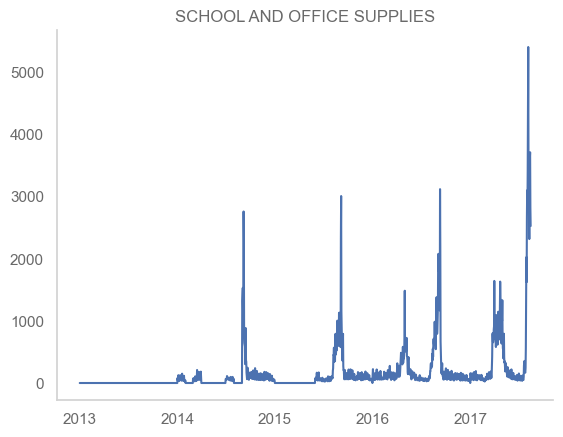

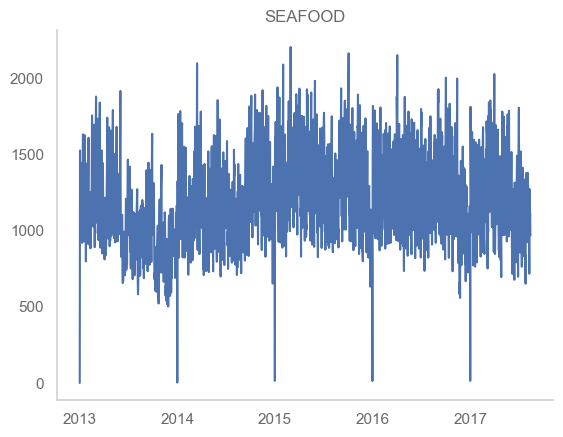

In [15]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [16]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [17]:
missing_data(total_sales_df).head()

Total  Percent    Types
family                             
AUTOMOTIVE      0     0.00  float64
BABY CARE       0     0.00  float64
BEAUTY          0     0.00  float64
BEVERAGES       0     0.00  float64
BOOKS           0     0.00  float64

## Data Cleaning Requirements

1. **Remove low-volume data that can't be predicted.**

2. **Remove situations where there's not enough data**:
   - Perform visual inspection.
   - Check for the number of '0' daily sales counts.

3. **Remove outliers**:
   - Calculate the z-score.
   - Automatically remove outliers.
   - Use Prophet to impute the removed values.
   - Ensure outliers near '0' for all categories are removed.

4. **Check if more data needs to be removed after filtering**:
   - Filtering period: 08/15/15 - 08/15/17.
   - If additional data removal is not required, proceed through the pipeline.


In [18]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 14 columns due to insufficient data volume.


In [19]:

#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

After checking for 0s and not seeing any issues, we can keep all the categories that we have left in the dataframe.

In [20]:
print(total_sales_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


In [23]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


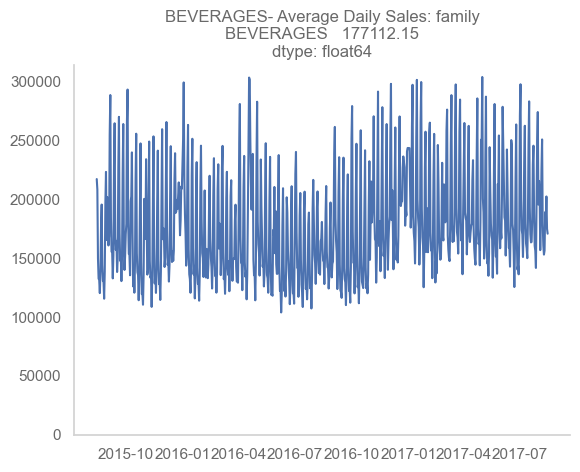

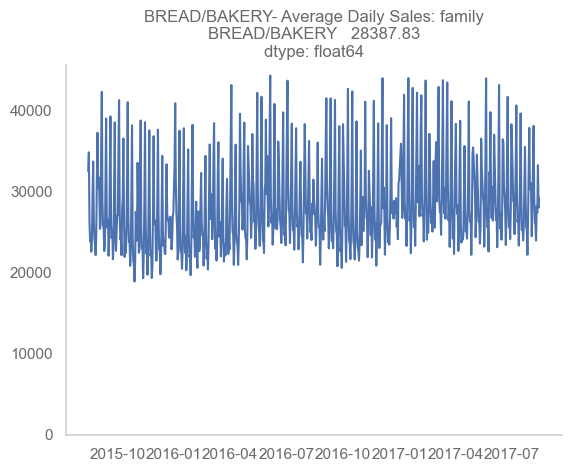

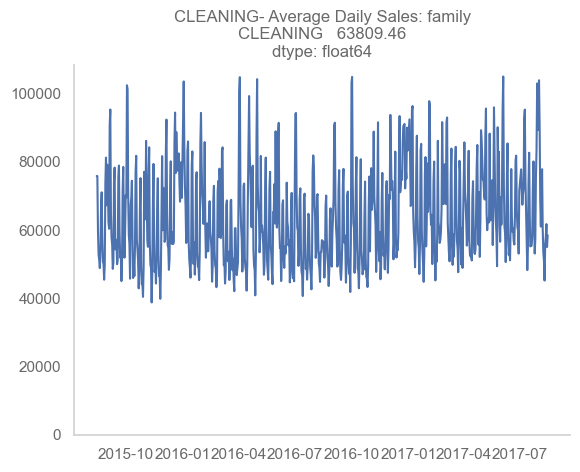

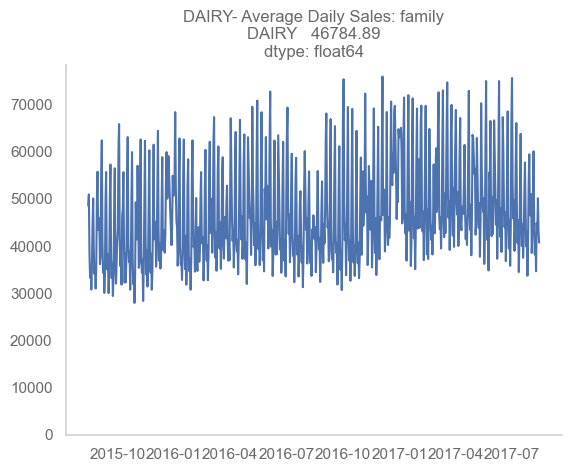

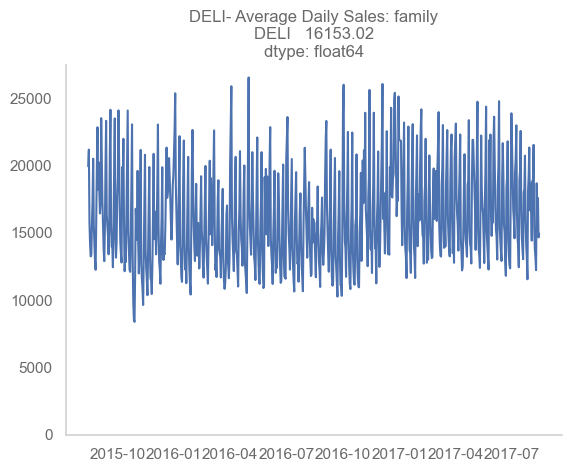

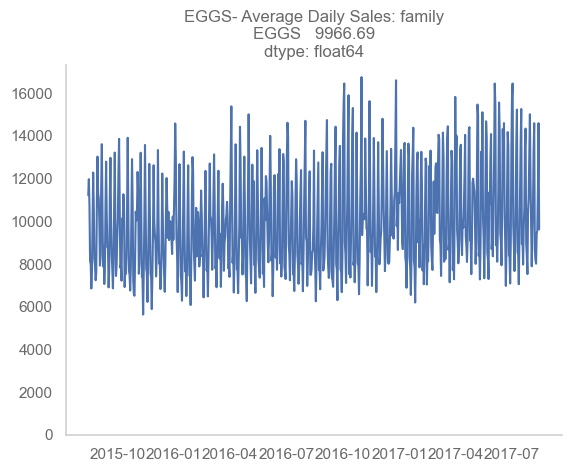

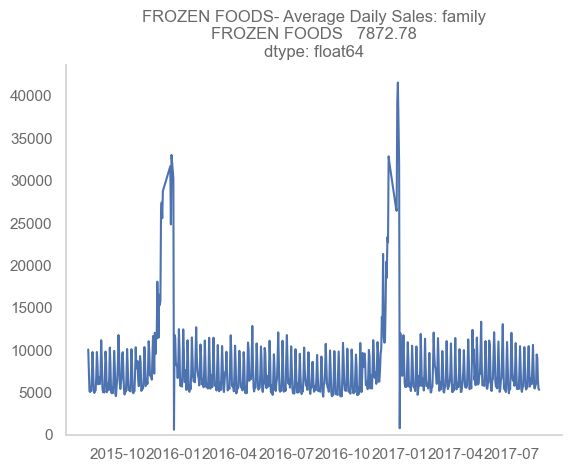

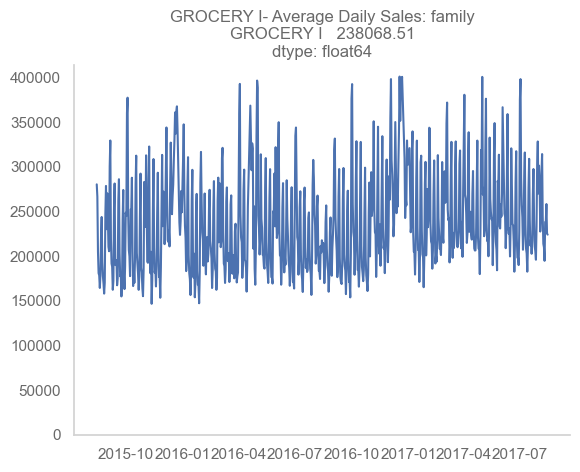

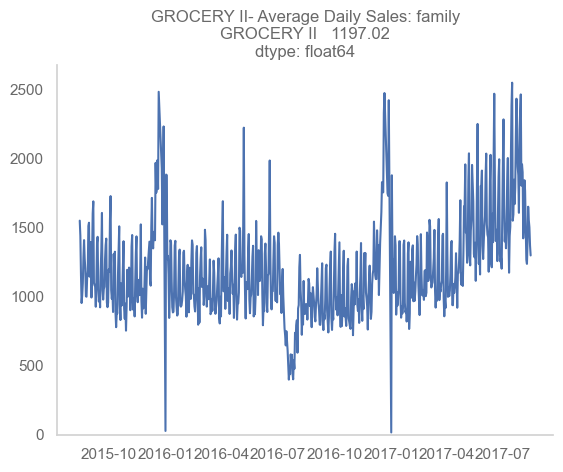

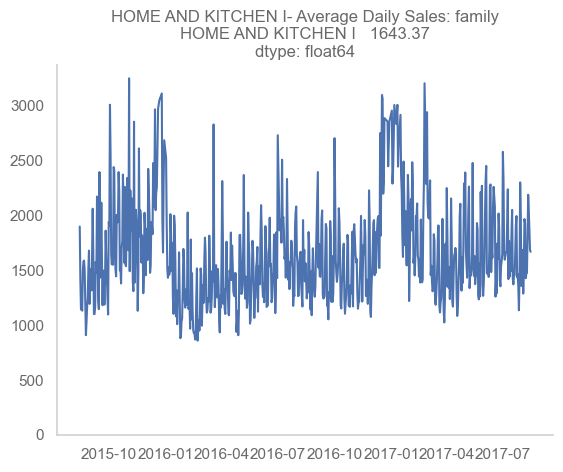

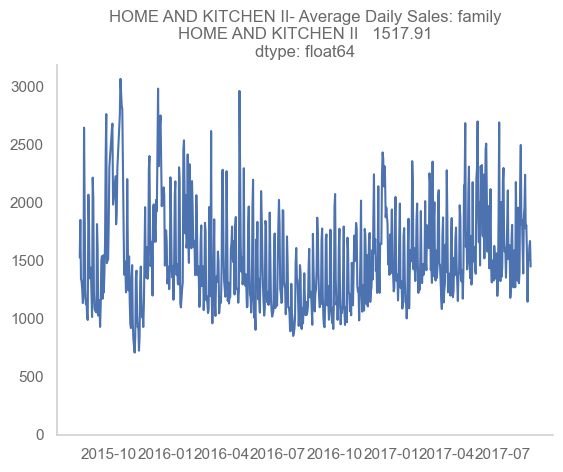

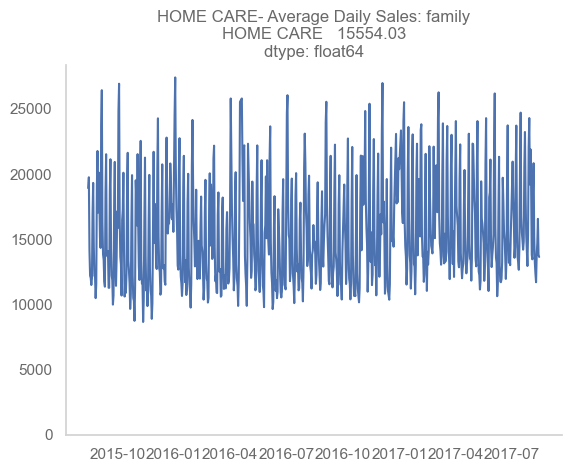

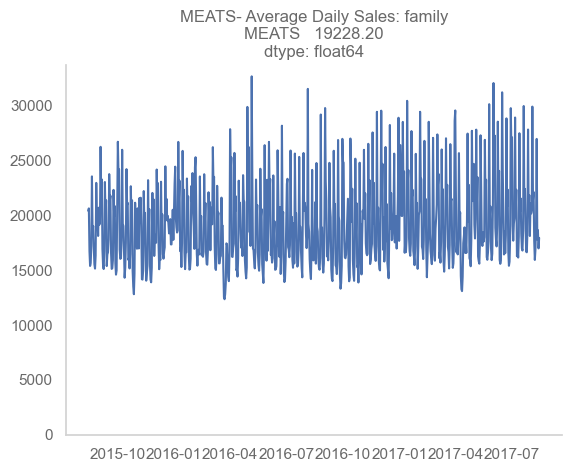

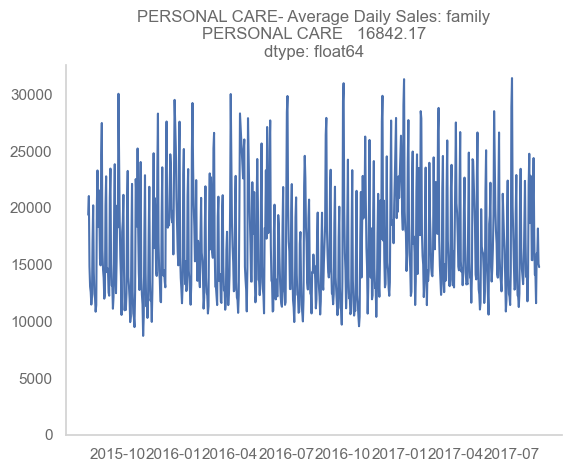

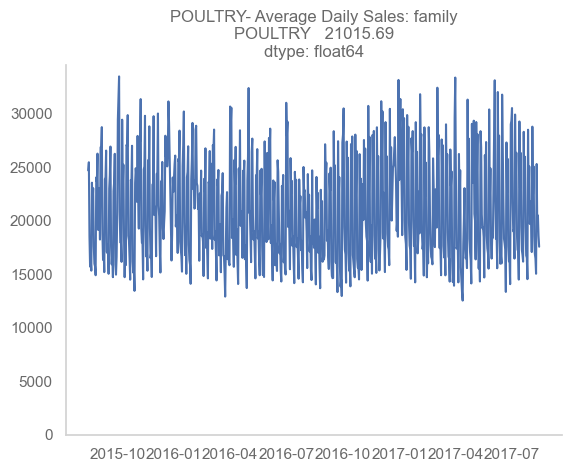

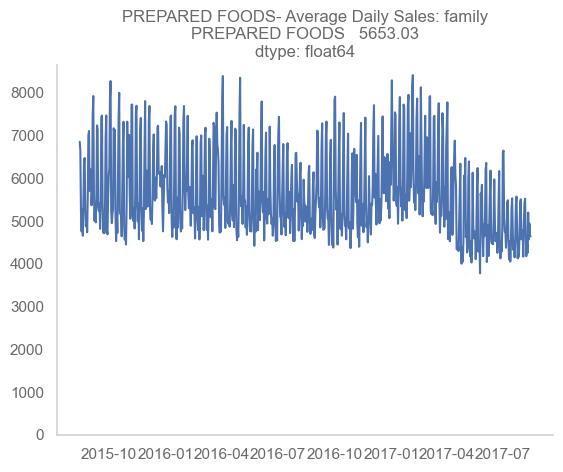

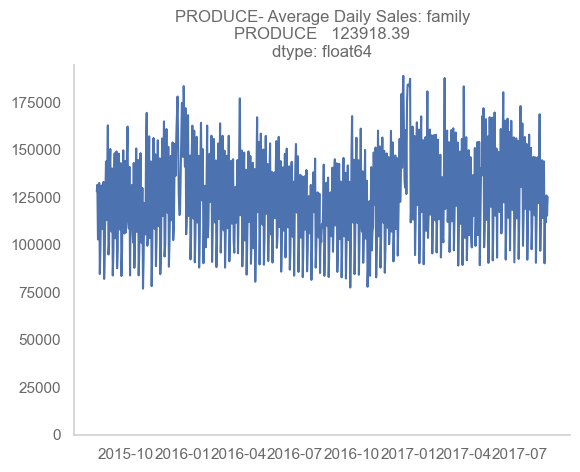

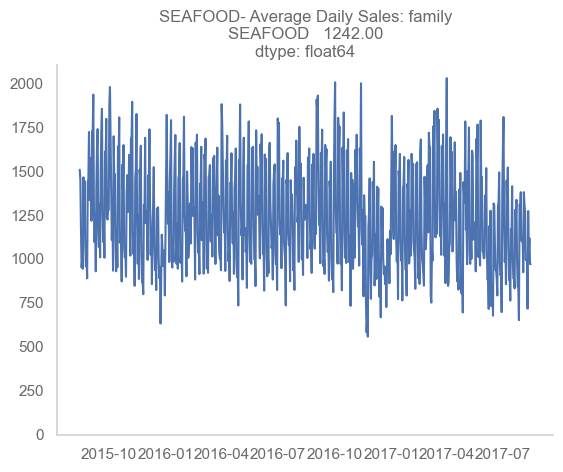

In [24]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

## Further Hypertuning

For further hypertuning, things to adjust would be on the category level. I'm not going to do further hypertuning in this notebook but here are the following things you can test and adjust to determine whether it's a category that can be predicted given the data.

1. **Liquor, Beer, Wine Category**:
   - Impute or drop situations since there are many 0s in the first year's worth of data.
   - See if it improves the MAPE after cross-validation.

2. **Grocery II and Frozen Food Categories**:
   - Impute or drop situations since there are 0s near the January 1st beginning of the year timeline that didn't get dropped during the z-score outlier automation.
   - See if it improves the MAPE after cross-validation.

3. **Adjust the z-score outlier parameter**:
   - Check out the Gaussian Distribution for different z-scores.
   - Check cut-offs and counts of rows being dropped.
   - See if there's an ideal situation for getting the best MAPE.
   - Loop through possible z-score possibilities, perhaps between 5 linear possibilities between 2.5 to 3.
   - Run the models with the best hypertuned parameters based on cross-validation to see if MAPE's change with a change in z-score outlier drops.


### PLOTTING CATEGORIES

In [25]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [26]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

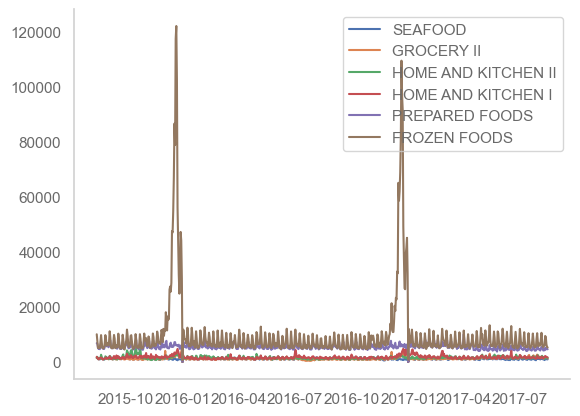

In [27]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

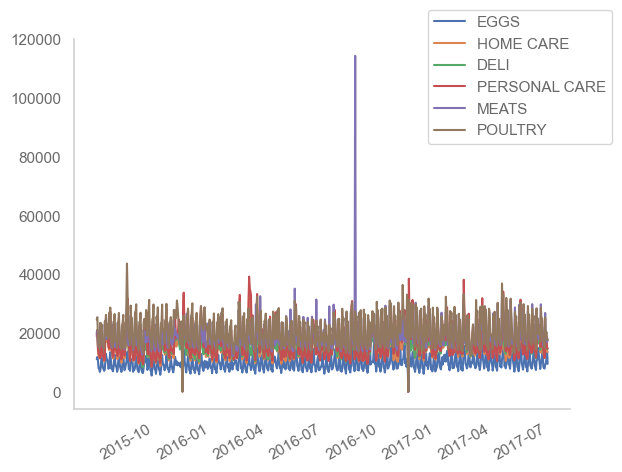

In [28]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

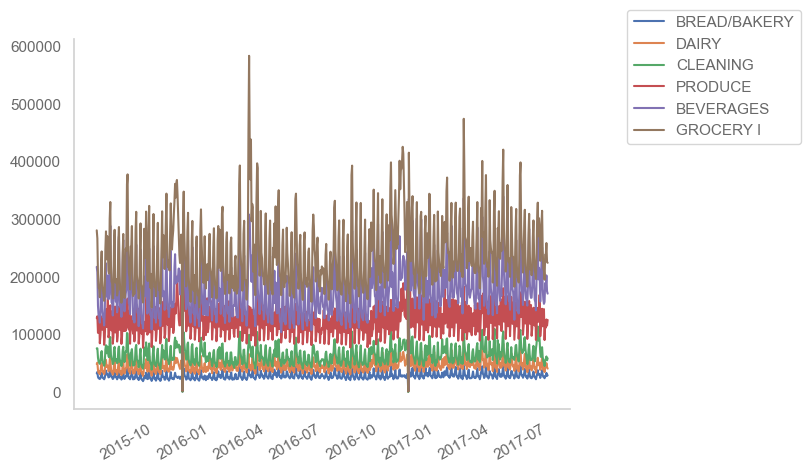

In [29]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

## Hyperparameter Tuning and Backtesting Pipeline

Ranges given in Prophet's documentation:

- **changepoint_prior_scale**: [0.001, 0.5]
- **seasonality_prior_scale**: [0.01, 10]
- **holidays_prior_scale**: [0.01, 10]
- **seasonality_mode**: ['additive', 'multiplicative']
- **changepoint_range**: [0.5, 0.95]


In [30]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [31]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [32]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

16:05:18 - cmdstanpy - INFO - Chain [1] start processing
16:05:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:18 - cmdstanpy - INFO - Chain [1] start processing
16:05:18 - cmdstanpy - INFO - Chain [1] done processing
16:05:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:18 - cmdstanpy - INFO - Chain [1] start processing
16:05:19 - cmdstanpy - INFO - Chain [1] done processing
16:05:19 - cmdstanpy - INFO - Chain [1] start processing
16:05:19 - cmdstanpy - INFO - Chain [1] done processing
16:05:19 - cmdstanpy - INFO - Chain [1] start processing
16:05:19 - cmdstanpy - INFO - Chain [1] done processing
16:05:19 - cmdstanpy - INFO - Chain [1] start processing
16:05:20 - cmdstanpy - INFO - Chain [1] done processing
16:05:20 - cmdstanpy - INFO - Chain [1] start processing
16:05:20 - cmdstanpy - INFO - Chain [1] done processing
16:05:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:20 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2046068804.79 45233.49 34229.75  0.33   0.16   0.20      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:24 - cmdstanpy - INFO - Chain [1] start processing
16:05:24 - cmdstanpy - INFO - Chain [1] done processing
16:05:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:24 - cmdstanpy - INFO - Chain [1] start processing
16:05:25 - cmdstanpy - INFO - Chain [1] done processing
16:05:25 - cmdstanpy - INFO - Chain [1] start processing
16:05:25 - cmdstanpy - INFO - Chain [1] done processing
16:05:25 - cmdstanpy - INFO - Chain [1] start processing
16:05:25 - cmdstanpy - INFO - Chain [1] done processing
16:05:25 - cmdstanpy - INFO - Chain [1] start processing
16:05:25 - cmdstanpy - INFO - Chain [1] done processing
16:05:26 - cmdstanpy - INFO - Chain [1] start processing
16:05:26 - cmdstanpy - INFO - Chain [1] done processing
16:05:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:26 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2184834031.78 46742.21 36720.37  0.37   0.17   0.22      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:30 - cmdstanpy - INFO - Chain [1] start processing
16:05:30 - cmdstanpy - INFO - Chain [1] done processing
16:05:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:30 - cmdstanpy - INFO - Chain [1] start processing
16:05:31 - cmdstanpy - INFO - Chain [1] done processing
16:05:31 - cmdstanpy - INFO - Chain [1] start processing
16:05:31 - cmdstanpy - INFO - Chain [1] done processing
16:05:31 - cmdstanpy - INFO - Chain [1] start processing
16:05:31 - cmdstanpy - INFO - Chain [1] done processing
16:05:31 - cmdstanpy - INFO - Chain [1] start processing
16:05:31 - cmdstanpy - INFO - Chain [1] done processing
16:05:32 - cmdstanpy - INFO - Chain [1] start processing
16:05:32 - cmdstanpy - INFO - Chain [1] done processing
16:05:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:32 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2167461343.34 46556.00 36444.87  0.37   0.17   0.22      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:36 - cmdstanpy - INFO - Chain [1] start processing
16:05:36 - cmdstanpy - INFO - Chain [1] done processing
16:05:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:36 - cmdstanpy - INFO - Chain [1] start processing
16:05:37 - cmdstanpy - INFO - Chain [1] done processing
16:05:37 - cmdstanpy - INFO - Chain [1] start processing
16:05:37 - cmdstanpy - INFO - Chain [1] done processing
16:05:37 - cmdstanpy - INFO - Chain [1] start processing
16:05:37 - cmdstanpy - INFO - Chain [1] done processing
16:05:37 - cmdstanpy - INFO - Chain [1] start processing
16:05:38 - cmdstanpy - INFO - Chain [1] done processing
16:05:38 - cmdstanpy - INFO - Chain [1] start processing
16:05:38 - cmdstanpy - INFO - Chain [1] done processing
16:05:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:38 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2156000724.35 46432.75 36236.30  0.36   0.17   0.22      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:42 - cmdstanpy - INFO - Chain [1] start processing
16:05:42 - cmdstanpy - INFO - Chain [1] done processing
16:05:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:42 - cmdstanpy - INFO - Chain [1] start processing
16:05:43 - cmdstanpy - INFO - Chain [1] done processing
16:05:43 - cmdstanpy - INFO - Chain [1] start processing
16:05:43 - cmdstanpy - INFO - Chain [1] done processing
16:05:44 - cmdstanpy - INFO - Chain [1] start processing
16:05:44 - cmdstanpy - INFO - Chain [1] done processing
16:05:44 - cmdstanpy - INFO - Chain [1] start processing
16:05:44 - cmdstanpy - INFO - Chain [1] done processing
16:05:44 - cmdstanpy - INFO - Chain [1] start processing
16:05:44 - cmdstanpy - INFO - Chain [1] done processing
16:05:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:44 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2160631349.20 46482.59 36395.90  0.37   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:49 - cmdstanpy - INFO - Chain [1] start processing
16:05:49 - cmdstanpy - INFO - Chain [1] done processing
16:05:49 - cmdstanpy - INFO - Chain [1] start processing
16:05:49 - cmdstanpy - INFO - Chain [1] done processing
16:05:49 - cmdstanpy - INFO - Chain [1] start processing
16:05:49 - cmdstanpy - INFO - Chain [1] done processing
16:05:49 - cmdstanpy - INFO - Chain [1] start processing
16:05:49 - cmdstanpy - INFO - Chain [1] done processing
16:05:49 - cmdstanpy - INFO - Chain [1] start processing
16:05:49 - cmdstanpy - INFO - Chain [1] done processing
16:05:50 - cmdstanpy - INFO - Chain [1] start processing
16:05:50 - cmdstanpy - INFO - Chain [1] done processing
16:05:50 - cmdstanpy - INFO - Chain [1] start processing
16:05:50 - cmdstanpy - INFO - Chain [1] done processing
16:05:50 - cmdstanpy - INFO - Chain [1] start processing
16:05:50 - cmdstanpy - INFO - Chain [1] done processing
16:05:50 - cmdstanpy - INFO - Chain [1] start processing
16:05:50 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1023401548.96 31990.65 22181.60  0.29   0.09   0.12      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:51 - cmdstanpy - INFO - Chain [1] start processing
16:05:51 - cmdstanpy - INFO - Chain [1] done processing
16:05:51 - cmdstanpy - INFO - Chain [1] start processing
16:05:51 - cmdstanpy - INFO - Chain [1] done processing
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
16:05:53 - cmdstanpy - INFO - Chain [1] done processing
16:05:53 - cmdstanpy - INFO - Chain [1] start processing
16:05:53 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1015866623.43 31872.66 21647.16  0.30   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing
16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
16:05:55 - cmdstanpy - INFO - Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1008237187.50 31752.75 21523.89  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:05:56 - cmdstanpy - INFO - Chain [1] start processing
16:05:56 - cmdstanpy - INFO - Chain [1] done processing
16:05:56 - cmdstanpy - INFO - Chain [1] start processing
16:05:57 - cmdstanpy - INFO - Chain [1] done processing
16:05:57 - cmdstanpy - INFO - Chain [1] start processing
16:05:57 - cmdstanpy - INFO - Chain [1] done processing
16:05:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:05:57 - cmdstanpy - INFO - Chain [1] start processing
16:06:00 - cmdstanpy - INFO - Chain [1] done processing
16:06:00 - cmdstanpy - INFO - Chain [1] start processing
16:06:00 - cmdstanpy - INFO - Chain [1] done processing
16:06:00 - cmdstanpy - INFO - Chain [1] start processing
16:06:00 - cmdstanpy - INFO - Chain [1] done processing
16:06:01 - cmdstanpy - INFO - Chain [1] start processing
16:06:01 - cmdstanpy - INFO - Chain [1] done processing
16:06:01 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1008887105.88 31762.98 21525.70  0.30   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:02 - cmdstanpy - INFO - Chain [1] start processing
16:06:02 - cmdstanpy - INFO - Chain [1] done processing
16:06:02 - cmdstanpy - INFO - Chain [1] start processing
16:06:02 - cmdstanpy - INFO - Chain [1] done processing
16:06:03 - cmdstanpy - INFO - Chain [1] start processing
16:06:03 - cmdstanpy - INFO - Chain [1] done processing
16:06:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:06:03 - cmdstanpy - INFO - Chain [1] start processing
16:06:06 - cmdstanpy - INFO - Chain [1] done processing
16:06:06 - cmdstanpy - INFO - Chain [1] start processing
16:06:06 - cmdstanpy - INFO - Chain [1] done processing
16:06:06 - cmdstanpy - INFO - Chain [1] start processing
16:06:06 - cmdstanpy - INFO - Chain [1] done processing
16:06:06 - cmdstanpy - INFO - Chain [1] start processing
16:06:06 - cmdstanpy - INFO - Chain [1] done processing
16:06:06 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1018085297.01 31907.45 21694.35  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:08 - cmdstanpy - INFO - Chain [1] start processing
16:06:08 - cmdstanpy - INFO - Chain [1] done processing
16:06:08 - cmdstanpy - INFO - Chain [1] start processing
16:06:08 - cmdstanpy - INFO - Chain [1] done processing
16:06:08 - cmdstanpy - INFO - Chain [1] start processing
16:06:08 - cmdstanpy - INFO - Chain [1] done processing
16:06:08 - cmdstanpy - INFO - Chain [1] start processing
16:06:08 - cmdstanpy - INFO - Chain [1] done processing
16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:09 - cmdstanpy - INFO - Chain [1] done processing
16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:09 - cmdstanpy - INFO - Chain [1] done processing
16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:09 - cmdstanpy - INFO - Chain [1] done processing
16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:09 - cmdstanpy - INFO - Chain [1] done processing
16:06:09 - cmdstanpy - INFO - Chain [1] start processing
16:06:09 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1043127714.58 32297.49 22155.94  0.30   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:10 - cmdstanpy - INFO - Chain [1] start processing
16:06:11 - cmdstanpy - INFO - Chain [1] done processing
16:06:11 - cmdstanpy - INFO - Chain [1] start processing
16:06:11 - cmdstanpy - INFO - Chain [1] done processing
16:06:11 - cmdstanpy - INFO - Chain [1] start processing
16:06:11 - cmdstanpy - INFO - Chain [1] done processing
16:06:11 - cmdstanpy - INFO - Chain [1] start processing
16:06:11 - cmdstanpy - INFO - Chain [1] done processing
16:06:11 - cmdstanpy - INFO - Chain [1] start processing
16:06:11 - cmdstanpy - INFO - Chain [1] done processing
16:06:11 - cmdstanpy - INFO - Chain [1] start processing
16:06:11 - cmdstanpy - INFO - Chain [1] done processing
16:06:12 - cmdstanpy - INFO - Chain [1] start processing
16:06:12 - cmdstanpy - INFO - Chain [1] done processing
16:06:12 - cmdstanpy - INFO - Chain [1] start processing
16:06:12 - cmdstanpy - INFO - Chain [1] done processing
16:06:12 - cmdstanpy - INFO - Chain [1] start processing
16:06:12 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1067013889.62 32665.18 22178.03  0.31   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:13 - cmdstanpy - INFO - Chain [1] start processing
16:06:13 - cmdstanpy - INFO - Chain [1] done processing
16:06:13 - cmdstanpy - INFO - Chain [1] start processing
16:06:13 - cmdstanpy - INFO - Chain [1] done processing
16:06:13 - cmdstanpy - INFO - Chain [1] start processing
16:06:13 - cmdstanpy - INFO - Chain [1] done processing
16:06:14 - cmdstanpy - INFO - Chain [1] start processing
16:06:14 - cmdstanpy - INFO - Chain [1] done processing
16:06:14 - cmdstanpy - INFO - Chain [1] start processing
16:06:14 - cmdstanpy - INFO - Chain [1] done processing
16:06:14 - cmdstanpy - INFO - Chain [1] start processing
16:06:14 - cmdstanpy - INFO - Chain [1] done processing
16:06:14 - cmdstanpy - INFO - Chain [1] start processing
16:06:14 - cmdstanpy - INFO - Chain [1] done processing
16:06:14 - cmdstanpy - INFO - Chain [1] start processing
16:06:14 - cmdstanpy - INFO - Chain [1] done processing
16:06:15 - cmdstanpy - INFO - Chain [1] start processing
16:06:15 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1068383424.62 32686.14 22215.48  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:16 - cmdstanpy - INFO - Chain [1] start processing
16:06:16 - cmdstanpy - INFO - Chain [1] done processing
16:06:16 - cmdstanpy - INFO - Chain [1] start processing
16:06:16 - cmdstanpy - INFO - Chain [1] done processing
16:06:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:06:16 - cmdstanpy - INFO - Chain [1] start processing
16:06:18 - cmdstanpy - INFO - Chain [1] done processing
16:06:18 - cmdstanpy - INFO - Chain [1] start processing
16:06:18 - cmdstanpy - INFO - Chain [1] done processing
16:06:18 - cmdstanpy - INFO - Chain [1] start processing
16:06:18 - cmdstanpy - INFO - Chain [1] done processing
16:06:18 - cmdstanpy - INFO - Chain [1] start processing
16:06:18 - cmdstanpy - INFO - Chain [1] done processing
16:06:18 - cmdstanpy - INFO - Chain [1] start processing
16:06:18 - cmdstanpy - INFO - Chain [1] done processing
16:06:19 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1066996070.76 32664.91 22180.32  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:20 - cmdstanpy - INFO - Chain [1] start processing
16:06:20 - cmdstanpy - INFO - Chain [1] done processing
16:06:20 - cmdstanpy - INFO - Chain [1] start processing
16:06:20 - cmdstanpy - INFO - Chain [1] done processing
16:06:20 - cmdstanpy - INFO - Chain [1] start processing
16:06:20 - cmdstanpy - INFO - Chain [1] done processing
16:06:21 - cmdstanpy - INFO - Chain [1] start processing
16:06:21 - cmdstanpy - INFO - Chain [1] done processing
16:06:21 - cmdstanpy - INFO - Chain [1] start processing
16:06:21 - cmdstanpy - INFO - Chain [1] done processing
16:06:21 - cmdstanpy - INFO - Chain [1] start processing
16:06:21 - cmdstanpy - INFO - Chain [1] done processing
16:06:21 - cmdstanpy - INFO - Chain [1] start processing
16:06:21 - cmdstanpy - INFO - Chain [1] done processing
16:06:21 - cmdstanpy - INFO - Chain [1] start processing
16:06:21 - cmdstanpy - INFO - Chain [1] done processing
16:06:22 - cmdstanpy - INFO - Chain [1] start processing
16:06:22 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1072919284.82 32755.45 22247.38  0.31   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:23 - cmdstanpy - INFO - Chain [1] start processing
16:06:23 - cmdstanpy - INFO - Chain [1] done processing
16:06:23 - cmdstanpy - INFO - Chain [1] start processing
16:06:23 - cmdstanpy - INFO - Chain [1] done processing
16:06:23 - cmdstanpy - INFO - Chain [1] start processing
16:06:23 - cmdstanpy - INFO - Chain [1] done processing
16:06:23 - cmdstanpy - INFO - Chain [1] start processing
16:06:23 - cmdstanpy - INFO - Chain [1] done processing
16:06:24 - cmdstanpy - INFO - Chain [1] start processing
16:06:24 - cmdstanpy - INFO - Chain [1] done processing
16:06:24 - cmdstanpy - INFO - Chain [1] start processing
16:06:24 - cmdstanpy - INFO - Chain [1] done processing
16:06:24 - cmdstanpy - INFO - Chain [1] start processing
16:06:24 - cmdstanpy - INFO - Chain [1] done processing
16:06:24 - cmdstanpy - INFO - Chain [1] start processing
16:06:24 - cmdstanpy - INFO - Chain [1] done processing
16:06:24 - cmdstanpy - INFO - Chain [1] start processing
16:06:24 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1046558750.08 32350.56 22120.52  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:25 - cmdstanpy - INFO - Chain [1] start processing
16:06:26 - cmdstanpy - INFO - Chain [1] done processing
16:06:26 - cmdstanpy - INFO - Chain [1] start processing
16:06:26 - cmdstanpy - INFO - Chain [1] done processing
16:06:26 - cmdstanpy - INFO - Chain [1] start processing
16:06:26 - cmdstanpy - INFO - Chain [1] done processing
16:06:26 - cmdstanpy - INFO - Chain [1] start processing
16:06:26 - cmdstanpy - INFO - Chain [1] done processing
16:06:26 - cmdstanpy - INFO - Chain [1] start processing
16:06:26 - cmdstanpy - INFO - Chain [1] done processing
16:06:26 - cmdstanpy - INFO - Chain [1] start processing
16:06:27 - cmdstanpy - INFO - Chain [1] done processing
16:06:27 - cmdstanpy - INFO - Chain [1] start processing
16:06:27 - cmdstanpy - INFO - Chain [1] done processing
16:06:27 - cmdstanpy - INFO - Chain [1] start processing
16:06:27 - cmdstanpy - INFO - Chain [1] done processing
16:06:27 - cmdstanpy - INFO - Chain [1] start processing
16:06:27 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1108220665.96 33289.95 23002.05  0.31   0.10   0.13      0.74


16:06:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:28 - cmdstanpy - INFO - Chain [1] start processing
16:06:28 - cmdstanpy - INFO - Chain [1] done processing
16:06:28 - cmdstanpy - INFO - Chain [1] start processing
16:06:28 - cmdstanpy - INFO - Chain [1] done processing
16:06:29 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing
16:06:29 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing
16:06:29 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing
16:06:29 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing
16:06:29 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing
16:06:30 - cmdstanpy - INFO - Chain [1] start processing
16:06:30 - cmdstanpy - INFO - Chain [1] done processing
16:06:30 - cmdstanpy - INFO - Chain [1] start processing
16:06:30 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1114001211.78 33376.66 23134.83  0.31   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:31 - cmdstanpy - INFO - Chain [1] start processing
16:06:31 - cmdstanpy - INFO - Chain [1] done processing
16:06:31 - cmdstanpy - INFO - Chain [1] start processing
16:06:31 - cmdstanpy - INFO - Chain [1] done processing
16:06:31 - cmdstanpy - INFO - Chain [1] start processing
16:06:31 - cmdstanpy - INFO - Chain [1] done processing
16:06:31 - cmdstanpy - INFO - Chain [1] start processing
16:06:31 - cmdstanpy - INFO - Chain [1] done processing
16:06:32 - cmdstanpy - INFO - Chain [1] start processing
16:06:32 - cmdstanpy - INFO - Chain [1] done processing
16:06:32 - cmdstanpy - INFO - Chain [1] start processing
16:06:32 - cmdstanpy - INFO - Chain [1] done processing
16:06:32 - cmdstanpy - INFO - Chain [1] start processing
16:06:32 - cmdstanpy - INFO - Chain [1] done processing
16:06:32 - cmdstanpy - INFO - Chain [1] start processing
16:06:32 - cmdstanpy - INFO - Chain [1] done processing
16:06:32 - cmdstanpy - INFO - Chain [1] start processing
16:06:32 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1112676263.53 33356.80 23058.70  0.31   0.10   0.13      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:34 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing
16:06:34 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing
16:06:34 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing
16:06:34 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing
16:06:34 - cmdstanpy - INFO - Chain [1] start processing
16:06:34 - cmdstanpy - INFO - Chain [1] done processing
16:06:35 - cmdstanpy - INFO - Chain [1] start processing
16:06:35 - cmdstanpy - INFO - Chain [1] done processing
16:06:35 - cmdstanpy - INFO - Chain [1] start processing
16:06:35 - cmdstanpy - INFO - Chain [1] done processing
16:06:35 - cmdstanpy - INFO - Chain [1] start processing
16:06:35 - cmdstanpy - INFO - Chain [1] done processing
16:06:35 - cmdstanpy - INFO - Chain [1] start processing
16:06:35 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1104869276.76 33239.57 23011.09  0.31   0.10   0.13      0.76


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:36 - cmdstanpy - INFO - Chain [1] start processing
16:06:36 - cmdstanpy - INFO - Chain [1] done processing
16:06:36 - cmdstanpy - INFO - Chain [1] start processing
16:06:37 - cmdstanpy - INFO - Chain [1] done processing
16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:37 - cmdstanpy - INFO - Chain [1] done processing
16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:37 - cmdstanpy - INFO - Chain [1] done processing
16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:37 - cmdstanpy - INFO - Chain [1] done processing
16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:37 - cmdstanpy - INFO - Chain [1] done processing
16:06:37 - cmdstanpy - INFO - Chain [1] start processing
16:06:38 - cmdstanpy - INFO - Chain [1] done processing
16:06:38 - cmdstanpy - INFO - Chain [1] start processing
16:06:38 - cmdstanpy - INFO - Chain [1] done processing
16:06:38 - cmdstanpy - INFO - Chain [1] start processing
16:06:38 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1026110396.30 32032.96 21856.30  0.30   0.09   0.12      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:39 - cmdstanpy - INFO - Chain [1] start processing
16:06:39 - cmdstanpy - INFO - Chain [1] done processing
16:06:39 - cmdstanpy - INFO - Chain [1] start processing
16:06:39 - cmdstanpy - INFO - Chain [1] done processing
16:06:39 - cmdstanpy - INFO - Chain [1] start processing
16:06:40 - cmdstanpy - INFO - Chain [1] done processing
16:06:40 - cmdstanpy - INFO - Chain [1] start processing
16:06:40 - cmdstanpy - INFO - Chain [1] done processing
16:06:40 - cmdstanpy - INFO - Chain [1] start processing
16:06:40 - cmdstanpy - INFO - Chain [1] done processing
16:06:40 - cmdstanpy - INFO - Chain [1] start processing
16:06:40 - cmdstanpy - INFO - Chain [1] done processing
16:06:40 - cmdstanpy - INFO - Chain [1] start processing
16:06:40 - cmdstanpy - INFO - Chain [1] done processing
16:06:41 - cmdstanpy - INFO - Chain [1] start processing
16:06:41 - cmdstanpy - INFO - Chain [1] done processing
16:06:41 - cmdstanpy - INFO - Chain [1] start processing
16:06:41 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1159903504.53 34057.36 23862.36  0.32   0.10   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:42 - cmdstanpy - INFO - Chain [1] start processing
16:06:42 - cmdstanpy - INFO - Chain [1] done processing
16:06:42 - cmdstanpy - INFO - Chain [1] start processing
16:06:42 - cmdstanpy - INFO - Chain [1] done processing
16:06:42 - cmdstanpy - INFO - Chain [1] start processing
16:06:42 - cmdstanpy - INFO - Chain [1] done processing
16:06:42 - cmdstanpy - INFO - Chain [1] start processing
16:06:43 - cmdstanpy - INFO - Chain [1] done processing
16:06:43 - cmdstanpy - INFO - Chain [1] start processing
16:06:43 - cmdstanpy - INFO - Chain [1] done processing
16:06:43 - cmdstanpy - INFO - Chain [1] start processing
16:06:43 - cmdstanpy - INFO - Chain [1] done processing
16:06:43 - cmdstanpy - INFO - Chain [1] start processing
16:06:43 - cmdstanpy - INFO - Chain [1] done processing
16:06:43 - cmdstanpy - INFO - Chain [1] start processing
16:06:43 - cmdstanpy - INFO - Chain [1] done processing
16:06:43 - cmdstanpy - INFO - Chain [1] start processing
16:06:44 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1157655344.76 34024.33 23908.76  0.32   0.11   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:45 - cmdstanpy - INFO - Chain [1] done processing
16:06:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:45 - cmdstanpy - INFO - Chain [1] done processing
16:06:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:45 - cmdstanpy - INFO - Chain [1] done processing
16:06:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:45 - cmdstanpy - INFO - Chain [1] done processing
16:06:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1] done processing
16:06:46 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1] done processing
16:06:46 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1] done processing
16:06:46 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1] done processing
16:06:46 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1171902016.32 34233.05 24080.76  0.32   0.10   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:47 - cmdstanpy - INFO - Chain [1] start processing
16:06:47 - cmdstanpy - INFO - Chain [1] done processing
16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:48 - cmdstanpy - INFO - Chain [1] done processing
16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:48 - cmdstanpy - INFO - Chain [1] done processing
16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:48 - cmdstanpy - INFO - Chain [1] done processing
16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:48 - cmdstanpy - INFO - Chain [1] done processing
16:06:48 - cmdstanpy - INFO - Chain [1] start processing
16:06:48 - cmdstanpy - INFO - Chain [1] done processing
16:06:49 - cmdstanpy - INFO - Chain [1] start processing
16:06:49 - cmdstanpy - INFO - Chain [1] done processing
16:06:49 - cmdstanpy - INFO - Chain [1] start processing
16:06:49 - cmdstanpy - INFO - Chain [1] done processing
16:06:49 - cmdstanpy - INFO - Chain [1] start processing
16:06:49 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1173077219.28 34250.21 24088.66  0.32   0.11   0.13      0.74
BEVERAGES
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.33
1                     0.00                     2.51  0.37
2                     0.00                     5.00  0.37
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.37


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:50 - cmdstanpy - INFO - Chain [1] start processing
16:06:50 - cmdstanpy - INFO - Chain [1] done processing
16:06:50 - cmdstanpy - INFO - Chain [1] start processing
16:06:50 - cmdstanpy - INFO - Chain [1] done processing
16:06:50 - cmdstanpy - INFO - Chain [1] start processing
16:06:51 - cmdstanpy - INFO - Chain [1] done processing
16:06:51 - cmdstanpy - INFO - Chain [1] start processing
16:06:51 - cmdstanpy - INFO - Chain [1] done processing
16:06:51 - cmdstanpy - INFO - Chain [1] start processing
16:06:51 - cmdstanpy - INFO - Chain [1] done processing
16:06:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:06:51 - cmdstanpy - INFO - Chain [1] start processing
16:06:52 - cmdstanpy - INFO - Chain [1] done processing
16:06:52 - cmdstanpy - INFO - Chain [1] start processing
16:06:52 - cmdstanpy - INFO - Chain [1] done processing
16:06:52 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18042261.51 4247.62 2847.73  0.29   0.07   0.10      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:06:55 - cmdstanpy - INFO - Chain [1] start processing
16:06:55 - cmdstanpy - INFO - Chain [1] done processing
16:06:55 - cmdstanpy - INFO - Chain [1] start processing
16:06:55 - cmdstanpy - INFO - Chain [1] done processing
16:06:56 - cmdstanpy - INFO - Chain [1] start processing
16:06:56 - cmdstanpy - INFO - Chain [1] done processing
16:06:56 - cmdstanpy - INFO - Chain [1] start processing
16:06:56 - cmdstanpy - INFO - Chain [1] done processing
16:06:56 - cmdstanpy - INFO - Chain [1] start processing
16:06:56 - cmdstanpy - INFO - Chain [1] done processing
16:06:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:06:56 - cmdstanpy - INFO - Chain [1] start processing
16:06:58 - cmdstanpy - INFO - Chain [1] done processing
16:06:58 - cmdstanpy - INFO - Chain [1] start processing
16:06:58 - cmdstanpy - INFO - Chain [1] done processing
16:06:58 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20021924.72 4474.59 3142.04  0.31   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:01 - cmdstanpy - INFO - Chain [1] start processing
16:07:01 - cmdstanpy - INFO - Chain [1] done processing
16:07:02 - cmdstanpy - INFO - Chain [1] start processing
16:07:02 - cmdstanpy - INFO - Chain [1] done processing
16:07:02 - cmdstanpy - INFO - Chain [1] start processing
16:07:02 - cmdstanpy - INFO - Chain [1] done processing
16:07:02 - cmdstanpy - INFO - Chain [1] start processing
16:07:02 - cmdstanpy - INFO - Chain [1] done processing
16:07:02 - cmdstanpy - INFO - Chain [1] start processing
16:07:02 - cmdstanpy - INFO - Chain [1] done processing
16:07:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:07:02 - cmdstanpy - INFO - Chain [1] start processing
16:07:03 - cmdstanpy - INFO - Chain [1] done processing
16:07:03 - cmdstanpy - INFO - Chain [1] start processing
16:07:03 - cmdstanpy - INFO - Chain [1] done processing
16:07:03 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19860854.30 4456.55 3135.70  0.31   0.09   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:07 - cmdstanpy - INFO - Chain [1] start processing
16:07:07 - cmdstanpy - INFO - Chain [1] done processing
16:07:07 - cmdstanpy - INFO - Chain [1] start processing
16:07:07 - cmdstanpy - INFO - Chain [1] done processing
16:07:07 - cmdstanpy - INFO - Chain [1] start processing
16:07:07 - cmdstanpy - INFO - Chain [1] done processing
16:07:07 - cmdstanpy - INFO - Chain [1] start processing
16:07:07 - cmdstanpy - INFO - Chain [1] done processing
16:07:07 - cmdstanpy - INFO - Chain [1] start processing
16:07:08 - cmdstanpy - INFO - Chain [1] done processing
16:07:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:07:08 - cmdstanpy - INFO - Chain [1] start processing
16:07:08 - cmdstanpy - INFO - Chain [1] done processing
16:07:08 - cmdstanpy - INFO - Chain [1] start processing
16:07:08 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19785858.55 4448.13 3088.86  0.31   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:07:12 - cmdstanpy - INFO - Chain [1] done processing
16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:07:12 - cmdstanpy - INFO - Chain [1] done processing
16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:07:12 - cmdstanpy - INFO - Chain [1] done processing
16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:07:12 - cmdstanpy - INFO - Chain [1] done processing
16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:07:12 - cmdstanpy - INFO - Chain [1] done processing
16:07:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:07:13 - cmdstanpy - INFO - Chain [1] done processing
16:07:13 - cmdstanpy - INFO - Chain [1] start processing
16:07:13 - cmdstanpy - INFO - Chain [1] done processing
16:07:14 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20151916.71 4489.09 3164.42  0.31   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:17 - cmdstanpy - INFO - Chain [1] start processing
16:07:17 - cmdstanpy - INFO - Chain [1] done processing
16:07:17 - cmdstanpy - INFO - Chain [1] start processing
16:07:17 - cmdstanpy - INFO - Chain [1] done processing
16:07:17 - cmdstanpy - INFO - Chain [1] start processing
16:07:17 - cmdstanpy - INFO - Chain [1] done processing
16:07:17 - cmdstanpy - INFO - Chain [1] start processing
16:07:17 - cmdstanpy - INFO - Chain [1] done processing
16:07:18 - cmdstanpy - INFO - Chain [1] start processing
16:07:18 - cmdstanpy - INFO - Chain [1] done processing
16:07:18 - cmdstanpy - INFO - Chain [1] start processing
16:07:18 - cmdstanpy - INFO - Chain [1] done processing
16:07:18 - cmdstanpy - INFO - Chain [1] start processing
16:07:18 - cmdstanpy - INFO - Chain [1] done processing
16:07:18 - cmdstanpy - INFO - Chain [1] start processing
16:07:18 - cmdstanpy - INFO - Chain [1] done processing
16:07:18 - cmdstanpy - INFO - Chain [1] start processing
16:07:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14457754.40 3802.34 2582.42  0.29   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:19 - cmdstanpy - INFO - Chain [1] start processing
16:07:19 - cmdstanpy - INFO - Chain [1] done processing
16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:20 - cmdstanpy - INFO - Chain [1] done processing
16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:20 - cmdstanpy - INFO - Chain [1] done processing
16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:20 - cmdstanpy - INFO - Chain [1] done processing
16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:20 - cmdstanpy - INFO - Chain [1] done processing
16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:20 - cmdstanpy - INFO - Chain [1] done processing
16:07:20 - cmdstanpy - INFO - Chain [1] start processing
16:07:20 - cmdstanpy - INFO - Chain [1] done processing
16:07:21 - cmdstanpy - INFO - Chain [1] start processing
16:07:21 - cmdstanpy - INFO - Chain [1] done processing
16:07:21 - cmdstanpy - INFO - Chain [1] start processing
16:07:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14711989.20 3835.62 2498.32  0.30   0.06   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:22 - cmdstanpy - INFO - Chain [1] start processing
16:07:22 - cmdstanpy - INFO - Chain [1] done processing
16:07:22 - cmdstanpy - INFO - Chain [1] start processing
16:07:22 - cmdstanpy - INFO - Chain [1] done processing
16:07:22 - cmdstanpy - INFO - Chain [1] start processing
16:07:22 - cmdstanpy - INFO - Chain [1] done processing
16:07:22 - cmdstanpy - INFO - Chain [1] start processing
16:07:22 - cmdstanpy - INFO - Chain [1] done processing
16:07:23 - cmdstanpy - INFO - Chain [1] start processing
16:07:23 - cmdstanpy - INFO - Chain [1] done processing
16:07:23 - cmdstanpy - INFO - Chain [1] start processing
16:07:23 - cmdstanpy - INFO - Chain [1] done processing
16:07:23 - cmdstanpy - INFO - Chain [1] start processing
16:07:23 - cmdstanpy - INFO - Chain [1] done processing
16:07:23 - cmdstanpy - INFO - Chain [1] start processing
16:07:23 - cmdstanpy - INFO - Chain [1] done processing
16:07:23 - cmdstanpy - INFO - Chain [1] start processing
16:07:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14833979.38 3851.49 2526.26  0.30   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:24 - cmdstanpy - INFO - Chain [1] start processing
16:07:24 - cmdstanpy - INFO - Chain [1] done processing
16:07:24 - cmdstanpy - INFO - Chain [1] start processing
16:07:25 - cmdstanpy - INFO - Chain [1] done processing
16:07:25 - cmdstanpy - INFO - Chain [1] start processing
16:07:25 - cmdstanpy - INFO - Chain [1] done processing
16:07:25 - cmdstanpy - INFO - Chain [1] start processing
16:07:25 - cmdstanpy - INFO - Chain [1] done processing
16:07:25 - cmdstanpy - INFO - Chain [1] start processing
16:07:25 - cmdstanpy - INFO - Chain [1] done processing
16:07:25 - cmdstanpy - INFO - Chain [1] start processing
16:07:25 - cmdstanpy - INFO - Chain [1] done processing
16:07:25 - cmdstanpy - INFO - Chain [1] start processing
16:07:25 - cmdstanpy - INFO - Chain [1] done processing
16:07:26 - cmdstanpy - INFO - Chain [1] start processing
16:07:26 - cmdstanpy - INFO - Chain [1] done processing
16:07:26 - cmdstanpy - INFO - Chain [1] start processing
16:07:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14841975.72 3852.53 2524.09  0.30   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:27 - cmdstanpy - INFO - Chain [1] start processing
16:07:27 - cmdstanpy - INFO - Chain [1] done processing
16:07:27 - cmdstanpy - INFO - Chain [1] start processing
16:07:27 - cmdstanpy - INFO - Chain [1] done processing
16:07:27 - cmdstanpy - INFO - Chain [1] start processing
16:07:27 - cmdstanpy - INFO - Chain [1] done processing
16:07:27 - cmdstanpy - INFO - Chain [1] start processing
16:07:27 - cmdstanpy - INFO - Chain [1] done processing
16:07:28 - cmdstanpy - INFO - Chain [1] start processing
16:07:28 - cmdstanpy - INFO - Chain [1] done processing
16:07:28 - cmdstanpy - INFO - Chain [1] start processing
16:07:28 - cmdstanpy - INFO - Chain [1] done processing
16:07:28 - cmdstanpy - INFO - Chain [1] start processing
16:07:28 - cmdstanpy - INFO - Chain [1] done processing
16:07:28 - cmdstanpy - INFO - Chain [1] start processing
16:07:28 - cmdstanpy - INFO - Chain [1] done processing
16:07:28 - cmdstanpy - INFO - Chain [1] start processing
16:07:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14803175.72 3847.49 2518.91  0.30   0.07   0.09      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:29 - cmdstanpy - INFO - Chain [1] start processing
16:07:29 - cmdstanpy - INFO - Chain [1] done processing
16:07:30 - cmdstanpy - INFO - Chain [1] start processing
16:07:30 - cmdstanpy - INFO - Chain [1] done processing
16:07:30 - cmdstanpy - INFO - Chain [1] start processing
16:07:30 - cmdstanpy - INFO - Chain [1] done processing
16:07:30 - cmdstanpy - INFO - Chain [1] start processing
16:07:30 - cmdstanpy - INFO - Chain [1] done processing
16:07:30 - cmdstanpy - INFO - Chain [1] start processing
16:07:30 - cmdstanpy - INFO - Chain [1] done processing
16:07:30 - cmdstanpy - INFO - Chain [1] start processing
16:07:30 - cmdstanpy - INFO - Chain [1] done processing
16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:07:31 - cmdstanpy - INFO - Chain [1] done processing
16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:07:31 - cmdstanpy - INFO - Chain [1] done processing
16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:07:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14095478.73 3754.39 2485.46  0.29   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:32 - cmdstanpy - INFO - Chain [1] start processing
16:07:32 - cmdstanpy - INFO - Chain [1] done processing
16:07:32 - cmdstanpy - INFO - Chain [1] start processing
16:07:32 - cmdstanpy - INFO - Chain [1] done processing
16:07:32 - cmdstanpy - INFO - Chain [1] start processing
16:07:33 - cmdstanpy - INFO - Chain [1] done processing
16:07:33 - cmdstanpy - INFO - Chain [1] start processing
16:07:33 - cmdstanpy - INFO - Chain [1] done processing
16:07:33 - cmdstanpy - INFO - Chain [1] start processing
16:07:33 - cmdstanpy - INFO - Chain [1] done processing
16:07:33 - cmdstanpy - INFO - Chain [1] start processing
16:07:33 - cmdstanpy - INFO - Chain [1] done processing
16:07:33 - cmdstanpy - INFO - Chain [1] start processing
16:07:33 - cmdstanpy - INFO - Chain [1] done processing
16:07:33 - cmdstanpy - INFO - Chain [1] start processing
16:07:34 - cmdstanpy - INFO - Chain [1] done processing
16:07:34 - cmdstanpy - INFO - Chain [1] start processing
16:07:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14478453.16 3805.06 2444.86  0.30   0.06   0.08      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:35 - cmdstanpy - INFO - Chain [1] start processing
16:07:35 - cmdstanpy - INFO - Chain [1] done processing
16:07:35 - cmdstanpy - INFO - Chain [1] start processing
16:07:35 - cmdstanpy - INFO - Chain [1] done processing
16:07:35 - cmdstanpy - INFO - Chain [1] start processing
16:07:35 - cmdstanpy - INFO - Chain [1] done processing
16:07:35 - cmdstanpy - INFO - Chain [1] start processing
16:07:35 - cmdstanpy - INFO - Chain [1] done processing
16:07:36 - cmdstanpy - INFO - Chain [1] start processing
16:07:36 - cmdstanpy - INFO - Chain [1] done processing
16:07:36 - cmdstanpy - INFO - Chain [1] start processing
16:07:36 - cmdstanpy - INFO - Chain [1] done processing
16:07:36 - cmdstanpy - INFO - Chain [1] start processing
16:07:36 - cmdstanpy - INFO - Chain [1] done processing
16:07:36 - cmdstanpy - INFO - Chain [1] start processing
16:07:36 - cmdstanpy - INFO - Chain [1] done processing
16:07:36 - cmdstanpy - INFO - Chain [1] start processing
16:07:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14456260.47 3802.14 2440.58  0.30   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:37 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
16:07:38 - cmdstanpy - INFO - Chain [1] start processing
16:07:38 - cmdstanpy - INFO - Chain [1] done processing
16:07:39 - cmdstanpy - INFO - Chain [1] start processing
16:07:39 - cmdstanpy - INFO - Chain [1] done processing
16:07:39 - cmdstanpy - INFO - Chain [1] start processing
16:07:39 - cmdstanpy - INFO - Chain [1] done processing
16:07:39 - cmdstanpy - INFO - Chain [1] start processing
16:07:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14589931.43 3819.68 2461.89  0.30   0.06   0.08      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:40 - cmdstanpy - INFO - Chain [1] start processing
16:07:40 - cmdstanpy - INFO - Chain [1] done processing
16:07:40 - cmdstanpy - INFO - Chain [1] start processing
16:07:40 - cmdstanpy - INFO - Chain [1] done processing
16:07:40 - cmdstanpy - INFO - Chain [1] start processing
16:07:40 - cmdstanpy - INFO - Chain [1] done processing
16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:07:41 - cmdstanpy - INFO - Chain [1] done processing
16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:07:41 - cmdstanpy - INFO - Chain [1] done processing
16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:07:41 - cmdstanpy - INFO - Chain [1] done processing
16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:07:41 - cmdstanpy - INFO - Chain [1] done processing
16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:07:41 - cmdstanpy - INFO - Chain [1] done processing
16:07:41 - cmdstanpy - INFO - Chain [1] start processing
16:07:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14506300.60 3808.71 2447.88  0.30   0.06   0.08      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
16:07:43 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
16:07:44 - cmdstanpy - INFO - Chain [1] start processing
16:07:44 - cmdstanpy - INFO - Chain [1] done processing
16:07:44 - cmdstanpy - INFO - Chain [1] start processing
16:07:44 - cmdstanpy - INFO - Chain [1] done processing
16:07:44 - cmdstanpy - INFO - Chain [1] start processing
16:07:44 - cmdstanpy - INFO - Chain [1] done processing
16:07:44 - cmdstanpy - INFO - Chain [1] start processing
16:07:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13852453.64 3721.89 2431.67  0.29   0.07   0.08      0.83


16:07:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:45 - cmdstanpy - INFO - Chain [1] start processing
16:07:45 - cmdstanpy - INFO - Chain [1] done processing
16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:07:46 - cmdstanpy - INFO - Chain [1] done processing
16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:07:46 - cmdstanpy - INFO - Chain [1] done processing
16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:07:46 - cmdstanpy - INFO - Chain [1] done processing
16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:07:46 - cmdstanpy - INFO - Chain [1] done processing
16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:07:46 - cmdstanpy - INFO - Chain [1] done processing
16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:47 - cmdstanpy - INFO - Chain [1] done processing
16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:47 - cmdstanpy - INFO - Chain [1] done processing
16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14396427.91 3794.26 2423.43  0.30   0.06   0.08      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:48 - cmdstanpy - INFO - Chain [1] start processing
16:07:48 - cmdstanpy - INFO - Chain [1] done processing
16:07:48 - cmdstanpy - INFO - Chain [1] start processing
16:07:48 - cmdstanpy - INFO - Chain [1] done processing
16:07:48 - cmdstanpy - INFO - Chain [1] start processing
16:07:48 - cmdstanpy - INFO - Chain [1] done processing
16:07:49 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing
16:07:49 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing
16:07:49 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing
16:07:49 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing
16:07:49 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing
16:07:50 - cmdstanpy - INFO - Chain [1] start processing
16:07:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14419701.84 3797.33 2427.09  0.30   0.06   0.08      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:51 - cmdstanpy - INFO - Chain [1] done processing
16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:51 - cmdstanpy - INFO - Chain [1] done processing
16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:51 - cmdstanpy - INFO - Chain [1] done processing
16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:51 - cmdstanpy - INFO - Chain [1] done processing
16:07:51 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1] done processing
16:07:52 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1] done processing
16:07:52 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1] done processing
16:07:52 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1] done processing
16:07:52 - cmdstanpy - INFO - Chain [1] start processing
16:07:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14417127.90 3796.99 2425.84  0.30   0.06   0.08      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:53 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1] done processing
16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1] done processing
16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14408389.12 3795.84 2424.25  0.30   0.06   0.08      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:56 - cmdstanpy - INFO - Chain [1] start processing
16:07:56 - cmdstanpy - INFO - Chain [1] done processing
16:07:56 - cmdstanpy - INFO - Chain [1] start processing
16:07:56 - cmdstanpy - INFO - Chain [1] done processing
16:07:57 - cmdstanpy - INFO - Chain [1] start processing
16:07:57 - cmdstanpy - INFO - Chain [1] done processing
16:07:57 - cmdstanpy - INFO - Chain [1] start processing
16:07:57 - cmdstanpy - INFO - Chain [1] done processing
16:07:57 - cmdstanpy - INFO - Chain [1] start processing
16:07:57 - cmdstanpy - INFO - Chain [1] done processing
16:07:57 - cmdstanpy - INFO - Chain [1] start processing
16:07:57 - cmdstanpy - INFO - Chain [1] done processing
16:07:57 - cmdstanpy - INFO - Chain [1] start processing
16:07:57 - cmdstanpy - INFO - Chain [1] done processing
16:07:58 - cmdstanpy - INFO - Chain [1] start processing
16:07:58 - cmdstanpy - INFO - Chain [1] done processing
16:07:58 - cmdstanpy - INFO - Chain [1] start processing
16:07:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13730584.72 3705.48 2399.61  0.29   0.07   0.08      0.82


16:07:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:07:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:59 - cmdstanpy - INFO - Chain [1] done processing
16:07:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:59 - cmdstanpy - INFO - Chain [1] done processing
16:07:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:59 - cmdstanpy - INFO - Chain [1] done processing
16:07:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:59 - cmdstanpy - INFO - Chain [1] done processing
16:08:00 - cmdstanpy - INFO - Chain [1] start processing
16:08:00 - cmdstanpy - INFO - Chain [1] done processing
16:08:00 - cmdstanpy - INFO - Chain [1] start processing
16:08:00 - cmdstanpy - INFO - Chain [1] done processing
16:08:00 - cmdstanpy - INFO - Chain [1] start processing
16:08:00 - cmdstanpy - INFO - Chain [1] done processing
16:08:00 - cmdstanpy - INFO - Chain [1] start processing
16:08:00 - cmdstanpy - INFO - Chain [1] done processing
16:08:00 - cmdstanpy - INFO - Chain [1] start processing
16:08:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14319141.31 3784.06 2397.24  0.30   0.06   0.08      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:02 - cmdstanpy - INFO - Chain [1] done processing
16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:02 - cmdstanpy - INFO - Chain [1] done processing
16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:02 - cmdstanpy - INFO - Chain [1] done processing
16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:02 - cmdstanpy - INFO - Chain [1] done processing
16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:02 - cmdstanpy - INFO - Chain [1] done processing
16:08:02 - cmdstanpy - INFO - Chain [1] start processing
16:08:03 - cmdstanpy - INFO - Chain [1] done processing
16:08:03 - cmdstanpy - INFO - Chain [1] start processing
16:08:03 - cmdstanpy - INFO - Chain [1] done processing
16:08:03 - cmdstanpy - INFO - Chain [1] start processing
16:08:03 - cmdstanpy - INFO - Chain [1] done processing
16:08:03 - cmdstanpy - INFO - Chain [1] start processing
16:08:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14340106.42 3786.83 2399.24  0.30   0.06   0.08      0.82


16:08:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:04 - cmdstanpy - INFO - Chain [1] start processing
16:08:04 - cmdstanpy - INFO - Chain [1] done processing
16:08:04 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing
16:08:05 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing
16:08:05 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing
16:08:05 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing
16:08:05 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing
16:08:05 - cmdstanpy - INFO - Chain [1] start processing
16:08:06 - cmdstanpy - INFO - Chain [1] done processing
16:08:06 - cmdstanpy - INFO - Chain [1] start processing
16:08:06 - cmdstanpy - INFO - Chain [1] done processing
16:08:06 - cmdstanpy - INFO - Chain [1] start processing
16:08:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14350565.02 3788.21 2404.81  0.30   0.06   0.08      0.83


16:08:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:07 - cmdstanpy - INFO - Chain [1] start processing
16:08:07 - cmdstanpy - INFO - Chain [1] done processing
16:08:07 - cmdstanpy - INFO - Chain [1] start processing
16:08:07 - cmdstanpy - INFO - Chain [1] done processing
16:08:07 - cmdstanpy - INFO - Chain [1] start processing
16:08:07 - cmdstanpy - INFO - Chain [1] done processing
16:08:08 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing
16:08:08 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing
16:08:08 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing
16:08:08 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing
16:08:08 - cmdstanpy - INFO - Chain [1] start processing
16:08:08 - cmdstanpy - INFO - Chain [1] done processing
16:08:09 - cmdstanpy - INFO - Chain [1] start processing
16:08:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14335865.15 3786.27 2402.35  0.30   0.06   0.08      0.82
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.29
1                     0.00                     2.51  0.31
2                     0.00                     5.00  0.31
3                     0.00                     7.50  0.31
4                     0.00                    10.00  0.31


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:10 - cmdstanpy - INFO - Chain [1] start processing
16:08:10 - cmdstanpy - INFO - Chain [1] done processing
16:08:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:10 - cmdstanpy - INFO - Chain [1] start processing
16:08:11 - cmdstanpy - INFO - Chain [1] done processing
16:08:11 - cmdstanpy - INFO - Chain [1] start processing
16:08:11 - cmdstanpy - INFO - Chain [1] done processing
16:08:11 - cmdstanpy - INFO - Chain [1] start processing
16:08:11 - cmdstanpy - INFO - Chain [1] done processing
16:08:11 - cmdstanpy - INFO - Chain [1] start processing
16:08:11 - cmdstanpy - INFO - Chain [1] done processing
16:08:11 - cmdstanpy - INFO - Chain [1] start processing
16:08:12 - cmdstanpy - INFO - Chain [1] done processing
16:08:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:12 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 267753152.02 16363.16 12058.77  0.71   0.14   0.19      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:14 - cmdstanpy - INFO - Chain [1] start processing
16:08:14 - cmdstanpy - INFO - Chain [1] done processing
16:08:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:14 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing
16:08:16 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing
16:08:16 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing
16:08:16 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing
16:08:16 - cmdstanpy - INFO - Chain [1] start processing
16:08:16 - cmdstanpy - INFO - Chain [1] done processing
16:08:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:16 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 289918089.15 17026.98 12796.37  0.77   0.17   0.21      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:19 - cmdstanpy - INFO - Chain [1] start processing
16:08:19 - cmdstanpy - INFO - Chain [1] done processing
16:08:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:19 - cmdstanpy - INFO - Chain [1] start processing
16:08:19 - cmdstanpy - INFO - Chain [1] done processing
16:08:20 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing
16:08:20 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing
16:08:20 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing
16:08:20 - cmdstanpy - INFO - Chain [1] start processing
16:08:20 - cmdstanpy - INFO - Chain [1] done processing
16:08:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:20 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 294711449.68 17167.16 12945.99  0.77   0.17   0.21      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:22 - cmdstanpy - INFO - Chain [1] start processing
16:08:22 - cmdstanpy - INFO - Chain [1] done processing
16:08:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:22 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:23 - cmdstanpy - INFO - Chain [1] done processing
16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:08:24 - cmdstanpy - INFO - Chain [1] done processing
16:08:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:24 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 312880076.92 17688.42 13614.61  0.79   0.18   0.23      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:26 - cmdstanpy - INFO - Chain [1] start processing
16:08:26 - cmdstanpy - INFO - Chain [1] done processing
16:08:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:26 - cmdstanpy - INFO - Chain [1] start processing
16:08:27 - cmdstanpy - INFO - Chain [1] done processing
16:08:27 - cmdstanpy - INFO - Chain [1] start processing
16:08:27 - cmdstanpy - INFO - Chain [1] done processing
16:08:27 - cmdstanpy - INFO - Chain [1] start processing
16:08:27 - cmdstanpy - INFO - Chain [1] done processing
16:08:27 - cmdstanpy - INFO - Chain [1] start processing
16:08:27 - cmdstanpy - INFO - Chain [1] done processing
16:08:27 - cmdstanpy - INFO - Chain [1] start processing
16:08:27 - cmdstanpy - INFO - Chain [1] done processing
16:08:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:08:27 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 306264053.82 17500.40 13369.32  0.78   0.17   0.22      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:30 - cmdstanpy - INFO - Chain [1] start processing
16:08:30 - cmdstanpy - INFO - Chain [1] done processing
16:08:30 - cmdstanpy - INFO - Chain [1] start processing
16:08:30 - cmdstanpy - INFO - Chain [1] done processing
16:08:30 - cmdstanpy - INFO - Chain [1] start processing
16:08:30 - cmdstanpy - INFO - Chain [1] done processing
16:08:30 - cmdstanpy - INFO - Chain [1] start processing
16:08:30 - cmdstanpy - INFO - Chain [1] done processing
16:08:30 - cmdstanpy - INFO - Chain [1] start processing
16:08:30 - cmdstanpy - INFO - Chain [1] done processing
16:08:31 - cmdstanpy - INFO - Chain [1] start processing
16:08:31 - cmdstanpy - INFO - Chain [1] done processing
16:08:31 - cmdstanpy - INFO - Chain [1] start processing
16:08:31 - cmdstanpy - INFO - Chain [1] done processing
16:08:31 - cmdstanpy - INFO - Chain [1] start processing
16:08:31 - cmdstanpy - INFO - Chain [1] done processing
16:08:31 - cmdstanpy - INFO - Chain [1] start processing
16:08:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147867198.56 12160.07 8553.28  0.69   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:32 - cmdstanpy - INFO - Chain [1] start processing
16:08:32 - cmdstanpy - INFO - Chain [1] done processing
16:08:32 - cmdstanpy - INFO - Chain [1] start processing
16:08:32 - cmdstanpy - INFO - Chain [1] done processing
16:08:32 - cmdstanpy - INFO - Chain [1] start processing
16:08:33 - cmdstanpy - INFO - Chain [1] done processing
16:08:33 - cmdstanpy - INFO - Chain [1] start processing
16:08:33 - cmdstanpy - INFO - Chain [1] done processing
16:08:33 - cmdstanpy - INFO - Chain [1] start processing
16:08:33 - cmdstanpy - INFO - Chain [1] done processing
16:08:33 - cmdstanpy - INFO - Chain [1] start processing
16:08:33 - cmdstanpy - INFO - Chain [1] done processing
16:08:33 - cmdstanpy - INFO - Chain [1] start processing
16:08:33 - cmdstanpy - INFO - Chain [1] done processing
16:08:33 - cmdstanpy - INFO - Chain [1] start processing
16:08:34 - cmdstanpy - INFO - Chain [1] done processing
16:08:34 - cmdstanpy - INFO - Chain [1] start processing
16:08:34 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147208499.85 12132.95 8154.11  0.72   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:35 - cmdstanpy - INFO - Chain [1] start processing
16:08:35 - cmdstanpy - INFO - Chain [1] done processing
16:08:35 - cmdstanpy - INFO - Chain [1] start processing
16:08:35 - cmdstanpy - INFO - Chain [1] done processing
16:08:35 - cmdstanpy - INFO - Chain [1] start processing
16:08:35 - cmdstanpy - INFO - Chain [1] done processing
16:08:35 - cmdstanpy - INFO - Chain [1] start processing
16:08:35 - cmdstanpy - INFO - Chain [1] done processing
16:08:35 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing
16:08:36 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing
16:08:36 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing
16:08:36 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1] done processing
16:08:36 - cmdstanpy - INFO - Chain [1] start processing
16:08:36 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147284205.46 12136.07 8163.92  0.72   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:37 - cmdstanpy - INFO - Chain [1] start processing
16:08:37 - cmdstanpy - INFO - Chain [1] done processing
16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:38 - cmdstanpy - INFO - Chain [1] done processing
16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:38 - cmdstanpy - INFO - Chain [1] done processing
16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:38 - cmdstanpy - INFO - Chain [1] done processing
16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:38 - cmdstanpy - INFO - Chain [1] done processing
16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:38 - cmdstanpy - INFO - Chain [1] done processing
16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:39 - cmdstanpy - INFO - Chain [1] done processing
16:08:39 - cmdstanpy - INFO - Chain [1] start processing
16:08:39 - cmdstanpy - INFO - Chain [1] done processing
16:08:39 - cmdstanpy - INFO - Chain [1] start processing
16:08:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147343717.64 12138.52 8159.84  0.72   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:40 - cmdstanpy - INFO - Chain [1] start processing
16:08:40 - cmdstanpy - INFO - Chain [1] done processing
16:08:40 - cmdstanpy - INFO - Chain [1] start processing
16:08:40 - cmdstanpy - INFO - Chain [1] done processing
16:08:40 - cmdstanpy - INFO - Chain [1] start processing
16:08:40 - cmdstanpy - INFO - Chain [1] done processing
16:08:40 - cmdstanpy - INFO - Chain [1] start processing
16:08:40 - cmdstanpy - INFO - Chain [1] done processing
16:08:41 - cmdstanpy - INFO - Chain [1] start processing
16:08:41 - cmdstanpy - INFO - Chain [1] done processing
16:08:41 - cmdstanpy - INFO - Chain [1] start processing
16:08:41 - cmdstanpy - INFO - Chain [1] done processing
16:08:41 - cmdstanpy - INFO - Chain [1] start processing
16:08:41 - cmdstanpy - INFO - Chain [1] done processing
16:08:41 - cmdstanpy - INFO - Chain [1] start processing
16:08:41 - cmdstanpy - INFO - Chain [1] done processing
16:08:41 - cmdstanpy - INFO - Chain [1] start processing
16:08:41 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147200511.90 12132.62 8149.31  0.71   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:42 - cmdstanpy - INFO - Chain [1] start processing
16:08:42 - cmdstanpy - INFO - Chain [1] done processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] done processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] done processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] done processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] done processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:43 - cmdstanpy - INFO - Chain [1] done processing
16:08:43 - cmdstanpy - INFO - Chain [1] start processing
16:08:44 - cmdstanpy - INFO - Chain [1] done processing
16:08:44 - cmdstanpy - INFO - Chain [1] start processing
16:08:44 - cmdstanpy - INFO - Chain [1] done processing
16:08:44 - cmdstanpy - INFO - Chain [1] start processing
16:08:44 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148129736.90 12170.86 8616.10  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:45 - cmdstanpy - INFO - Chain [1] start processing
16:08:45 - cmdstanpy - INFO - Chain [1] done processing
16:08:45 - cmdstanpy - INFO - Chain [1] start processing
16:08:45 - cmdstanpy - INFO - Chain [1] done processing
16:08:45 - cmdstanpy - INFO - Chain [1] start processing
16:08:45 - cmdstanpy - INFO - Chain [1] done processing
16:08:45 - cmdstanpy - INFO - Chain [1] start processing
16:08:45 - cmdstanpy - INFO - Chain [1] done processing
16:08:46 - cmdstanpy - INFO - Chain [1] start processing
16:08:46 - cmdstanpy - INFO - Chain [1] done processing
16:08:46 - cmdstanpy - INFO - Chain [1] start processing
16:08:46 - cmdstanpy - INFO - Chain [1] done processing
16:08:46 - cmdstanpy - INFO - Chain [1] start processing
16:08:46 - cmdstanpy - INFO - Chain [1] done processing
16:08:46 - cmdstanpy - INFO - Chain [1] start processing
16:08:46 - cmdstanpy - INFO - Chain [1] done processing
16:08:46 - cmdstanpy - INFO - Chain [1] start processing
16:08:46 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146094278.89 12086.95 8164.27  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:47 - cmdstanpy - INFO - Chain [1] start processing
16:08:47 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing
16:08:48 - cmdstanpy - INFO - Chain [1] start processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing
16:08:49 - cmdstanpy - INFO - Chain [1] start processing
16:08:49 - cmdstanpy - INFO - Chain [1] done processing
16:08:49 - cmdstanpy - INFO - Chain [1] start processing
16:08:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 145688940.02 12070.17 8145.94  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:50 - cmdstanpy - INFO - Chain [1] start processing
16:08:50 - cmdstanpy - INFO - Chain [1] done processing
16:08:50 - cmdstanpy - INFO - Chain [1] start processing
16:08:50 - cmdstanpy - INFO - Chain [1] done processing
16:08:50 - cmdstanpy - INFO - Chain [1] start processing
16:08:50 - cmdstanpy - INFO - Chain [1] done processing
16:08:50 - cmdstanpy - INFO - Chain [1] start processing
16:08:50 - cmdstanpy - INFO - Chain [1] done processing
16:08:50 - cmdstanpy - INFO - Chain [1] start processing
16:08:51 - cmdstanpy - INFO - Chain [1] done processing
16:08:51 - cmdstanpy - INFO - Chain [1] start processing
16:08:51 - cmdstanpy - INFO - Chain [1] done processing
16:08:51 - cmdstanpy - INFO - Chain [1] start processing
16:08:51 - cmdstanpy - INFO - Chain [1] done processing
16:08:51 - cmdstanpy - INFO - Chain [1] start processing
16:08:51 - cmdstanpy - INFO - Chain [1] done processing
16:08:51 - cmdstanpy - INFO - Chain [1] start processing
16:08:51 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146227466.34 12092.45 8160.10  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:52 - cmdstanpy - INFO - Chain [1] start processing
16:08:52 - cmdstanpy - INFO - Chain [1] done processing
16:08:52 - cmdstanpy - INFO - Chain [1] start processing
16:08:52 - cmdstanpy - INFO - Chain [1] done processing
16:08:53 - cmdstanpy - INFO - Chain [1] start processing
16:08:53 - cmdstanpy - INFO - Chain [1] done processing
16:08:53 - cmdstanpy - INFO - Chain [1] start processing
16:08:53 - cmdstanpy - INFO - Chain [1] done processing
16:08:53 - cmdstanpy - INFO - Chain [1] start processing
16:08:53 - cmdstanpy - INFO - Chain [1] done processing
16:08:53 - cmdstanpy - INFO - Chain [1] start processing
16:08:53 - cmdstanpy - INFO - Chain [1] done processing
16:08:53 - cmdstanpy - INFO - Chain [1] start processing
16:08:53 - cmdstanpy - INFO - Chain [1] done processing
16:08:54 - cmdstanpy - INFO - Chain [1] start processing
16:08:54 - cmdstanpy - INFO - Chain [1] done processing
16:08:54 - cmdstanpy - INFO - Chain [1] start processing
16:08:54 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146335815.32 12096.93 8171.34  0.72   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:55 - cmdstanpy - INFO - Chain [1] start processing
16:08:55 - cmdstanpy - INFO - Chain [1] done processing
16:08:55 - cmdstanpy - INFO - Chain [1] start processing
16:08:55 - cmdstanpy - INFO - Chain [1] done processing
16:08:55 - cmdstanpy - INFO - Chain [1] start processing
16:08:55 - cmdstanpy - INFO - Chain [1] done processing
16:08:55 - cmdstanpy - INFO - Chain [1] start processing
16:08:55 - cmdstanpy - INFO - Chain [1] done processing
16:08:55 - cmdstanpy - INFO - Chain [1] start processing
16:08:56 - cmdstanpy - INFO - Chain [1] done processing
16:08:56 - cmdstanpy - INFO - Chain [1] start processing
16:08:56 - cmdstanpy - INFO - Chain [1] done processing
16:08:56 - cmdstanpy - INFO - Chain [1] start processing
16:08:56 - cmdstanpy - INFO - Chain [1] done processing
16:08:56 - cmdstanpy - INFO - Chain [1] start processing
16:08:56 - cmdstanpy - INFO - Chain [1] done processing
16:08:56 - cmdstanpy - INFO - Chain [1] start processing
16:08:56 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 149910287.62 12243.79 8647.86  0.70   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:08:57 - cmdstanpy - INFO - Chain [1] start processing
16:08:57 - cmdstanpy - INFO - Chain [1] done processing
16:08:58 - cmdstanpy - INFO - Chain [1] start processing
16:08:58 - cmdstanpy - INFO - Chain [1] done processing
16:08:58 - cmdstanpy - INFO - Chain [1] start processing
16:08:58 - cmdstanpy - INFO - Chain [1] done processing
16:08:58 - cmdstanpy - INFO - Chain [1] start processing
16:08:58 - cmdstanpy - INFO - Chain [1] done processing
16:08:58 - cmdstanpy - INFO - Chain [1] start processing
16:08:58 - cmdstanpy - INFO - Chain [1] done processing
16:08:58 - cmdstanpy - INFO - Chain [1] start processing
16:08:58 - cmdstanpy - INFO - Chain [1] done processing
16:08:58 - cmdstanpy - INFO - Chain [1] start processing
16:08:58 - cmdstanpy - INFO - Chain [1] done processing
16:08:59 - cmdstanpy - INFO - Chain [1] start processing
16:08:59 - cmdstanpy - INFO - Chain [1] done processing
16:08:59 - cmdstanpy - INFO - Chain [1] start processing
16:08:59 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146531450.20 12105.02 8194.02  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:00 - cmdstanpy - INFO - Chain [1] start processing
16:09:00 - cmdstanpy - INFO - Chain [1] done processing
16:09:00 - cmdstanpy - INFO - Chain [1] start processing
16:09:00 - cmdstanpy - INFO - Chain [1] done processing
16:09:00 - cmdstanpy - INFO - Chain [1] start processing
16:09:00 - cmdstanpy - INFO - Chain [1] done processing
16:09:00 - cmdstanpy - INFO - Chain [1] start processing
16:09:00 - cmdstanpy - INFO - Chain [1] done processing
16:09:01 - cmdstanpy - INFO - Chain [1] start processing
16:09:01 - cmdstanpy - INFO - Chain [1] done processing
16:09:01 - cmdstanpy - INFO - Chain [1] start processing
16:09:01 - cmdstanpy - INFO - Chain [1] done processing
16:09:01 - cmdstanpy - INFO - Chain [1] start processing
16:09:01 - cmdstanpy - INFO - Chain [1] done processing
16:09:01 - cmdstanpy - INFO - Chain [1] start processing
16:09:01 - cmdstanpy - INFO - Chain [1] done processing
16:09:01 - cmdstanpy - INFO - Chain [1] start processing
16:09:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146662177.98 12110.42 8192.69  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:02 - cmdstanpy - INFO - Chain [1] start processing
16:09:03 - cmdstanpy - INFO - Chain [1] done processing
16:09:03 - cmdstanpy - INFO - Chain [1] start processing
16:09:03 - cmdstanpy - INFO - Chain [1] done processing
16:09:03 - cmdstanpy - INFO - Chain [1] start processing
16:09:03 - cmdstanpy - INFO - Chain [1] done processing
16:09:03 - cmdstanpy - INFO - Chain [1] start processing
16:09:03 - cmdstanpy - INFO - Chain [1] done processing
16:09:03 - cmdstanpy - INFO - Chain [1] start processing
16:09:03 - cmdstanpy - INFO - Chain [1] done processing
16:09:03 - cmdstanpy - INFO - Chain [1] start processing
16:09:03 - cmdstanpy - INFO - Chain [1] done processing
16:09:04 - cmdstanpy - INFO - Chain [1] start processing
16:09:04 - cmdstanpy - INFO - Chain [1] done processing
16:09:04 - cmdstanpy - INFO - Chain [1] start processing
16:09:04 - cmdstanpy - INFO - Chain [1] done processing
16:09:04 - cmdstanpy - INFO - Chain [1] start processing
16:09:04 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146800642.74 12116.13 8192.82  0.72   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:05 - cmdstanpy - INFO - Chain [1] start processing
16:09:05 - cmdstanpy - INFO - Chain [1] done processing
16:09:05 - cmdstanpy - INFO - Chain [1] start processing
16:09:05 - cmdstanpy - INFO - Chain [1] done processing
16:09:05 - cmdstanpy - INFO - Chain [1] start processing
16:09:05 - cmdstanpy - INFO - Chain [1] done processing
16:09:06 - cmdstanpy - INFO - Chain [1] start processing
16:09:06 - cmdstanpy - INFO - Chain [1] done processing
16:09:06 - cmdstanpy - INFO - Chain [1] start processing
16:09:06 - cmdstanpy - INFO - Chain [1] done processing
16:09:06 - cmdstanpy - INFO - Chain [1] start processing
16:09:06 - cmdstanpy - INFO - Chain [1] done processing
16:09:06 - cmdstanpy - INFO - Chain [1] start processing
16:09:06 - cmdstanpy - INFO - Chain [1] done processing
16:09:06 - cmdstanpy - INFO - Chain [1] start processing
16:09:06 - cmdstanpy - INFO - Chain [1] done processing
16:09:07 - cmdstanpy - INFO - Chain [1] start processing
16:09:07 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146737225.44 12113.51 8198.37  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:08 - cmdstanpy - INFO - Chain [1] start processing
16:09:08 - cmdstanpy - INFO - Chain [1] done processing
16:09:08 - cmdstanpy - INFO - Chain [1] start processing
16:09:08 - cmdstanpy - INFO - Chain [1] done processing
16:09:08 - cmdstanpy - INFO - Chain [1] start processing
16:09:08 - cmdstanpy - INFO - Chain [1] done processing
16:09:08 - cmdstanpy - INFO - Chain [1] start processing
16:09:08 - cmdstanpy - INFO - Chain [1] done processing
16:09:08 - cmdstanpy - INFO - Chain [1] start processing
16:09:08 - cmdstanpy - INFO - Chain [1] done processing
16:09:09 - cmdstanpy - INFO - Chain [1] start processing
16:09:09 - cmdstanpy - INFO - Chain [1] done processing
16:09:09 - cmdstanpy - INFO - Chain [1] start processing
16:09:09 - cmdstanpy - INFO - Chain [1] done processing
16:09:09 - cmdstanpy - INFO - Chain [1] start processing
16:09:09 - cmdstanpy - INFO - Chain [1] done processing
16:09:09 - cmdstanpy - INFO - Chain [1] start processing
16:09:09 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 150400293.58 12263.78 8669.62  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:10 - cmdstanpy - INFO - Chain [1] start processing
16:09:10 - cmdstanpy - INFO - Chain [1] done processing
16:09:10 - cmdstanpy - INFO - Chain [1] start processing
16:09:10 - cmdstanpy - INFO - Chain [1] done processing
16:09:11 - cmdstanpy - INFO - Chain [1] start processing
16:09:11 - cmdstanpy - INFO - Chain [1] done processing
16:09:11 - cmdstanpy - INFO - Chain [1] start processing
16:09:11 - cmdstanpy - INFO - Chain [1] done processing
16:09:11 - cmdstanpy - INFO - Chain [1] start processing
16:09:11 - cmdstanpy - INFO - Chain [1] done processing
16:09:11 - cmdstanpy - INFO - Chain [1] start processing
16:09:11 - cmdstanpy - INFO - Chain [1] done processing
16:09:11 - cmdstanpy - INFO - Chain [1] start processing
16:09:11 - cmdstanpy - INFO - Chain [1] done processing
16:09:12 - cmdstanpy - INFO - Chain [1] start processing
16:09:12 - cmdstanpy - INFO - Chain [1] done processing
16:09:12 - cmdstanpy - INFO - Chain [1] start processing
16:09:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146731140.09 12113.26 8208.91  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:13 - cmdstanpy - INFO - Chain [1] start processing
16:09:13 - cmdstanpy - INFO - Chain [1] done processing
16:09:13 - cmdstanpy - INFO - Chain [1] start processing
16:09:13 - cmdstanpy - INFO - Chain [1] done processing
16:09:13 - cmdstanpy - INFO - Chain [1] start processing
16:09:13 - cmdstanpy - INFO - Chain [1] done processing
16:09:13 - cmdstanpy - INFO - Chain [1] start processing
16:09:13 - cmdstanpy - INFO - Chain [1] done processing
16:09:14 - cmdstanpy - INFO - Chain [1] start processing
16:09:14 - cmdstanpy - INFO - Chain [1] done processing
16:09:14 - cmdstanpy - INFO - Chain [1] start processing
16:09:14 - cmdstanpy - INFO - Chain [1] done processing
16:09:14 - cmdstanpy - INFO - Chain [1] start processing
16:09:14 - cmdstanpy - INFO - Chain [1] done processing
16:09:14 - cmdstanpy - INFO - Chain [1] start processing
16:09:14 - cmdstanpy - INFO - Chain [1] done processing
16:09:14 - cmdstanpy - INFO - Chain [1] start processing
16:09:14 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146903824.82 12120.39 8218.41  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:15 - cmdstanpy - INFO - Chain [1] start processing
16:09:15 - cmdstanpy - INFO - Chain [1] done processing
16:09:16 - cmdstanpy - INFO - Chain [1] start processing
16:09:16 - cmdstanpy - INFO - Chain [1] done processing
16:09:16 - cmdstanpy - INFO - Chain [1] start processing
16:09:16 - cmdstanpy - INFO - Chain [1] done processing
16:09:16 - cmdstanpy - INFO - Chain [1] start processing
16:09:16 - cmdstanpy - INFO - Chain [1] done processing
16:09:16 - cmdstanpy - INFO - Chain [1] start processing
16:09:16 - cmdstanpy - INFO - Chain [1] done processing
16:09:16 - cmdstanpy - INFO - Chain [1] start processing
16:09:16 - cmdstanpy - INFO - Chain [1] done processing
16:09:17 - cmdstanpy - INFO - Chain [1] start processing
16:09:17 - cmdstanpy - INFO - Chain [1] done processing
16:09:17 - cmdstanpy - INFO - Chain [1] start processing
16:09:17 - cmdstanpy - INFO - Chain [1] done processing
16:09:17 - cmdstanpy - INFO - Chain [1] start processing
16:09:17 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146855127.17 12118.38 8209.63  0.73   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:18 - cmdstanpy - INFO - Chain [1] start processing
16:09:18 - cmdstanpy - INFO - Chain [1] done processing
16:09:18 - cmdstanpy - INFO - Chain [1] start processing
16:09:18 - cmdstanpy - INFO - Chain [1] done processing
16:09:18 - cmdstanpy - INFO - Chain [1] start processing
16:09:18 - cmdstanpy - INFO - Chain [1] done processing
16:09:18 - cmdstanpy - INFO - Chain [1] start processing
16:09:18 - cmdstanpy - INFO - Chain [1] done processing
16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:09:19 - cmdstanpy - INFO - Chain [1] done processing
16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:09:19 - cmdstanpy - INFO - Chain [1] done processing
16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:09:19 - cmdstanpy - INFO - Chain [1] done processing
16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:09:19 - cmdstanpy - INFO - Chain [1] done processing
16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:09:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147059328.37 12126.80 8224.12  0.73   0.09   0.12      0.77
CLEANING
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.71
1                     0.00                     2.51  0.77
2                     0.00                     5.00  0.77
3                     0.00                     7.50  0.79
4                     0.00                    10.00  0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:20 - cmdstanpy - INFO - Chain [1] start processing
16:09:21 - cmdstanpy - INFO - Chain [1] done processing
16:09:21 - cmdstanpy - INFO - Chain [1] start processing
16:09:21 - cmdstanpy - INFO - Chain [1] done processing
16:09:21 - cmdstanpy - INFO - Chain [1] start processing
16:09:21 - cmdstanpy - INFO - Chain [1] done processing
16:09:21 - cmdstanpy - INFO - Chain [1] start processing
16:09:21 - cmdstanpy - INFO - Chain [1] done processing
16:09:21 - cmdstanpy - INFO - Chain [1] start processing
16:09:21 - cmdstanpy - INFO - Chain [1] done processing
16:09:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:09:21 - cmdstanpy - INFO - Chain [1] start processing
16:09:22 - cmdstanpy - INFO - Chain [1] done processing
16:09:22 - cmdstanpy - INFO - Chain [1] start processing
16:09:23 - cmdstanpy - INFO - Chain [1] done processing
16:09:23 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 67718734.32 8229.14 5442.25  0.38   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:25 - cmdstanpy - INFO - Chain [1] start processing
16:09:25 - cmdstanpy - INFO - Chain [1] done processing
16:09:25 - cmdstanpy - INFO - Chain [1] start processing
16:09:25 - cmdstanpy - INFO - Chain [1] done processing
16:09:25 - cmdstanpy - INFO - Chain [1] start processing
16:09:25 - cmdstanpy - INFO - Chain [1] done processing
16:09:25 - cmdstanpy - INFO - Chain [1] start processing
16:09:25 - cmdstanpy - INFO - Chain [1] done processing
16:09:26 - cmdstanpy - INFO - Chain [1] start processing
16:09:26 - cmdstanpy - INFO - Chain [1] done processing
16:09:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:09:26 - cmdstanpy - INFO - Chain [1] start processing
16:09:26 - cmdstanpy - INFO - Chain [1] done processing
16:09:26 - cmdstanpy - INFO - Chain [1] start processing
16:09:26 - cmdstanpy - INFO - Chain [1] done processing
16:09:26 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75781317.58 8705.25 6045.34  0.41   0.10   0.13      0.75


16:09:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing
16:09:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:09:29 - cmdstanpy - INFO - Chain [1] start processing
16:09:30 - cmdstanpy - INFO - Chain [1] done processing
16:09:30 - cmdstanpy - INFO - Chain [1] start processing
16:09:30 - cmdstanpy - INFO - Chain [1] done processing
16:09:30 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73118515.37 8550.94 5896.69  0.41   0.09   0.12      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:32 - cmdstanpy - INFO - Chain [1] start processing
16:09:32 - cmdstanpy - INFO - Chain [1] done processing
16:09:32 - cmdstanpy - INFO - Chain [1] start processing
16:09:32 - cmdstanpy - INFO - Chain [1] done processing
16:09:33 - cmdstanpy - INFO - Chain [1] start processing
16:09:33 - cmdstanpy - INFO - Chain [1] done processing
16:09:33 - cmdstanpy - INFO - Chain [1] start processing
16:09:33 - cmdstanpy - INFO - Chain [1] done processing
16:09:33 - cmdstanpy - INFO - Chain [1] start processing
16:09:33 - cmdstanpy - INFO - Chain [1] done processing
16:09:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:09:33 - cmdstanpy - INFO - Chain [1] start processing
16:09:34 - cmdstanpy - INFO - Chain [1] done processing
16:09:34 - cmdstanpy - INFO - Chain [1] start processing
16:09:34 - cmdstanpy - INFO - Chain [1] done processing
16:09:34 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 74919763.45 8655.62 6042.23  0.41   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:36 - cmdstanpy - INFO - Chain [1] start processing
16:09:36 - cmdstanpy - INFO - Chain [1] done processing
16:09:36 - cmdstanpy - INFO - Chain [1] start processing
16:09:36 - cmdstanpy - INFO - Chain [1] done processing
16:09:36 - cmdstanpy - INFO - Chain [1] start processing
16:09:36 - cmdstanpy - INFO - Chain [1] done processing
16:09:37 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing
16:09:37 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing
16:09:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:09:37 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing
16:09:37 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [1] done processing
16:09:38 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 72385707.31 8507.98 5838.74  0.41   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:40 - cmdstanpy - INFO - Chain [1] done processing
16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:40 - cmdstanpy - INFO - Chain [1] done processing
16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:40 - cmdstanpy - INFO - Chain [1] done processing
16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:40 - cmdstanpy - INFO - Chain [1] done processing
16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:40 - cmdstanpy - INFO - Chain [1] done processing
16:09:41 - cmdstanpy - INFO - Chain [1] start processing
16:09:41 - cmdstanpy - INFO - Chain [1] done processing
16:09:41 - cmdstanpy - INFO - Chain [1] start processing
16:09:41 - cmdstanpy - INFO - Chain [1] done processing
16:09:41 - cmdstanpy - INFO - Chain [1] start processing
16:09:41 - cmdstanpy - INFO - Chain [1] done processing
16:09:41 - cmdstanpy - INFO - Chain [1] start processing
16:09:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52018220.49 7212.37 4862.42  0.38   0.08   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:42 - cmdstanpy - INFO - Chain [1] start processing
16:09:42 - cmdstanpy - INFO - Chain [1] done processing
16:09:42 - cmdstanpy - INFO - Chain [1] start processing
16:09:42 - cmdstanpy - INFO - Chain [1] done processing
16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing
16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing
16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing
16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing
16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing
16:09:44 - cmdstanpy - INFO - Chain [1] start processing
16:09:44 - cmdstanpy - INFO - Chain [1] done processing
16:09:44 - cmdstanpy - INFO - Chain [1] start processing
16:09:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48050280.67 6931.83 4409.22  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:45 - cmdstanpy - INFO - Chain [1] start processing
16:09:45 - cmdstanpy - INFO - Chain [1] done processing
16:09:45 - cmdstanpy - INFO - Chain [1] start processing
16:09:45 - cmdstanpy - INFO - Chain [1] done processing
16:09:45 - cmdstanpy - INFO - Chain [1] start processing
16:09:45 - cmdstanpy - INFO - Chain [1] done processing
16:09:45 - cmdstanpy - INFO - Chain [1] start processing
16:09:45 - cmdstanpy - INFO - Chain [1] done processing
16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1] done processing
16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1] done processing
16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1] done processing
16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1] done processing
16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47991765.07 6927.61 4404.12  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:47 - cmdstanpy - INFO - Chain [1] start processing
16:09:47 - cmdstanpy - INFO - Chain [1] done processing
16:09:47 - cmdstanpy - INFO - Chain [1] start processing
16:09:47 - cmdstanpy - INFO - Chain [1] done processing
16:09:48 - cmdstanpy - INFO - Chain [1] start processing
16:09:48 - cmdstanpy - INFO - Chain [1] done processing
16:09:48 - cmdstanpy - INFO - Chain [1] start processing
16:09:48 - cmdstanpy - INFO - Chain [1] done processing
16:09:48 - cmdstanpy - INFO - Chain [1] start processing
16:09:48 - cmdstanpy - INFO - Chain [1] done processing
16:09:48 - cmdstanpy - INFO - Chain [1] start processing
16:09:48 - cmdstanpy - INFO - Chain [1] done processing
16:09:48 - cmdstanpy - INFO - Chain [1] start processing
16:09:48 - cmdstanpy - INFO - Chain [1] done processing
16:09:49 - cmdstanpy - INFO - Chain [1] start processing
16:09:49 - cmdstanpy - INFO - Chain [1] done processing
16:09:49 - cmdstanpy - INFO - Chain [1] start processing
16:09:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48005365.96 6928.59 4407.69  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:50 - cmdstanpy - INFO - Chain [1] start processing
16:09:50 - cmdstanpy - INFO - Chain [1] done processing
16:09:50 - cmdstanpy - INFO - Chain [1] start processing
16:09:50 - cmdstanpy - INFO - Chain [1] done processing
16:09:50 - cmdstanpy - INFO - Chain [1] start processing
16:09:50 - cmdstanpy - INFO - Chain [1] done processing
16:09:50 - cmdstanpy - INFO - Chain [1] start processing
16:09:50 - cmdstanpy - INFO - Chain [1] done processing
16:09:50 - cmdstanpy - INFO - Chain [1] start processing
16:09:51 - cmdstanpy - INFO - Chain [1] done processing
16:09:51 - cmdstanpy - INFO - Chain [1] start processing
16:09:51 - cmdstanpy - INFO - Chain [1] done processing
16:09:51 - cmdstanpy - INFO - Chain [1] start processing
16:09:51 - cmdstanpy - INFO - Chain [1] done processing
16:09:51 - cmdstanpy - INFO - Chain [1] start processing
16:09:51 - cmdstanpy - INFO - Chain [1] done processing
16:09:51 - cmdstanpy - INFO - Chain [1] start processing
16:09:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47991069.73 6927.56 4406.59  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:52 - cmdstanpy - INFO - Chain [1] start processing
16:09:52 - cmdstanpy - INFO - Chain [1] done processing
16:09:52 - cmdstanpy - INFO - Chain [1] start processing
16:09:53 - cmdstanpy - INFO - Chain [1] done processing
16:09:53 - cmdstanpy - INFO - Chain [1] start processing
16:09:53 - cmdstanpy - INFO - Chain [1] done processing
16:09:53 - cmdstanpy - INFO - Chain [1] start processing
16:09:53 - cmdstanpy - INFO - Chain [1] done processing
16:09:53 - cmdstanpy - INFO - Chain [1] start processing
16:09:53 - cmdstanpy - INFO - Chain [1] done processing
16:09:53 - cmdstanpy - INFO - Chain [1] start processing
16:09:53 - cmdstanpy - INFO - Chain [1] done processing
16:09:53 - cmdstanpy - INFO - Chain [1] start processing
16:09:53 - cmdstanpy - INFO - Chain [1] done processing
16:09:54 - cmdstanpy - INFO - Chain [1] start processing
16:09:54 - cmdstanpy - INFO - Chain [1] done processing
16:09:54 - cmdstanpy - INFO - Chain [1] start processing
16:09:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52226196.21 7226.77 4814.20  0.38   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:55 - cmdstanpy - INFO - Chain [1] start processing
16:09:55 - cmdstanpy - INFO - Chain [1] done processing
16:09:55 - cmdstanpy - INFO - Chain [1] start processing
16:09:55 - cmdstanpy - INFO - Chain [1] done processing
16:09:55 - cmdstanpy - INFO - Chain [1] start processing
16:09:55 - cmdstanpy - INFO - Chain [1] done processing
16:09:55 - cmdstanpy - INFO - Chain [1] start processing
16:09:55 - cmdstanpy - INFO - Chain [1] done processing
16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:09:56 - cmdstanpy - INFO - Chain [1] done processing
16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:09:56 - cmdstanpy - INFO - Chain [1] done processing
16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:09:56 - cmdstanpy - INFO - Chain [1] done processing
16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:09:56 - cmdstanpy - INFO - Chain [1] done processing
16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:09:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47640301.85 6902.20 4330.06  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:09:57 - cmdstanpy - INFO - Chain [1] start processing
16:09:57 - cmdstanpy - INFO - Chain [1] done processing
16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing
16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing
16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing
16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing
16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing
16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:09:58 - cmdstanpy - INFO - Chain [1] done processing
16:09:59 - cmdstanpy - INFO - Chain [1] start processing
16:09:59 - cmdstanpy - INFO - Chain [1] done processing
16:09:59 - cmdstanpy - INFO - Chain [1] start processing
16:09:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47617143.42 6900.52 4328.01  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:00 - cmdstanpy - INFO - Chain [1] start processing
16:10:00 - cmdstanpy - INFO - Chain [1] done processing
16:10:00 - cmdstanpy - INFO - Chain [1] start processing
16:10:00 - cmdstanpy - INFO - Chain [1] done processing
16:10:00 - cmdstanpy - INFO - Chain [1] start processing
16:10:00 - cmdstanpy - INFO - Chain [1] done processing
16:10:00 - cmdstanpy - INFO - Chain [1] start processing
16:10:00 - cmdstanpy - INFO - Chain [1] done processing
16:10:01 - cmdstanpy - INFO - Chain [1] start processing
16:10:01 - cmdstanpy - INFO - Chain [1] done processing
16:10:01 - cmdstanpy - INFO - Chain [1] start processing
16:10:01 - cmdstanpy - INFO - Chain [1] done processing
16:10:01 - cmdstanpy - INFO - Chain [1] start processing
16:10:01 - cmdstanpy - INFO - Chain [1] done processing
16:10:01 - cmdstanpy - INFO - Chain [1] start processing
16:10:01 - cmdstanpy - INFO - Chain [1] done processing
16:10:01 - cmdstanpy - INFO - Chain [1] start processing
16:10:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47640493.68 6902.21 4334.07  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:02 - cmdstanpy - INFO - Chain [1] start processing
16:10:02 - cmdstanpy - INFO - Chain [1] done processing
16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:03 - cmdstanpy - INFO - Chain [1] done processing
16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:03 - cmdstanpy - INFO - Chain [1] done processing
16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:03 - cmdstanpy - INFO - Chain [1] done processing
16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:03 - cmdstanpy - INFO - Chain [1] done processing
16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:03 - cmdstanpy - INFO - Chain [1] done processing
16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:04 - cmdstanpy - INFO - Chain [1] done processing
16:10:04 - cmdstanpy - INFO - Chain [1] start processing
16:10:04 - cmdstanpy - INFO - Chain [1] done processing
16:10:04 - cmdstanpy - INFO - Chain [1] start processing
16:10:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47635223.51 6901.83 4333.22  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing
16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing
16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing
16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing
16:10:06 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing
16:10:06 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing
16:10:06 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing
16:10:06 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1] done processing
16:10:06 - cmdstanpy - INFO - Chain [1] start processing
16:10:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52594485.68 7252.21 4827.04  0.38   0.07   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:08 - cmdstanpy - INFO - Chain [1] start processing
16:10:08 - cmdstanpy - INFO - Chain [1] done processing
16:10:08 - cmdstanpy - INFO - Chain [1] start processing
16:10:08 - cmdstanpy - INFO - Chain [1] done processing
16:10:08 - cmdstanpy - INFO - Chain [1] start processing
16:10:08 - cmdstanpy - INFO - Chain [1] done processing
16:10:08 - cmdstanpy - INFO - Chain [1] start processing
16:10:08 - cmdstanpy - INFO - Chain [1] done processing
16:10:08 - cmdstanpy - INFO - Chain [1] start processing
16:10:08 - cmdstanpy - INFO - Chain [1] done processing
16:10:09 - cmdstanpy - INFO - Chain [1] start processing
16:10:09 - cmdstanpy - INFO - Chain [1] done processing
16:10:09 - cmdstanpy - INFO - Chain [1] start processing
16:10:09 - cmdstanpy - INFO - Chain [1] done processing
16:10:09 - cmdstanpy - INFO - Chain [1] start processing
16:10:09 - cmdstanpy - INFO - Chain [1] done processing
16:10:09 - cmdstanpy - INFO - Chain [1] start processing
16:10:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47608009.89 6899.86 4311.26  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:10 - cmdstanpy - INFO - Chain [1] start processing
16:10:10 - cmdstanpy - INFO - Chain [1] done processing
16:10:10 - cmdstanpy - INFO - Chain [1] start processing
16:10:10 - cmdstanpy - INFO - Chain [1] done processing
16:10:11 - cmdstanpy - INFO - Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing
16:10:11 - cmdstanpy - INFO - Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing
16:10:11 - cmdstanpy - INFO - Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing
16:10:11 - cmdstanpy - INFO - Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing
16:10:11 - cmdstanpy - INFO - Chain [1] start processing
16:10:11 - cmdstanpy - INFO - Chain [1] done processing
16:10:11 - cmdstanpy - INFO - Chain [1] start processing
16:10:12 - cmdstanpy - INFO - Chain [1] done processing
16:10:12 - cmdstanpy - INFO - Chain [1] start processing
16:10:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47645392.29 6902.56 4316.39  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing
16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing
16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing
16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing
16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing
16:10:14 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47636526.77 6901.92 4301.46  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:15 - cmdstanpy - INFO - Chain [1] start processing
16:10:15 - cmdstanpy - INFO - Chain [1] done processing
16:10:15 - cmdstanpy - INFO - Chain [1] start processing
16:10:15 - cmdstanpy - INFO - Chain [1] done processing
16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing
16:10:17 - cmdstanpy - INFO - Chain [1] start processing
16:10:17 - cmdstanpy - INFO - Chain [1] done processing
16:10:17 - cmdstanpy - INFO - Chain [1] start processing
16:10:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47609194.05 6899.94 4312.06  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:18 - cmdstanpy - INFO - Chain [1] done processing
16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:18 - cmdstanpy - INFO - Chain [1] done processing
16:10:18 - cmdstanpy - INFO - Chain [1] start processing
16:10:18 - cmdstanpy - INFO - Chain [1] done processing
16:10:19 - cmdstanpy - INFO - Chain [1] start processing
16:10:19 - cmdstanpy - INFO - Chain [1] done processing
16:10:19 - cmdstanpy - INFO - Chain [1] start processing
16:10:19 - cmdstanpy - INFO - Chain [1] done processing
16:10:19 - cmdstanpy - INFO - Chain [1] start processing
16:10:19 - cmdstanpy - INFO - Chain [1] done processing
16:10:19 - cmdstanpy - INFO - Chain [1] start processing
16:10:19 - cmdstanpy - INFO - Chain [1] done processing
16:10:19 - cmdstanpy - INFO - Chain [1] start processing
16:10:19 - cmdstanpy - INFO - Chain [1] done processing
16:10:20 - cmdstanpy - INFO - Chain [1] start processing
16:10:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52519304.34 7247.02 4813.57  0.38   0.07   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:21 - cmdstanpy - INFO - Chain [1] start processing
16:10:21 - cmdstanpy - INFO - Chain [1] done processing
16:10:21 - cmdstanpy - INFO - Chain [1] start processing
16:10:21 - cmdstanpy - INFO - Chain [1] done processing
16:10:21 - cmdstanpy - INFO - Chain [1] start processing
16:10:21 - cmdstanpy - INFO - Chain [1] done processing
16:10:21 - cmdstanpy - INFO - Chain [1] start processing
16:10:21 - cmdstanpy - INFO - Chain [1] done processing
16:10:21 - cmdstanpy - INFO - Chain [1] start processing
16:10:21 - cmdstanpy - INFO - Chain [1] done processing
16:10:22 - cmdstanpy - INFO - Chain [1] start processing
16:10:22 - cmdstanpy - INFO - Chain [1] done processing
16:10:22 - cmdstanpy - INFO - Chain [1] start processing
16:10:22 - cmdstanpy - INFO - Chain [1] done processing
16:10:22 - cmdstanpy - INFO - Chain [1] start processing
16:10:22 - cmdstanpy - INFO - Chain [1] done processing
16:10:22 - cmdstanpy - INFO - Chain [1] start processing
16:10:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47810757.96 6914.53 4298.27  0.38   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:23 - cmdstanpy - INFO - Chain [1] start processing
16:10:23 - cmdstanpy - INFO - Chain [1] done processing
16:10:23 - cmdstanpy - INFO - Chain [1] start processing
16:10:23 - cmdstanpy - INFO - Chain [1] done processing
16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:24 - cmdstanpy - INFO - Chain [1] done processing
16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:24 - cmdstanpy - INFO - Chain [1] done processing
16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:24 - cmdstanpy - INFO - Chain [1] done processing
16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:24 - cmdstanpy - INFO - Chain [1] done processing
16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:24 - cmdstanpy - INFO - Chain [1] done processing
16:10:25 - cmdstanpy - INFO - Chain [1] start processing
16:10:25 - cmdstanpy - INFO - Chain [1] done processing
16:10:25 - cmdstanpy - INFO - Chain [1] start processing
16:10:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47793182.02 6913.26 4296.39  0.38   0.06   0.09      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:26 - cmdstanpy - INFO - Chain [1] start processing
16:10:26 - cmdstanpy - INFO - Chain [1] done processing
16:10:26 - cmdstanpy - INFO - Chain [1] start processing
16:10:26 - cmdstanpy - INFO - Chain [1] done processing
16:10:26 - cmdstanpy - INFO - Chain [1] start processing
16:10:26 - cmdstanpy - INFO - Chain [1] done processing
16:10:26 - cmdstanpy - INFO - Chain [1] start processing
16:10:26 - cmdstanpy - INFO - Chain [1] done processing
16:10:27 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1] done processing
16:10:27 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1] done processing
16:10:27 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1] done processing
16:10:27 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1] done processing
16:10:27 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47848769.28 6917.28 4297.01  0.38   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:28 - cmdstanpy - INFO - Chain [1] start processing
16:10:29 - cmdstanpy - INFO - Chain [1] done processing
16:10:29 - cmdstanpy - INFO - Chain [1] start processing
16:10:29 - cmdstanpy - INFO - Chain [1] done processing
16:10:29 - cmdstanpy - INFO - Chain [1] start processing
16:10:29 - cmdstanpy - INFO - Chain [1] done processing
16:10:29 - cmdstanpy - INFO - Chain [1] start processing
16:10:29 - cmdstanpy - INFO - Chain [1] done processing
16:10:29 - cmdstanpy - INFO - Chain [1] start processing
16:10:29 - cmdstanpy - INFO - Chain [1] done processing
16:10:30 - cmdstanpy - INFO - Chain [1] start processing
16:10:30 - cmdstanpy - INFO - Chain [1] done processing
16:10:30 - cmdstanpy - INFO - Chain [1] start processing
16:10:30 - cmdstanpy - INFO - Chain [1] done processing
16:10:30 - cmdstanpy - INFO - Chain [1] start processing
16:10:30 - cmdstanpy - INFO - Chain [1] done processing
16:10:30 - cmdstanpy - INFO - Chain [1] start processing
16:10:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47769022.54 6911.51 4295.57  0.38   0.06   0.09      0.86
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:31 - cmdstanpy - INFO - Chain [1] start processing
16:10:31 - cmdstanpy - INFO - Chain [1] done processing
16:10:31 - cmdstanpy - INFO - Chain [1] start processing
16:10:31 - cmdstanpy - INFO - Chain [1] done processing
16:10:31 - cmdstanpy - INFO - Chain [1] start processing
16:10:32 - cmdstanpy - INFO - Chain [1] done processing
16:10:32 - cmdstanpy - INFO - Chain [1] start processing
16:10:32 - cmdstanpy - INFO - Chain [1] done processing
16:10:32 - cmdstanpy - INFO - Chain [1] start processing
16:10:32 - cmdstanpy - INFO - Chain [1] done processing
16:10:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:10:32 - cmdstanpy - INFO - Chain [1] start processing
16:10:33 - cmdstanpy - INFO - Chain [1] done processing
16:10:33 - cmdstanpy - INFO - Chain [1] start processing
16:10:33 - cmdstanpy - INFO - Chain [1] done processing
16:10:33 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16018003.01 4002.25 2912.74  0.45   0.13   0.19      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:37 - cmdstanpy - INFO - Chain [1] start processing
16:10:37 - cmdstanpy - INFO - Chain [1] done processing
16:10:37 - cmdstanpy - INFO - Chain [1] start processing
16:10:37 - cmdstanpy - INFO - Chain [1] done processing
16:10:37 - cmdstanpy - INFO - Chain [1] start processing
16:10:37 - cmdstanpy - INFO - Chain [1] done processing
16:10:37 - cmdstanpy - INFO - Chain [1] start processing
16:10:37 - cmdstanpy - INFO - Chain [1] done processing
16:10:37 - cmdstanpy - INFO - Chain [1] start processing
16:10:38 - cmdstanpy - INFO - Chain [1] done processing
16:10:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:10:38 - cmdstanpy - INFO - Chain [1] start processing
16:10:38 - cmdstanpy - INFO - Chain [1] done processing
16:10:38 - cmdstanpy - INFO - Chain [1] start processing
16:10:39 - cmdstanpy - INFO - Chain [1] done processing
16:10:39 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18925531.70 4350.35 3311.18  0.50   0.16   0.23      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:42 - cmdstanpy - INFO - Chain [1] done processing
16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:42 - cmdstanpy - INFO - Chain [1] done processing
16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:42 - cmdstanpy - INFO - Chain [1] done processing
16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:42 - cmdstanpy - INFO - Chain [1] done processing
16:10:42 - cmdstanpy - INFO - Chain [1] start processing
16:10:42 - cmdstanpy - INFO - Chain [1] done processing
16:10:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:10:43 - cmdstanpy - INFO - Chain [1] start processing
16:10:43 - cmdstanpy - INFO - Chain [1] done processing
16:10:43 - cmdstanpy - INFO - Chain [1] start processing
16:10:43 - cmdstanpy - INFO - Chain [1] done processing
16:10:44 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18366711.55 4285.64 3187.74  0.49   0.15   0.22      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:47 - cmdstanpy - INFO - Chain [1] done processing
16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:47 - cmdstanpy - INFO - Chain [1] done processing
16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:47 - cmdstanpy - INFO - Chain [1] done processing
16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:47 - cmdstanpy - INFO - Chain [1] done processing
16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:48 - cmdstanpy - INFO - Chain [1] done processing
16:10:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:10:48 - cmdstanpy - INFO - Chain [1] start processing
16:10:48 - cmdstanpy - INFO - Chain [1] done processing
16:10:48 - cmdstanpy - INFO - Chain [1] start processing
16:10:48 - cmdstanpy - INFO - Chain [1] done processing
16:10:49 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19360778.73 4400.09 3367.52  0.50   0.17   0.23      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:52 - cmdstanpy - INFO - Chain [1] done processing
16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:52 - cmdstanpy - INFO - Chain [1] done processing
16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:52 - cmdstanpy - INFO - Chain [1] done processing
16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:52 - cmdstanpy - INFO - Chain [1] done processing
16:10:53 - cmdstanpy - INFO - Chain [1] start processing
16:10:53 - cmdstanpy - INFO - Chain [1] done processing
16:10:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:10:53 - cmdstanpy - INFO - Chain [1] start processing
16:10:53 - cmdstanpy - INFO - Chain [1] done processing
16:10:54 - cmdstanpy - INFO - Chain [1] start processing
16:10:54 - cmdstanpy - INFO - Chain [1] done processing
16:10:54 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18112988.36 4255.94 3154.12  0.49   0.15   0.22      0.60


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:10:57 - cmdstanpy - INFO - Chain [1] start processing
16:10:57 - cmdstanpy - INFO - Chain [1] done processing
16:10:57 - cmdstanpy - INFO - Chain [1] start processing
16:10:57 - cmdstanpy - INFO - Chain [1] done processing
16:10:57 - cmdstanpy - INFO - Chain [1] start processing
16:10:58 - cmdstanpy - INFO - Chain [1] done processing
16:10:58 - cmdstanpy - INFO - Chain [1] start processing
16:10:58 - cmdstanpy - INFO - Chain [1] done processing
16:10:58 - cmdstanpy - INFO - Chain [1] start processing
16:10:58 - cmdstanpy - INFO - Chain [1] done processing
16:10:58 - cmdstanpy - INFO - Chain [1] start processing
16:10:58 - cmdstanpy - INFO - Chain [1] done processing
16:10:58 - cmdstanpy - INFO - Chain [1] start processing
16:10:58 - cmdstanpy - INFO - Chain [1] done processing
16:10:58 - cmdstanpy - INFO - Chain [1] start processing
16:10:59 - cmdstanpy - INFO - Chain [1] done processing
16:10:59 - cmdstanpy - INFO - Chain [1] start processing
16:10:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7757184.86 2785.17 1935.87  0.44   0.10   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:00 - cmdstanpy - INFO - Chain [1] start processing
16:11:00 - cmdstanpy - INFO - Chain [1] done processing
16:11:00 - cmdstanpy - INFO - Chain [1] start processing
16:11:00 - cmdstanpy - INFO - Chain [1] done processing
16:11:00 - cmdstanpy - INFO - Chain [1] start processing
16:11:00 - cmdstanpy - INFO - Chain [1] done processing
16:11:00 - cmdstanpy - INFO - Chain [1] start processing
16:11:00 - cmdstanpy - INFO - Chain [1] done processing
16:11:01 - cmdstanpy - INFO - Chain [1] start processing
16:11:01 - cmdstanpy - INFO - Chain [1] done processing
16:11:01 - cmdstanpy - INFO - Chain [1] start processing
16:11:01 - cmdstanpy - INFO - Chain [1] done processing
16:11:01 - cmdstanpy - INFO - Chain [1] start processing
16:11:01 - cmdstanpy - INFO - Chain [1] done processing
16:11:01 - cmdstanpy - INFO - Chain [1] start processing
16:11:01 - cmdstanpy - INFO - Chain [1] done processing
16:11:01 - cmdstanpy - INFO - Chain [1] start processing
16:11:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7965292.57 2822.28 1860.40  0.46   0.09   0.11      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:03 - cmdstanpy - INFO - Chain [1] start processing
16:11:03 - cmdstanpy - INFO - Chain [1] done processing
16:11:03 - cmdstanpy - INFO - Chain [1] start processing
16:11:03 - cmdstanpy - INFO - Chain [1] done processing
16:11:03 - cmdstanpy - INFO - Chain [1] start processing
16:11:03 - cmdstanpy - INFO - Chain [1] done processing
16:11:03 - cmdstanpy - INFO - Chain [1] start processing
16:11:03 - cmdstanpy - INFO - Chain [1] done processing
16:11:03 - cmdstanpy - INFO - Chain [1] start processing
16:11:03 - cmdstanpy - INFO - Chain [1] done processing
16:11:04 - cmdstanpy - INFO - Chain [1] start processing
16:11:04 - cmdstanpy - INFO - Chain [1] done processing
16:11:04 - cmdstanpy - INFO - Chain [1] start processing
16:11:04 - cmdstanpy - INFO - Chain [1] done processing
16:11:04 - cmdstanpy - INFO - Chain [1] start processing
16:11:04 - cmdstanpy - INFO - Chain [1] done processing
16:11:04 - cmdstanpy - INFO - Chain [1] start processing
16:11:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7982337.73 2825.30 1865.80  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:05 - cmdstanpy - INFO - Chain [1] start processing
16:11:05 - cmdstanpy - INFO - Chain [1] done processing
16:11:05 - cmdstanpy - INFO - Chain [1] start processing
16:11:06 - cmdstanpy - INFO - Chain [1] done processing
16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:11:06 - cmdstanpy - INFO - Chain [1] done processing
16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:11:06 - cmdstanpy - INFO - Chain [1] done processing
16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:11:06 - cmdstanpy - INFO - Chain [1] done processing
16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:11:06 - cmdstanpy - INFO - Chain [1] done processing
16:11:06 - cmdstanpy - INFO - Chain [1] start processing
16:11:06 - cmdstanpy - INFO - Chain [1] done processing
16:11:07 - cmdstanpy - INFO - Chain [1] start processing
16:11:07 - cmdstanpy - INFO - Chain [1] done processing
16:11:07 - cmdstanpy - INFO - Chain [1] start processing
16:11:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7995989.96 2827.72 1868.46  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:08 - cmdstanpy - INFO - Chain [1] start processing
16:11:08 - cmdstanpy - INFO - Chain [1] done processing
16:11:08 - cmdstanpy - INFO - Chain [1] start processing
16:11:08 - cmdstanpy - INFO - Chain [1] done processing
16:11:08 - cmdstanpy - INFO - Chain [1] start processing
16:11:08 - cmdstanpy - INFO - Chain [1] done processing
16:11:08 - cmdstanpy - INFO - Chain [1] start processing
16:11:08 - cmdstanpy - INFO - Chain [1] done processing
16:11:09 - cmdstanpy - INFO - Chain [1] start processing
16:11:09 - cmdstanpy - INFO - Chain [1] done processing
16:11:09 - cmdstanpy - INFO - Chain [1] start processing
16:11:09 - cmdstanpy - INFO - Chain [1] done processing
16:11:09 - cmdstanpy - INFO - Chain [1] start processing
16:11:09 - cmdstanpy - INFO - Chain [1] done processing
16:11:09 - cmdstanpy - INFO - Chain [1] start processing
16:11:09 - cmdstanpy - INFO - Chain [1] done processing
16:11:09 - cmdstanpy - INFO - Chain [1] start processing
16:11:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8002335.56 2828.84 1873.78  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:10 - cmdstanpy - INFO - Chain [1] start processing
16:11:11 - cmdstanpy - INFO - Chain [1] done processing
16:11:11 - cmdstanpy - INFO - Chain [1] start processing
16:11:11 - cmdstanpy - INFO - Chain [1] done processing
16:11:11 - cmdstanpy - INFO - Chain [1] start processing
16:11:11 - cmdstanpy - INFO - Chain [1] done processing
16:11:11 - cmdstanpy - INFO - Chain [1] start processing
16:11:11 - cmdstanpy - INFO - Chain [1] done processing
16:11:11 - cmdstanpy - INFO - Chain [1] start processing
16:11:11 - cmdstanpy - INFO - Chain [1] done processing
16:11:11 - cmdstanpy - INFO - Chain [1] start processing
16:11:12 - cmdstanpy - INFO - Chain [1] done processing
16:11:12 - cmdstanpy - INFO - Chain [1] start processing
16:11:12 - cmdstanpy - INFO - Chain [1] done processing
16:11:12 - cmdstanpy - INFO - Chain [1] start processing
16:11:12 - cmdstanpy - INFO - Chain [1] done processing
16:11:12 - cmdstanpy - INFO - Chain [1] start processing
16:11:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7741447.43 2782.35 1917.80  0.44   0.10   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:13 - cmdstanpy - INFO - Chain [1] start processing
16:11:13 - cmdstanpy - INFO - Chain [1] done processing
16:11:13 - cmdstanpy - INFO - Chain [1] start processing
16:11:13 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing
16:11:15 - cmdstanpy - INFO - Chain [1] start processing
16:11:15 - cmdstanpy - INFO - Chain [1] done processing
16:11:15 - cmdstanpy - INFO - Chain [1] start processing
16:11:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8039476.44 2835.40 1878.80  0.46   0.09   0.12      0.81


16:11:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:16 - cmdstanpy - INFO - Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
16:11:16 - cmdstanpy - INFO - Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
16:11:16 - cmdstanpy - INFO - Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
16:11:17 - cmdstanpy - INFO - Chain [1] start processing
16:11:17 - cmdstanpy - INFO - Chain [1] done processing
16:11:17 - cmdstanpy - INFO - Chain [1] start processing
16:11:17 - cmdstanpy - INFO - Chain [1] done processing
16:11:17 - cmdstanpy - INFO - Chain [1] start processing
16:11:17 - cmdstanpy - INFO - Chain [1] done processing
16:11:17 - cmdstanpy - INFO - Chain [1] start processing
16:11:17 - cmdstanpy - INFO - Chain [1] done processing
16:11:17 - cmdstanpy - INFO - Chain [1] start processing
16:11:17 - cmdstanpy - INFO - Chain [1] done processing
16:11:18 - cmdstanpy - INFO - Chain [1] start processing
16:11:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8051302.34 2837.48 1877.02  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:19 - cmdstanpy - INFO - Chain [1] start processing
16:11:19 - cmdstanpy - INFO - Chain [1] done processing
16:11:19 - cmdstanpy - INFO - Chain [1] start processing
16:11:19 - cmdstanpy - INFO - Chain [1] done processing
16:11:19 - cmdstanpy - INFO - Chain [1] start processing
16:11:19 - cmdstanpy - INFO - Chain [1] done processing
16:11:19 - cmdstanpy - INFO - Chain [1] start processing
16:11:19 - cmdstanpy - INFO - Chain [1] done processing
16:11:20 - cmdstanpy - INFO - Chain [1] start processing
16:11:20 - cmdstanpy - INFO - Chain [1] done processing
16:11:20 - cmdstanpy - INFO - Chain [1] start processing
16:11:20 - cmdstanpy - INFO - Chain [1] done processing
16:11:20 - cmdstanpy - INFO - Chain [1] start processing
16:11:20 - cmdstanpy - INFO - Chain [1] done processing
16:11:20 - cmdstanpy - INFO - Chain [1] start processing
16:11:20 - cmdstanpy - INFO - Chain [1] done processing
16:11:20 - cmdstanpy - INFO - Chain [1] start processing
16:11:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8078746.94 2842.31 1882.43  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:22 - cmdstanpy - INFO - Chain [1] start processing
16:11:22 - cmdstanpy - INFO - Chain [1] done processing
16:11:22 - cmdstanpy - INFO - Chain [1] start processing
16:11:22 - cmdstanpy - INFO - Chain [1] done processing
16:11:22 - cmdstanpy - INFO - Chain [1] start processing
16:11:22 - cmdstanpy - INFO - Chain [1] done processing
16:11:22 - cmdstanpy - INFO - Chain [1] start processing
16:11:22 - cmdstanpy - INFO - Chain [1] done processing
16:11:22 - cmdstanpy - INFO - Chain [1] start processing
16:11:22 - cmdstanpy - INFO - Chain [1] done processing
16:11:23 - cmdstanpy - INFO - Chain [1] start processing
16:11:23 - cmdstanpy - INFO - Chain [1] done processing
16:11:23 - cmdstanpy - INFO - Chain [1] start processing
16:11:23 - cmdstanpy - INFO - Chain [1] done processing
16:11:23 - cmdstanpy - INFO - Chain [1] start processing
16:11:23 - cmdstanpy - INFO - Chain [1] done processing
16:11:23 - cmdstanpy - INFO - Chain [1] start processing
16:11:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8042490.76 2835.93 1874.84  0.46   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:24 - cmdstanpy - INFO - Chain [1] start processing
16:11:24 - cmdstanpy - INFO - Chain [1] done processing
16:11:25 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing
16:11:25 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing
16:11:25 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing
16:11:25 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing
16:11:25 - cmdstanpy - INFO - Chain [1] start processing
16:11:25 - cmdstanpy - INFO - Chain [1] done processing
16:11:26 - cmdstanpy - INFO - Chain [1] start processing
16:11:26 - cmdstanpy - INFO - Chain [1] done processing
16:11:26 - cmdstanpy - INFO - Chain [1] start processing
16:11:26 - cmdstanpy - INFO - Chain [1] done processing
16:11:26 - cmdstanpy - INFO - Chain [1] start processing
16:11:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7742540.48 2782.54 1909.10  0.44   0.09   0.12      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:27 - cmdstanpy - INFO - Chain [1] start processing
16:11:27 - cmdstanpy - INFO - Chain [1] done processing
16:11:27 - cmdstanpy - INFO - Chain [1] start processing
16:11:27 - cmdstanpy - INFO - Chain [1] done processing
16:11:28 - cmdstanpy - INFO - Chain [1] start processing
16:11:28 - cmdstanpy - INFO - Chain [1] done processing
16:11:28 - cmdstanpy - INFO - Chain [1] start processing
16:11:28 - cmdstanpy - INFO - Chain [1] done processing
16:11:28 - cmdstanpy - INFO - Chain [1] start processing
16:11:28 - cmdstanpy - INFO - Chain [1] done processing
16:11:28 - cmdstanpy - INFO - Chain [1] start processing
16:11:28 - cmdstanpy - INFO - Chain [1] done processing
16:11:28 - cmdstanpy - INFO - Chain [1] start processing
16:11:28 - cmdstanpy - INFO - Chain [1] done processing
16:11:29 - cmdstanpy - INFO - Chain [1] start processing
16:11:29 - cmdstanpy - INFO - Chain [1] done processing
16:11:29 - cmdstanpy - INFO - Chain [1] start processing
16:11:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8049470.69 2837.16 1874.28  0.46   0.09   0.11      0.81


16:11:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:30 - cmdstanpy - INFO - Chain [1] start processing
16:11:30 - cmdstanpy - INFO - Chain [1] done processing
16:11:30 - cmdstanpy - INFO - Chain [1] start processing
16:11:30 - cmdstanpy - INFO - Chain [1] done processing
16:11:30 - cmdstanpy - INFO - Chain [1] start processing
16:11:30 - cmdstanpy - INFO - Chain [1] done processing
16:11:31 - cmdstanpy - INFO - Chain [1] start processing
16:11:31 - cmdstanpy - INFO - Chain [1] done processing
16:11:31 - cmdstanpy - INFO - Chain [1] start processing
16:11:31 - cmdstanpy - INFO - Chain [1] done processing
16:11:31 - cmdstanpy - INFO - Chain [1] start processing
16:11:31 - cmdstanpy - INFO - Chain [1] done processing
16:11:31 - cmdstanpy - INFO - Chain [1] start processing
16:11:31 - cmdstanpy - INFO - Chain [1] done processing
16:11:31 - cmdstanpy - INFO - Chain [1] start processing
16:11:31 - cmdstanpy - INFO - Chain [1] done processing
16:11:32 - cmdstanpy - INFO - Chain [1] start processing
16:11:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8072082.56 2841.14 1881.30  0.46   0.09   0.12      0.81


16:11:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:33 - cmdstanpy - INFO - Chain [1] start processing
16:11:33 - cmdstanpy - INFO - Chain [1] done processing
16:11:33 - cmdstanpy - INFO - Chain [1] start processing
16:11:33 - cmdstanpy - INFO - Chain [1] done processing
16:11:33 - cmdstanpy - INFO - Chain [1] start processing
16:11:33 - cmdstanpy - INFO - Chain [1] done processing
16:11:33 - cmdstanpy - INFO - Chain [1] start processing
16:11:33 - cmdstanpy - INFO - Chain [1] done processing
16:11:34 - cmdstanpy - INFO - Chain [1] start processing
16:11:34 - cmdstanpy - INFO - Chain [1] done processing
16:11:34 - cmdstanpy - INFO - Chain [1] start processing
16:11:34 - cmdstanpy - INFO - Chain [1] done processing
16:11:34 - cmdstanpy - INFO - Chain [1] start processing
16:11:34 - cmdstanpy - INFO - Chain [1] done processing
16:11:34 - cmdstanpy - INFO - Chain [1] start processing
16:11:34 - cmdstanpy - INFO - Chain [1] done processing
16:11:34 - cmdstanpy - INFO - Chain [1] start processing
16:11:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8066376.48 2840.14 1881.07  0.46   0.09   0.12      0.81


16:11:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:36 - cmdstanpy - INFO - Chain [1] start processing
16:11:36 - cmdstanpy - INFO - Chain [1] done processing
16:11:36 - cmdstanpy - INFO - Chain [1] start processing
16:11:36 - cmdstanpy - INFO - Chain [1] done processing
16:11:36 - cmdstanpy - INFO - Chain [1] start processing
16:11:36 - cmdstanpy - INFO - Chain [1] done processing
16:11:36 - cmdstanpy - INFO - Chain [1] start processing
16:11:36 - cmdstanpy - INFO - Chain [1] done processing
16:11:36 - cmdstanpy - INFO - Chain [1] start processing
16:11:36 - cmdstanpy - INFO - Chain [1] done processing
16:11:37 - cmdstanpy - INFO - Chain [1] start processing
16:11:37 - cmdstanpy - INFO - Chain [1] done processing
16:11:37 - cmdstanpy - INFO - Chain [1] start processing
16:11:37 - cmdstanpy - INFO - Chain [1] done processing
16:11:37 - cmdstanpy - INFO - Chain [1] start processing
16:11:37 - cmdstanpy - INFO - Chain [1] done processing
16:11:37 - cmdstanpy - INFO - Chain [1] start processing
16:11:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8063380.85 2839.61 1877.15  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:38 - cmdstanpy - INFO - Chain [1] start processing
16:11:38 - cmdstanpy - INFO - Chain [1] done processing
16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:39 - cmdstanpy - INFO - Chain [1] done processing
16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:39 - cmdstanpy - INFO - Chain [1] done processing
16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:39 - cmdstanpy - INFO - Chain [1] done processing
16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:39 - cmdstanpy - INFO - Chain [1] done processing
16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:11:39 - cmdstanpy - INFO - Chain [1] done processing
16:11:40 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1] done processing
16:11:40 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1] done processing
16:11:40 - cmdstanpy - INFO - Chain [1] start processing
16:11:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7697835.20 2774.50 1901.19  0.44   0.09   0.12      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:41 - cmdstanpy - INFO - Chain [1] start processing
16:11:41 - cmdstanpy - INFO - Chain [1] done processing
16:11:41 - cmdstanpy - INFO - Chain [1] start processing
16:11:41 - cmdstanpy - INFO - Chain [1] done processing
16:11:42 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing
16:11:42 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing
16:11:42 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing
16:11:42 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing
16:11:42 - cmdstanpy - INFO - Chain [1] start processing
16:11:42 - cmdstanpy - INFO - Chain [1] done processing
16:11:43 - cmdstanpy - INFO - Chain [1] start processing
16:11:43 - cmdstanpy - INFO - Chain [1] done processing
16:11:43 - cmdstanpy - INFO - Chain [1] start processing
16:11:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8186725.66 2861.25 1900.28  0.45   0.09   0.12      0.81


16:11:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:44 - cmdstanpy - INFO - Chain [1] start processing
16:11:44 - cmdstanpy - INFO - Chain [1] done processing
16:11:44 - cmdstanpy - INFO - Chain [1] start processing
16:11:44 - cmdstanpy - INFO - Chain [1] done processing
16:11:44 - cmdstanpy - INFO - Chain [1] start processing
16:11:44 - cmdstanpy - INFO - Chain [1] done processing
16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:45 - cmdstanpy - INFO - Chain [1] done processing
16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:45 - cmdstanpy - INFO - Chain [1] done processing
16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:45 - cmdstanpy - INFO - Chain [1] done processing
16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:45 - cmdstanpy - INFO - Chain [1] done processing
16:11:45 - cmdstanpy - INFO - Chain [1] start processing
16:11:45 - cmdstanpy - INFO - Chain [1] done processing
16:11:46 - cmdstanpy - INFO - Chain [1] start processing
16:11:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8174298.16 2859.07 1895.03  0.45   0.09   0.12      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:47 - cmdstanpy - INFO - Chain [1] start processing
16:11:47 - cmdstanpy - INFO - Chain [1] done processing
16:11:47 - cmdstanpy - INFO - Chain [1] start processing
16:11:47 - cmdstanpy - INFO - Chain [1] done processing
16:11:47 - cmdstanpy - INFO - Chain [1] start processing
16:11:47 - cmdstanpy - INFO - Chain [1] done processing
16:11:47 - cmdstanpy - INFO - Chain [1] start processing
16:11:47 - cmdstanpy - INFO - Chain [1] done processing
16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:48 - cmdstanpy - INFO - Chain [1] done processing
16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:48 - cmdstanpy - INFO - Chain [1] done processing
16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:48 - cmdstanpy - INFO - Chain [1] done processing
16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:48 - cmdstanpy - INFO - Chain [1] done processing
16:11:48 - cmdstanpy - INFO - Chain [1] start processing
16:11:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8247282.91 2871.81 1910.01  0.46   0.09   0.12      0.80


16:11:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing
16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing
16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing
16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing
16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing
16:11:50 - cmdstanpy - INFO - Chain [1] start processing
16:11:51 - cmdstanpy - INFO - Chain [1] done processing
16:11:51 - cmdstanpy - INFO - Chain [1] start processing
16:11:51 - cmdstanpy - INFO - Chain [1] done processing
16:11:51 - cmdstanpy - INFO - Chain [1] start processing
16:11:51 - cmdstanpy - INFO - Chain [1] done processing
16:11:51 - cmdstanpy - INFO - Chain [1] start processing
16:11:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8202657.25 2864.03 1903.23  0.46   0.09   0.12      0.81
DELI
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.45
1                     0.00                     2.51  0.50
2                     0.00                     5.00  0.49
3                     0.00                     7.50  0.50
4                     0.00                    10.00  0.49


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:52 - cmdstanpy - INFO - Chain [1] start processing
16:11:52 - cmdstanpy - INFO - Chain [1] done processing
16:11:52 - cmdstanpy - INFO - Chain [1] start processing
16:11:52 - cmdstanpy - INFO - Chain [1] done processing
16:11:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:11:52 - cmdstanpy - INFO - Chain [1] start processing
16:11:53 - cmdstanpy - INFO - Chain [1] done processing
16:11:53 - cmdstanpy - INFO - Chain [1] start processing
16:11:53 - cmdstanpy - INFO - Chain [1] done processing
16:11:53 - cmdstanpy - INFO - Chain [1] start processing
16:11:53 - cmdstanpy - INFO - Chain [1] done processing
16:11:54 - cmdstanpy - INFO - Chain [1] start processing
16:11:54 - cmdstanpy - INFO - Chain [1] done processing
16:11:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:11:54 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4956995.16 2226.43 1406.31  0.47   0.09   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:11:57 - cmdstanpy - INFO - Chain [1] start processing
16:11:57 - cmdstanpy - INFO - Chain [1] done processing
16:11:57 - cmdstanpy - INFO - Chain [1] start processing
16:11:57 - cmdstanpy - INFO - Chain [1] done processing
16:11:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:11:57 - cmdstanpy - INFO - Chain [1] start processing
16:11:58 - cmdstanpy - INFO - Chain [1] done processing
16:11:58 - cmdstanpy - INFO - Chain [1] start processing
16:11:58 - cmdstanpy - INFO - Chain [1] done processing
16:11:58 - cmdstanpy - INFO - Chain [1] start processing
16:11:58 - cmdstanpy - INFO - Chain [1] done processing
16:11:58 - cmdstanpy - INFO - Chain [1] start processing
16:11:58 - cmdstanpy - INFO - Chain [1] done processing
16:11:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:11:58 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4978572.43 2231.27 1373.94  0.47   0.08   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:01 - cmdstanpy - INFO - Chain [1] start processing
16:12:01 - cmdstanpy - INFO - Chain [1] done processing
16:12:01 - cmdstanpy - INFO - Chain [1] start processing
16:12:02 - cmdstanpy - INFO - Chain [1] done processing
16:12:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:12:02 - cmdstanpy - INFO - Chain [1] start processing
16:12:03 - cmdstanpy - INFO - Chain [1] done processing
16:12:03 - cmdstanpy - INFO - Chain [1] start processing
16:12:03 - cmdstanpy - INFO - Chain [1] done processing
16:12:03 - cmdstanpy - INFO - Chain [1] start processing
16:12:03 - cmdstanpy - INFO - Chain [1] done processing
16:12:03 - cmdstanpy - INFO - Chain [1] start processing
16:12:03 - cmdstanpy - INFO - Chain [1] done processing
16:12:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:12:03 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4979258.79 2231.43 1397.23  0.48   0.09   0.14      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:06 - cmdstanpy - INFO - Chain [1] done processing
16:12:07 - cmdstanpy - INFO - Chain [1] start processing
16:12:07 - cmdstanpy - INFO - Chain [1] done processing
16:12:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:12:07 - cmdstanpy - INFO - Chain [1] start processing
16:12:07 - cmdstanpy - INFO - Chain [1] done processing
16:12:07 - cmdstanpy - INFO - Chain [1] start processing
16:12:07 - cmdstanpy - INFO - Chain [1] done processing
16:12:08 - cmdstanpy - INFO - Chain [1] start processing
16:12:08 - cmdstanpy - INFO - Chain [1] done processing
16:12:08 - cmdstanpy - INFO - Chain [1] start processing
16:12:08 - cmdstanpy - INFO - Chain [1] done processing
16:12:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:12:08 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5071269.61 2251.95 1417.79  0.48   0.09   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:11 - cmdstanpy - INFO - Chain [1] start processing
16:12:11 - cmdstanpy - INFO - Chain [1] done processing
16:12:11 - cmdstanpy - INFO - Chain [1] start processing
16:12:12 - cmdstanpy - INFO - Chain [1] done processing
16:12:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:12:12 - cmdstanpy - INFO - Chain [1] start processing
16:12:12 - cmdstanpy - INFO - Chain [1] done processing
16:12:12 - cmdstanpy - INFO - Chain [1] start processing
16:12:12 - cmdstanpy - INFO - Chain [1] done processing
16:12:12 - cmdstanpy - INFO - Chain [1] start processing
16:12:12 - cmdstanpy - INFO - Chain [1] done processing
16:12:13 - cmdstanpy - INFO - Chain [1] start processing
16:12:13 - cmdstanpy - INFO - Chain [1] done processing
16:12:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:12:13 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4935630.65 2221.63 1379.33  0.48   0.09   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:16 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
16:12:16 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
16:12:16 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
16:12:16 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:17 - cmdstanpy - INFO - Chain [1] done processing
16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:17 - cmdstanpy - INFO - Chain [1] done processing
16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:17 - cmdstanpy - INFO - Chain [1] done processing
16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:17 - cmdstanpy - INFO - Chain [1] done processing
16:12:17 - cmdstanpy - INFO - Chain [1] start processing
16:12:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3791653.05 1947.22 1256.69  0.49   0.08   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:18 - cmdstanpy - INFO - Chain [1] start processing
16:12:18 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
16:12:20 - cmdstanpy - INFO - Chain [1] start processing
16:12:20 - cmdstanpy - INFO - Chain [1] done processing
16:12:20 - cmdstanpy - INFO - Chain [1] start processing
16:12:20 - cmdstanpy - INFO - Chain [1] done processing
16:12:20 - cmdstanpy - INFO - Chain [1] start processing
16:12:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3508397.97 1873.07 1153.87  0.49   0.08   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:21 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing
16:12:21 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing
16:12:21 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3501210.66 1871.15 1155.00  0.49   0.08   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:23 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing
16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing
16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3508654.53 1873.14 1155.74  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:26 - cmdstanpy - INFO - Chain [1] start processing
16:12:26 - cmdstanpy - INFO - Chain [1] done processing
16:12:26 - cmdstanpy - INFO - Chain [1] start processing
16:12:26 - cmdstanpy - INFO - Chain [1] done processing
16:12:26 - cmdstanpy - INFO - Chain [1] start processing
16:12:26 - cmdstanpy - INFO - Chain [1] done processing
16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing
16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing
16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing
16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing
16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing
16:12:28 - cmdstanpy - INFO - Chain [1] start processing
16:12:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3476258.43 1864.47 1148.01  0.49   0.08   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing
16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing
16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing
16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing
16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:29 - cmdstanpy - INFO - Chain [1] done processing
16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:30 - cmdstanpy - INFO - Chain [1] done processing
16:12:30 - cmdstanpy - INFO - Chain [1] start processing
16:12:30 - cmdstanpy - INFO - Chain [1] done processing
16:12:30 - cmdstanpy - INFO - Chain [1] start processing
16:12:30 - cmdstanpy - INFO - Chain [1] done processing
16:12:30 - cmdstanpy - INFO - Chain [1] start processing
16:12:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3836720.63 1958.75 1265.68  0.49   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:31 - cmdstanpy - INFO - Chain [1] start processing
16:12:31 - cmdstanpy - INFO - Chain [1] done processing
16:12:31 - cmdstanpy - INFO - Chain [1] start processing
16:12:31 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:32 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:32 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:32 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:32 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:32 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:33 - cmdstanpy - INFO - Chain [1] done processing
16:12:33 - cmdstanpy - INFO - Chain [1] start processing
16:12:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3466997.17 1861.99 1167.55  0.48   0.08   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:34 - cmdstanpy - INFO - Chain [1] start processing
16:12:34 - cmdstanpy - INFO - Chain [1] done processing
16:12:34 - cmdstanpy - INFO - Chain [1] start processing
16:12:34 - cmdstanpy - INFO - Chain [1] done processing
16:12:34 - cmdstanpy - INFO - Chain [1] start processing
16:12:34 - cmdstanpy - INFO - Chain [1] done processing
16:12:34 - cmdstanpy - INFO - Chain [1] start processing
16:12:34 - cmdstanpy - INFO - Chain [1] done processing
16:12:34 - cmdstanpy - INFO - Chain [1] start processing
16:12:35 - cmdstanpy - INFO - Chain [1] done processing
16:12:35 - cmdstanpy - INFO - Chain [1] start processing
16:12:35 - cmdstanpy - INFO - Chain [1] done processing
16:12:35 - cmdstanpy - INFO - Chain [1] start processing
16:12:35 - cmdstanpy - INFO - Chain [1] done processing
16:12:35 - cmdstanpy - INFO - Chain [1] start processing
16:12:35 - cmdstanpy - INFO - Chain [1] done processing
16:12:35 - cmdstanpy - INFO - Chain [1] start processing
16:12:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3473084.08 1863.62 1169.50  0.49   0.08   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:36 - cmdstanpy - INFO - Chain [1] start processing
16:12:36 - cmdstanpy - INFO - Chain [1] done processing
16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:38 - cmdstanpy - INFO - Chain [1] start processing
16:12:38 - cmdstanpy - INFO - Chain [1] done processing
16:12:38 - cmdstanpy - INFO - Chain [1] start processing
16:12:38 - cmdstanpy - INFO - Chain [1] done processing
16:12:38 - cmdstanpy - INFO - Chain [1] start processing
16:12:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3474730.74 1864.06 1170.77  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:39 - cmdstanpy - INFO - Chain [1] start processing
16:12:39 - cmdstanpy - INFO - Chain [1] done processing
16:12:39 - cmdstanpy - INFO - Chain [1] start processing
16:12:39 - cmdstanpy - INFO - Chain [1] done processing
16:12:39 - cmdstanpy - INFO - Chain [1] start processing
16:12:39 - cmdstanpy - INFO - Chain [1] done processing
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
16:12:41 - cmdstanpy - INFO - Chain [1] start processing
16:12:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3464504.24 1861.32 1168.28  0.48   0.08   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:42 - cmdstanpy - INFO - Chain [1] start processing
16:12:42 - cmdstanpy - INFO - Chain [1] done processing
16:12:42 - cmdstanpy - INFO - Chain [1] start processing
16:12:42 - cmdstanpy - INFO - Chain [1] done processing
16:12:42 - cmdstanpy - INFO - Chain [1] start processing
16:12:42 - cmdstanpy - INFO - Chain [1] done processing
16:12:42 - cmdstanpy - INFO - Chain [1] start processing
16:12:42 - cmdstanpy - INFO - Chain [1] done processing
16:12:43 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1] done processing
16:12:43 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1] done processing
16:12:43 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1] done processing
16:12:43 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1] done processing
16:12:43 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3835109.49 1958.34 1267.57  0.49   0.09   0.12      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:45 - cmdstanpy - INFO - Chain [1] done processing
16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:45 - cmdstanpy - INFO - Chain [1] done processing
16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:45 - cmdstanpy - INFO - Chain [1] done processing
16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:45 - cmdstanpy - INFO - Chain [1] done processing
16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:45 - cmdstanpy - INFO - Chain [1] done processing
16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:46 - cmdstanpy - INFO - Chain [1] done processing
16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:46 - cmdstanpy - INFO - Chain [1] done processing
16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:46 - cmdstanpy - INFO - Chain [1] done processing
16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3458282.96 1859.65 1178.61  0.48   0.07   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:47 - cmdstanpy - INFO - Chain [1] start processing
16:12:47 - cmdstanpy - INFO - Chain [1] done processing
16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:12:48 - cmdstanpy - INFO - Chain [1] done processing
16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:12:48 - cmdstanpy - INFO - Chain [1] done processing
16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:12:48 - cmdstanpy - INFO - Chain [1] done processing
16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:12:48 - cmdstanpy - INFO - Chain [1] done processing
16:12:48 - cmdstanpy - INFO - Chain [1] start processing
16:12:48 - cmdstanpy - INFO - Chain [1] done processing
16:12:49 - cmdstanpy - INFO - Chain [1] start processing
16:12:49 - cmdstanpy - INFO - Chain [1] done processing
16:12:49 - cmdstanpy - INFO - Chain [1] start processing
16:12:49 - cmdstanpy - INFO - Chain [1] done processing
16:12:49 - cmdstanpy - INFO - Chain [1] start processing
16:12:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3464771.37 1861.39 1179.93  0.49   0.07   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:50 - cmdstanpy - INFO - Chain [1] start processing
16:12:50 - cmdstanpy - INFO - Chain [1] done processing
16:12:50 - cmdstanpy - INFO - Chain [1] start processing
16:12:50 - cmdstanpy - INFO - Chain [1] done processing
16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:51 - cmdstanpy - INFO - Chain [1] done processing
16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:51 - cmdstanpy - INFO - Chain [1] done processing
16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:51 - cmdstanpy - INFO - Chain [1] done processing
16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:51 - cmdstanpy - INFO - Chain [1] done processing
16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:51 - cmdstanpy - INFO - Chain [1] done processing
16:12:52 - cmdstanpy - INFO - Chain [1] start processing
16:12:52 - cmdstanpy - INFO - Chain [1] done processing
16:12:52 - cmdstanpy - INFO - Chain [1] start processing
16:12:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3457460.38 1859.42 1178.27  0.48   0.08   0.11      0.82


16:12:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:53 - cmdstanpy - INFO - Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing
16:12:53 - cmdstanpy - INFO - Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing
16:12:53 - cmdstanpy - INFO - Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing
16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing
16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing
16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing
16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing
16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing
16:12:55 - cmdstanpy - INFO - Chain [1] start processing
16:12:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3467511.21 1862.13 1180.68  0.49   0.07   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:56 - cmdstanpy - INFO - Chain [1] start processing
16:12:56 - cmdstanpy - INFO - Chain [1] done processing
16:12:56 - cmdstanpy - INFO - Chain [1] start processing
16:12:56 - cmdstanpy - INFO - Chain [1] done processing
16:12:56 - cmdstanpy - INFO - Chain [1] start processing
16:12:56 - cmdstanpy - INFO - Chain [1] done processing
16:12:56 - cmdstanpy - INFO - Chain [1] start processing
16:12:56 - cmdstanpy - INFO - Chain [1] done processing
16:12:57 - cmdstanpy - INFO - Chain [1] start processing
16:12:57 - cmdstanpy - INFO - Chain [1] done processing
16:12:57 - cmdstanpy - INFO - Chain [1] start processing
16:12:57 - cmdstanpy - INFO - Chain [1] done processing
16:12:57 - cmdstanpy - INFO - Chain [1] start processing
16:12:57 - cmdstanpy - INFO - Chain [1] done processing
16:12:57 - cmdstanpy - INFO - Chain [1] start processing
16:12:57 - cmdstanpy - INFO - Chain [1] done processing
16:12:57 - cmdstanpy - INFO - Chain [1] start processing
16:12:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3818595.83 1954.12 1267.39  0.49   0.09   0.12      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:12:59 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing
16:12:59 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing
16:12:59 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing
16:12:59 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing
16:12:59 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing
16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:00 - cmdstanpy - INFO - Chain [1] done processing
16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:00 - cmdstanpy - INFO - Chain [1] done processing
16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:00 - cmdstanpy - INFO - Chain [1] done processing
16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3432996.98 1852.83 1176.33  0.48   0.08   0.11      0.82


16:13:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:01 - cmdstanpy - INFO - Chain [1] start processing
16:13:02 - cmdstanpy - INFO - Chain [1] done processing
16:13:02 - cmdstanpy - INFO - Chain [1] start processing
16:13:02 - cmdstanpy - INFO - Chain [1] done processing
16:13:02 - cmdstanpy - INFO - Chain [1] start processing
16:13:02 - cmdstanpy - INFO - Chain [1] done processing
16:13:02 - cmdstanpy - INFO - Chain [1] start processing
16:13:02 - cmdstanpy - INFO - Chain [1] done processing
16:13:02 - cmdstanpy - INFO - Chain [1] start processing
16:13:02 - cmdstanpy - INFO - Chain [1] done processing
16:13:02 - cmdstanpy - INFO - Chain [1] start processing
16:13:03 - cmdstanpy - INFO - Chain [1] done processing
16:13:03 - cmdstanpy - INFO - Chain [1] start processing
16:13:03 - cmdstanpy - INFO - Chain [1] done processing
16:13:03 - cmdstanpy - INFO - Chain [1] start processing
16:13:03 - cmdstanpy - INFO - Chain [1] done processing
16:13:03 - cmdstanpy - INFO - Chain [1] start processing
16:13:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3429025.59 1851.76 1174.62  0.48   0.08   0.11      0.83


16:13:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:04 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing
16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing
16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing
16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing
16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing
16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:06 - cmdstanpy - INFO - Chain [1] done processing
16:13:06 - cmdstanpy - INFO - Chain [1] start processing
16:13:06 - cmdstanpy - INFO - Chain [1] done processing
16:13:06 - cmdstanpy - INFO - Chain [1] start processing
16:13:06 - cmdstanpy - INFO - Chain [1] done processing
16:13:06 - cmdstanpy - INFO - Chain [1] start processing
16:13:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3438948.60 1854.44 1178.65  0.48   0.08   0.11      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:07 - cmdstanpy - INFO - Chain [1] start processing
16:13:07 - cmdstanpy - INFO - Chain [1] done processing
16:13:08 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing
16:13:08 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing
16:13:08 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing
16:13:08 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing
16:13:08 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing
16:13:09 - cmdstanpy - INFO - Chain [1] start processing
16:13:09 - cmdstanpy - INFO - Chain [1] done processing
16:13:09 - cmdstanpy - INFO - Chain [1] start processing
16:13:09 - cmdstanpy - INFO - Chain [1] done processing
16:13:09 - cmdstanpy - INFO - Chain [1] start processing
16:13:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3420979.72 1849.59 1172.24  0.48   0.08   0.11      0.83
EGGS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.47
2                     0.00                     5.00  0.48
3                     0.00                     7.50  0.48
4                     0.00                    10.00  0.48


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:10 - cmdstanpy - INFO - Chain [1] start processing
16:13:10 - cmdstanpy - INFO - Chain [1] done processing
16:13:10 - cmdstanpy - INFO - Chain [1] start processing
16:13:10 - cmdstanpy - INFO - Chain [1] done processing
16:13:10 - cmdstanpy - INFO - Chain [1] start processing
16:13:11 - cmdstanpy - INFO - Chain [1] done processing
16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:11 - cmdstanpy - INFO - Chain [1] done processing
16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:11 - cmdstanpy - INFO - Chain [1] done processing
16:13:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:13 - cmdstanpy - INFO - Chain [1] done processing
16:13:13 - cmdstanpy - INFO - Chain [1] start processing
16:13:13 - cmdstanpy - INFO - Chain [1] done processing
16:13:13 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47079094.76 6861.42 3639.36  0.47   0.32   0.44      0.94


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:14 - cmdstanpy - INFO - Chain [1] start processing
16:13:14 - cmdstanpy - INFO - Chain [1] done processing
16:13:14 - cmdstanpy - INFO - Chain [1] start processing
16:13:14 - cmdstanpy - INFO - Chain [1] done processing
16:13:15 - cmdstanpy - INFO - Chain [1] start processing
16:13:15 - cmdstanpy - INFO - Chain [1] done processing
16:13:15 - cmdstanpy - INFO - Chain [1] start processing
16:13:15 - cmdstanpy - INFO - Chain [1] done processing
16:13:15 - cmdstanpy - INFO - Chain [1] start processing
16:13:15 - cmdstanpy - INFO - Chain [1] done processing
16:13:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:13:15 - cmdstanpy - INFO - Chain [1] start processing
16:13:16 - cmdstanpy - INFO - Chain [1] done processing
16:13:16 - cmdstanpy - INFO - Chain [1] start processing
16:13:16 - cmdstanpy - INFO - Chain [1] done processing
16:13:16 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53199561.00 7293.80 4202.60  0.56   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:17 - cmdstanpy - INFO - Chain [1] start processing
16:13:17 - cmdstanpy - INFO - Chain [1] done processing
16:13:17 - cmdstanpy - INFO - Chain [1] start processing
16:13:17 - cmdstanpy - INFO - Chain [1] done processing
16:13:17 - cmdstanpy - INFO - Chain [1] start processing
16:13:18 - cmdstanpy - INFO - Chain [1] done processing
16:13:18 - cmdstanpy - INFO - Chain [1] start processing
16:13:18 - cmdstanpy - INFO - Chain [1] done processing
16:13:18 - cmdstanpy - INFO - Chain [1] start processing
16:13:18 - cmdstanpy - INFO - Chain [1] done processing
16:13:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:13:18 - cmdstanpy - INFO - Chain [1] start processing
16:13:18 - cmdstanpy - INFO - Chain [1] done processing
16:13:19 - cmdstanpy - INFO - Chain [1] start processing
16:13:19 - cmdstanpy - INFO - Chain [1] done processing
16:13:19 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53012953.82 7281.00 4170.89  0.55   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:20 - cmdstanpy - INFO - Chain [1] start processing
16:13:20 - cmdstanpy - INFO - Chain [1] done processing
16:13:20 - cmdstanpy - INFO - Chain [1] start processing
16:13:20 - cmdstanpy - INFO - Chain [1] done processing
16:13:20 - cmdstanpy - INFO - Chain [1] start processing
16:13:20 - cmdstanpy - INFO - Chain [1] done processing
16:13:21 - cmdstanpy - INFO - Chain [1] start processing
16:13:21 - cmdstanpy - INFO - Chain [1] done processing
16:13:21 - cmdstanpy - INFO - Chain [1] start processing
16:13:21 - cmdstanpy - INFO - Chain [1] done processing
16:13:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:13:21 - cmdstanpy - INFO - Chain [1] start processing
16:13:22 - cmdstanpy - INFO - Chain [1] done processing
16:13:22 - cmdstanpy - INFO - Chain [1] start processing
16:13:22 - cmdstanpy - INFO - Chain [1] done processing
16:13:22 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51047616.74 7144.76 4127.70  0.55   0.37   0.56      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:23 - cmdstanpy - INFO - Chain [1] start processing
16:13:23 - cmdstanpy - INFO - Chain [1] done processing
16:13:23 - cmdstanpy - INFO - Chain [1] start processing
16:13:23 - cmdstanpy - INFO - Chain [1] done processing
16:13:23 - cmdstanpy - INFO - Chain [1] start processing
16:13:23 - cmdstanpy - INFO - Chain [1] done processing
16:13:24 - cmdstanpy - INFO - Chain [1] start processing
16:13:24 - cmdstanpy - INFO - Chain [1] done processing
16:13:24 - cmdstanpy - INFO - Chain [1] start processing
16:13:24 - cmdstanpy - INFO - Chain [1] done processing
16:13:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:13:24 - cmdstanpy - INFO - Chain [1] start processing
16:13:24 - cmdstanpy - INFO - Chain [1] done processing
16:13:24 - cmdstanpy - INFO - Chain [1] start processing
16:13:24 - cmdstanpy - INFO - Chain [1] done processing
16:13:25 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53331420.40 7302.84 4224.42  0.56   0.37   0.57      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:26 - cmdstanpy - INFO - Chain [1] start processing
16:13:26 - cmdstanpy - INFO - Chain [1] done processing
16:13:26 - cmdstanpy - INFO - Chain [1] start processing
16:13:26 - cmdstanpy - INFO - Chain [1] done processing
16:13:26 - cmdstanpy - INFO - Chain [1] start processing
16:13:26 - cmdstanpy - INFO - Chain [1] done processing
16:13:26 - cmdstanpy - INFO - Chain [1] start processing
16:13:26 - cmdstanpy - INFO - Chain [1] done processing
16:13:27 - cmdstanpy - INFO - Chain [1] start processing
16:13:27 - cmdstanpy - INFO - Chain [1] done processing
16:13:27 - cmdstanpy - INFO - Chain [1] start processing
16:13:27 - cmdstanpy - INFO - Chain [1] done processing
16:13:27 - cmdstanpy - INFO - Chain [1] start processing
16:13:27 - cmdstanpy - INFO - Chain [1] done processing
16:13:27 - cmdstanpy - INFO - Chain [1] start processing
16:13:27 - cmdstanpy - INFO - Chain [1] done processing
16:13:27 - cmdstanpy - INFO - Chain [1] start processing
16:13:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53069519.60 7284.88 4019.91  0.53   0.32   0.45      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:28 - cmdstanpy - INFO - Chain [1] start processing
16:13:28 - cmdstanpy - INFO - Chain [1] done processing
16:13:28 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
16:13:29 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
16:13:29 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
16:13:29 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
16:13:29 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
16:13:29 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
16:13:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:30 - cmdstanpy - INFO - Chain [1] done processing
16:13:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49479048.16 7034.13 3802.06  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:31 - cmdstanpy - INFO - Chain [1] done processing
16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:31 - cmdstanpy - INFO - Chain [1] done processing
16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:31 - cmdstanpy - INFO - Chain [1] done processing
16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:31 - cmdstanpy - INFO - Chain [1] done processing
16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:31 - cmdstanpy - INFO - Chain [1] done processing
16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1] done processing
16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1] done processing
16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1] done processing
16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49542443.12 7038.64 3801.61  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:33 - cmdstanpy - INFO - Chain [1] start processing
16:13:33 - cmdstanpy - INFO - Chain [1] done processing
16:13:33 - cmdstanpy - INFO - Chain [1] start processing
16:13:33 - cmdstanpy - INFO - Chain [1] done processing
16:13:33 - cmdstanpy - INFO - Chain [1] start processing
16:13:33 - cmdstanpy - INFO - Chain [1] done processing
16:13:33 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing
16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing
16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing
16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing
16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing
16:13:34 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49438699.03 7031.27 3795.92  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:35 - cmdstanpy - INFO - Chain [1] start processing
16:13:35 - cmdstanpy - INFO - Chain [1] done processing
16:13:35 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
16:13:36 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing
16:13:37 - cmdstanpy - INFO - Chain [1] start processing
16:13:37 - cmdstanpy - INFO - Chain [1] done processing
16:13:37 - cmdstanpy - INFO - Chain [1] start processing
16:13:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49458669.74 7032.69 3797.21  0.50   0.32   0.42      0.92


16:13:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:38 - cmdstanpy - INFO - Chain [1] start processing
16:13:38 - cmdstanpy - INFO - Chain [1] done processing
16:13:38 - cmdstanpy - INFO - Chain [1] start processing
16:13:38 - cmdstanpy - INFO - Chain [1] done processing
16:13:38 - cmdstanpy - INFO - Chain [1] start processing
16:13:38 - cmdstanpy - INFO - Chain [1] done processing
16:13:38 - cmdstanpy - INFO - Chain [1] start processing
16:13:38 - cmdstanpy - INFO - Chain [1] done processing
16:13:39 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing
16:13:39 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing
16:13:39 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing
16:13:39 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing
16:13:39 - cmdstanpy - INFO - Chain [1] start processing
16:13:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 59272261.93 7698.85 4383.11  0.58   0.35   0.45      0.90


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:41 - cmdstanpy - INFO - Chain [1] start processing
16:13:41 - cmdstanpy - INFO - Chain [1] done processing
16:13:41 - cmdstanpy - INFO - Chain [1] start processing
16:13:41 - cmdstanpy - INFO - Chain [1] done processing
16:13:41 - cmdstanpy - INFO - Chain [1] start processing
16:13:41 - cmdstanpy - INFO - Chain [1] done processing
16:13:41 - cmdstanpy - INFO - Chain [1] start processing
16:13:41 - cmdstanpy - INFO - Chain [1] done processing
16:13:41 - cmdstanpy - INFO - Chain [1] start processing
16:13:41 - cmdstanpy - INFO - Chain [1] done processing
16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:42 - cmdstanpy - INFO - Chain [1] done processing
16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:42 - cmdstanpy - INFO - Chain [1] done processing
16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:42 - cmdstanpy - INFO - Chain [1] done processing
16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50013518.53 7072.02 3808.03  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:43 - cmdstanpy - INFO - Chain [1] start processing
16:13:43 - cmdstanpy - INFO - Chain [1] done processing
16:13:43 - cmdstanpy - INFO - Chain [1] start processing
16:13:43 - cmdstanpy - INFO - Chain [1] done processing
16:13:43 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing
16:13:44 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing
16:13:44 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing
16:13:44 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing
16:13:44 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing
16:13:44 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing
16:13:45 - cmdstanpy - INFO - Chain [1] start processing
16:13:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50066295.77 7075.75 3809.17  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:46 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing
16:13:46 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing
16:13:46 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing
16:13:46 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing
16:13:46 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing
16:13:46 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing
16:13:47 - cmdstanpy - INFO - Chain [1] start processing
16:13:47 - cmdstanpy - INFO - Chain [1] done processing
16:13:47 - cmdstanpy - INFO - Chain [1] start processing
16:13:47 - cmdstanpy - INFO - Chain [1] done processing
16:13:47 - cmdstanpy - INFO - Chain [1] start processing
16:13:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50050623.75 7074.65 3810.03  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:48 - cmdstanpy - INFO - Chain [1] start processing
16:13:48 - cmdstanpy - INFO - Chain [1] done processing
16:13:48 - cmdstanpy - INFO - Chain [1] start processing
16:13:48 - cmdstanpy - INFO - Chain [1] done processing
16:13:48 - cmdstanpy - INFO - Chain [1] start processing
16:13:48 - cmdstanpy - INFO - Chain [1] done processing
16:13:48 - cmdstanpy - INFO - Chain [1] start processing
16:13:48 - cmdstanpy - INFO - Chain [1] done processing
16:13:48 - cmdstanpy - INFO - Chain [1] start processing
16:13:49 - cmdstanpy - INFO - Chain [1] done processing
16:13:49 - cmdstanpy - INFO - Chain [1] start processing
16:13:49 - cmdstanpy - INFO - Chain [1] done processing
16:13:49 - cmdstanpy - INFO - Chain [1] start processing
16:13:49 - cmdstanpy - INFO - Chain [1] done processing
16:13:49 - cmdstanpy - INFO - Chain [1] start processing
16:13:49 - cmdstanpy - INFO - Chain [1] done processing
16:13:49 - cmdstanpy - INFO - Chain [1] start processing
16:13:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50038512.72 7073.79 3812.93  0.50   0.32   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:50 - cmdstanpy - INFO - Chain [1] start processing
16:13:50 - cmdstanpy - INFO - Chain [1] done processing
16:13:50 - cmdstanpy - INFO - Chain [1] start processing
16:13:50 - cmdstanpy - INFO - Chain [1] done processing
16:13:51 - cmdstanpy - INFO - Chain [1] start processing
16:13:51 - cmdstanpy - INFO - Chain [1] done processing
16:13:51 - cmdstanpy - INFO - Chain [1] start processing
16:13:51 - cmdstanpy - INFO - Chain [1] done processing
16:13:51 - cmdstanpy - INFO - Chain [1] start processing
16:13:51 - cmdstanpy - INFO - Chain [1] done processing
16:13:51 - cmdstanpy - INFO - Chain [1] start processing
16:13:51 - cmdstanpy - INFO - Chain [1] done processing
16:13:52 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing
16:13:52 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing
16:13:52 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 65552175.93 8096.43 4702.40  0.63   0.37   0.50      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:53 - cmdstanpy - INFO - Chain [1] start processing
16:13:53 - cmdstanpy - INFO - Chain [1] done processing
16:13:53 - cmdstanpy - INFO - Chain [1] start processing
16:13:53 - cmdstanpy - INFO - Chain [1] done processing
16:13:54 - cmdstanpy - INFO - Chain [1] start processing
16:13:54 - cmdstanpy - INFO - Chain [1] done processing
16:13:54 - cmdstanpy - INFO - Chain [1] start processing
16:13:54 - cmdstanpy - INFO - Chain [1] done processing
16:13:54 - cmdstanpy - INFO - Chain [1] start processing
16:13:54 - cmdstanpy - INFO - Chain [1] done processing
16:13:54 - cmdstanpy - INFO - Chain [1] start processing
16:13:54 - cmdstanpy - INFO - Chain [1] done processing
16:13:54 - cmdstanpy - INFO - Chain [1] start processing
16:13:54 - cmdstanpy - INFO - Chain [1] done processing
16:13:55 - cmdstanpy - INFO - Chain [1] start processing
16:13:55 - cmdstanpy - INFO - Chain [1] done processing
16:13:55 - cmdstanpy - INFO - Chain [1] start processing
16:13:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52173192.84 7223.10 3853.01  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:56 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing
16:13:56 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing
16:13:56 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing
16:13:56 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing
16:13:56 - cmdstanpy - INFO - Chain [1] start processing
16:13:57 - cmdstanpy - INFO - Chain [1] done processing
16:13:57 - cmdstanpy - INFO - Chain [1] start processing
16:13:57 - cmdstanpy - INFO - Chain [1] done processing
16:13:57 - cmdstanpy - INFO - Chain [1] start processing
16:13:57 - cmdstanpy - INFO - Chain [1] done processing
16:13:57 - cmdstanpy - INFO - Chain [1] start processing
16:13:57 - cmdstanpy - INFO - Chain [1] done processing
16:13:57 - cmdstanpy - INFO - Chain [1] start processing
16:13:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52057564.52 7215.09 3842.93  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:13:58 - cmdstanpy - INFO - Chain [1] start processing
16:13:58 - cmdstanpy - INFO - Chain [1] done processing
16:13:58 - cmdstanpy - INFO - Chain [1] start processing
16:13:58 - cmdstanpy - INFO - Chain [1] done processing
16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
16:14:00 - cmdstanpy - INFO - Chain [1] start processing
16:14:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51861408.46 7201.49 3844.91  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
16:14:02 - cmdstanpy - INFO - Chain [1] start processing
16:14:02 - cmdstanpy - INFO - Chain [1] done processing
16:14:02 - cmdstanpy - INFO - Chain [1] start processing
16:14:02 - cmdstanpy - INFO - Chain [1] done processing
16:14:02 - cmdstanpy - INFO - Chain [1] start processing
16:14:02 - cmdstanpy - INFO - Chain [1] done processing
16:14:02 - cmdstanpy - INFO - Chain [1] start processing
16:14:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52072459.78 7216.12 3849.56  0.50   0.33   0.42      0.92


16:14:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:03 - cmdstanpy - INFO - Chain [1] start processing
16:14:03 - cmdstanpy - INFO - Chain [1] done processing
16:14:04 - cmdstanpy - INFO - Chain [1] start processing
16:14:04 - cmdstanpy - INFO - Chain [1] done processing
16:14:04 - cmdstanpy - INFO - Chain [1] start processing
16:14:04 - cmdstanpy - INFO - Chain [1] done processing
16:14:04 - cmdstanpy - INFO - Chain [1] start processing
16:14:04 - cmdstanpy - INFO - Chain [1] done processing
16:14:04 - cmdstanpy - INFO - Chain [1] start processing
16:14:05 - cmdstanpy - INFO - Chain [1] done processing
16:14:05 - cmdstanpy - INFO - Chain [1] start processing
16:14:05 - cmdstanpy - INFO - Chain [1] done processing
16:14:05 - cmdstanpy - INFO - Chain [1] start processing
16:14:05 - cmdstanpy - INFO - Chain [1] done processing
16:14:05 - cmdstanpy - INFO - Chain [1] start processing
16:14:05 - cmdstanpy - INFO - Chain [1] done processing
16:14:05 - cmdstanpy - INFO - Chain [1] start processing
16:14:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73603784.35 8579.26 4893.70  0.65   0.36   0.52      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:07 - cmdstanpy - INFO - Chain [1] start processing
16:14:07 - cmdstanpy - INFO - Chain [1] done processing
16:14:07 - cmdstanpy - INFO - Chain [1] start processing
16:14:07 - cmdstanpy - INFO - Chain [1] done processing
16:14:07 - cmdstanpy - INFO - Chain [1] start processing
16:14:07 - cmdstanpy - INFO - Chain [1] done processing
16:14:07 - cmdstanpy - INFO - Chain [1] start processing
16:14:07 - cmdstanpy - INFO - Chain [1] done processing
16:14:08 - cmdstanpy - INFO - Chain [1] start processing
16:14:08 - cmdstanpy - INFO - Chain [1] done processing
16:14:08 - cmdstanpy - INFO - Chain [1] start processing
16:14:08 - cmdstanpy - INFO - Chain [1] done processing
16:14:08 - cmdstanpy - INFO - Chain [1] start processing
16:14:08 - cmdstanpy - INFO - Chain [1] done processing
16:14:08 - cmdstanpy - INFO - Chain [1] start processing
16:14:08 - cmdstanpy - INFO - Chain [1] done processing
16:14:08 - cmdstanpy - INFO - Chain [1] start processing
16:14:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53962048.52 7345.89 3887.87  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:09 - cmdstanpy - INFO - Chain [1] start processing
16:14:09 - cmdstanpy - INFO - Chain [1] done processing
16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:14:10 - cmdstanpy - INFO - Chain [1] done processing
16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:14:10 - cmdstanpy - INFO - Chain [1] done processing
16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:14:10 - cmdstanpy - INFO - Chain [1] done processing
16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:14:10 - cmdstanpy - INFO - Chain [1] done processing
16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:14:10 - cmdstanpy - INFO - Chain [1] done processing
16:14:11 - cmdstanpy - INFO - Chain [1] start processing
16:14:11 - cmdstanpy - INFO - Chain [1] done processing
16:14:11 - cmdstanpy - INFO - Chain [1] start processing
16:14:11 - cmdstanpy - INFO - Chain [1] done processing
16:14:11 - cmdstanpy - INFO - Chain [1] start processing
16:14:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54462094.72 7379.84 3901.41  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:12 - cmdstanpy - INFO - Chain [1] start processing
16:14:12 - cmdstanpy - INFO - Chain [1] done processing
16:14:12 - cmdstanpy - INFO - Chain [1] start processing
16:14:12 - cmdstanpy - INFO - Chain [1] done processing
16:14:12 - cmdstanpy - INFO - Chain [1] start processing
16:14:12 - cmdstanpy - INFO - Chain [1] done processing
16:14:12 - cmdstanpy - INFO - Chain [1] start processing
16:14:12 - cmdstanpy - INFO - Chain [1] done processing
16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing
16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing
16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing
16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing
16:14:13 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54307007.01 7369.33 3900.41  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:14 - cmdstanpy - INFO - Chain [1] start processing
16:14:14 - cmdstanpy - INFO - Chain [1] done processing
16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing
16:14:16 - cmdstanpy - INFO - Chain [1] start processing
16:14:16 - cmdstanpy - INFO - Chain [1] done processing
16:14:16 - cmdstanpy - INFO - Chain [1] start processing
16:14:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53825721.53 7336.60 3889.30  0.50   0.33   0.42      0.92
FROZEN FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.56
2                     0.00                     5.00  0.55
3                     0.00                     7.50  0.55
4                     0.00                    10.00  0.56


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing
16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing
16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing
16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing
16:14:18 - cmdstanpy - INFO - Chain [1] start processing
16:14:18 - cmdstanpy - INFO - Chain [1] done processing
16:14:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:14:18 - cmdstanpy - INFO - Chain [1] start processing
16:14:18 - cmdstanpy - INFO - Chain [1] done processing
16:14:18 - cmdstanpy - INFO - Chain [1] start processing
16:14:18 - cmdstanpy - INFO - Chain [1] done processing
16:14:18 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3186974717.51 56453.30 42102.63  0.59   0.13   0.18      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:20 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing
16:14:20 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing
16:14:20 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing
16:14:20 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing
16:14:21 - cmdstanpy - INFO - Chain [1] start processing
16:14:21 - cmdstanpy - INFO - Chain [1] done processing
16:14:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:14:21 - cmdstanpy - INFO - Chain [1] start processing
16:14:21 - cmdstanpy - INFO - Chain [1] done processing
16:14:21 - cmdstanpy - INFO - Chain [1] start processing
16:14:21 - cmdstanpy - INFO - Chain [1] done processing
16:14:22 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3567617998.08 59729.54 45998.98  0.63   0.16   0.20      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:23 - cmdstanpy - INFO - Chain [1] start processing
16:14:23 - cmdstanpy - INFO - Chain [1] done processing
16:14:23 - cmdstanpy - INFO - Chain [1] start processing
16:14:23 - cmdstanpy - INFO - Chain [1] done processing
16:14:23 - cmdstanpy - INFO - Chain [1] start processing
16:14:23 - cmdstanpy - INFO - Chain [1] done processing
16:14:23 - cmdstanpy - INFO - Chain [1] start processing
16:14:23 - cmdstanpy - INFO - Chain [1] done processing
16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing
16:14:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing
16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing
16:14:25 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3506893430.05 59219.03 45583.13  0.63   0.15   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:26 - cmdstanpy - INFO - Chain [1] start processing
16:14:26 - cmdstanpy - INFO - Chain [1] done processing
16:14:26 - cmdstanpy - INFO - Chain [1] start processing
16:14:26 - cmdstanpy - INFO - Chain [1] done processing
16:14:26 - cmdstanpy - INFO - Chain [1] start processing
16:14:26 - cmdstanpy - INFO - Chain [1] done processing
16:14:26 - cmdstanpy - INFO - Chain [1] start processing
16:14:26 - cmdstanpy - INFO - Chain [1] done processing
16:14:27 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing
16:14:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:14:27 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing
16:14:27 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing
16:14:28 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3476819905.25 58964.56 45069.12  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:29 - cmdstanpy - INFO - Chain [1] start processing
16:14:29 - cmdstanpy - INFO - Chain [1] done processing
16:14:29 - cmdstanpy - INFO - Chain [1] start processing
16:14:29 - cmdstanpy - INFO - Chain [1] done processing
16:14:29 - cmdstanpy - INFO - Chain [1] start processing
16:14:29 - cmdstanpy - INFO - Chain [1] done processing
16:14:29 - cmdstanpy - INFO - Chain [1] start processing
16:14:29 - cmdstanpy - INFO - Chain [1] done processing
16:14:30 - cmdstanpy - INFO - Chain [1] start processing
16:14:30 - cmdstanpy - INFO - Chain [1] done processing
16:14:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:14:30 - cmdstanpy - INFO - Chain [1] start processing
16:14:30 - cmdstanpy - INFO - Chain [1] done processing
16:14:30 - cmdstanpy - INFO - Chain [1] start processing
16:14:30 - cmdstanpy - INFO - Chain [1] done processing
16:14:31 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3313837351.57 57565.94 43232.19  0.62   0.14   0.19      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:32 - cmdstanpy - INFO - Chain [1] done processing
16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:32 - cmdstanpy - INFO - Chain [1] done processing
16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:32 - cmdstanpy - INFO - Chain [1] done processing
16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953630167.21 44199.89 30236.79  0.57   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:34 - cmdstanpy - INFO - Chain [1] start processing
16:14:34 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:36 - cmdstanpy - INFO - Chain [1] start processing
16:14:36 - cmdstanpy - INFO - Chain [1] done processing
16:14:36 - cmdstanpy - INFO - Chain [1] start processing
16:14:36 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948832157.77 44145.58 29482.91  0.57   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:37 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing
16:14:37 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing
16:14:37 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing
16:14:37 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing
16:14:37 - cmdstanpy - INFO - Chain [1] start processing
16:14:38 - cmdstanpy - INFO - Chain [1] done processing
16:14:38 - cmdstanpy - INFO - Chain [1] start processing
16:14:38 - cmdstanpy - INFO - Chain [1] done processing
16:14:38 - cmdstanpy - INFO - Chain [1] start processing
16:14:38 - cmdstanpy - INFO - Chain [1] done processing
16:14:38 - cmdstanpy - INFO - Chain [1] start processing
16:14:38 - cmdstanpy - INFO - Chain [1] done processing
16:14:38 - cmdstanpy - INFO - Chain [1] start processing
16:14:38 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1944513448.97 44096.64 29378.37  0.57   0.08   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:39 - cmdstanpy - INFO - Chain [1] start processing
16:14:39 - cmdstanpy - INFO - Chain [1] done processing
16:14:39 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
16:14:40 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
16:14:40 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
16:14:40 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
16:14:40 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
16:14:40 - cmdstanpy - INFO - Chain [1] start processing
16:14:40 - cmdstanpy - INFO - Chain [1] done processing
16:14:41 - cmdstanpy - INFO - Chain [1] start processing
16:14:41 - cmdstanpy - INFO - Chain [1] done processing
16:14:41 - cmdstanpy - INFO - Chain [1] start processing
16:14:41 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1956820502.46 44235.96 29588.14  0.57   0.08   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:42 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing
16:14:42 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing
16:14:42 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing
16:14:42 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing
16:14:42 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing
16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:43 - cmdstanpy - INFO - Chain [1] done processing
16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:43 - cmdstanpy - INFO - Chain [1] done processing
16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:43 - cmdstanpy - INFO - Chain [1] done processing
16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:43 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1940256099.73 44048.34 29397.55  0.57   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:44 - cmdstanpy - INFO - Chain [1] start processing
16:14:44 - cmdstanpy - INFO - Chain [1] done processing
16:14:44 - cmdstanpy - INFO - Chain [1] start processing
16:14:44 - cmdstanpy - INFO - Chain [1] done processing
16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing
16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing
16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing
16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing
16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing
16:14:45 - cmdstanpy - INFO - Chain [1] start processing
16:14:46 - cmdstanpy - INFO - Chain [1] done processing
16:14:46 - cmdstanpy - INFO - Chain [1] start processing
16:14:46 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1998627524.46 44706.01 30578.63  0.58   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:14:47 - cmdstanpy - INFO - Chain [1] done processing
16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:14:47 - cmdstanpy - INFO - Chain [1] done processing
16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:14:47 - cmdstanpy - INFO - Chain [1] done processing
16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:14:47 - cmdstanpy - INFO - Chain [1] done processing
16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1] done processing
16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1] done processing
16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1] done processing
16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1] done processing
16:14:48 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953701343.71 44200.69 29751.57  0.58   0.08   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:49 - cmdstanpy - INFO - Chain [1] start processing
16:14:49 - cmdstanpy - INFO - Chain [1] done processing
16:14:49 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:50 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:51 - cmdstanpy - INFO - Chain [1] start processing
16:14:51 - cmdstanpy - INFO - Chain [1] done processing
16:14:51 - cmdstanpy - INFO - Chain [1] start processing
16:14:51 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953393027.32 44197.21 29786.51  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:53 - cmdstanpy - INFO - Chain [1] done processing
16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:53 - cmdstanpy - INFO - Chain [1] done processing
16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:53 - cmdstanpy - INFO - Chain [1] done processing
16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:53 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1949268739.15 44150.52 29714.78  0.58   0.08   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
16:14:55 - cmdstanpy - INFO - Chain [1] start processing
16:14:55 - cmdstanpy - INFO - Chain [1] done processing
16:14:55 - cmdstanpy - INFO - Chain [1] start processing
16:14:55 - cmdstanpy - INFO - Chain [1] done processing
16:14:55 - cmdstanpy - INFO - Chain [1] start processing
16:14:55 - cmdstanpy - INFO - Chain [1] done processing
16:14:55 - cmdstanpy - INFO - Chain [1] start processing
16:14:55 - cmdstanpy - INFO - Chain [1] done processing
16:14:55 - cmdstanpy - INFO - Chain [1] start processing
16:14:55 - cmdstanpy - INFO - Chain [1] done processing
16:14:56 - cmdstanpy - INFO - Chain [1] start processing
16:14:56 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1947616526.27 44131.81 29695.53  0.58   0.08   0.12      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
16:14:57 - cmdstanpy - INFO - Chain [1] start processing
16:14:58 - cmdstanpy - INFO - Chain [1] done processing
16:14:58 - cmdstanpy - INFO - Chain [1] start processing
16:14:58 - cmdstanpy - INFO - Chain [1] done processing
16:14:58 - cmdstanpy - INFO - Chain [1] start processing
16:14:58 - cmdstanpy - INFO - Chain [1] done processing
16:14:58 - cmdstanpy - INFO - Chain [1] start processing
16:14:58 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1981655203.51 44515.79 30505.54  0.58   0.09   0.12      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:14:59 - cmdstanpy - INFO - Chain [1] start processing
16:14:59 - cmdstanpy - INFO - Chain [1] done processing
16:14:59 - cmdstanpy - INFO - Chain [1] start processing
16:14:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:00 - cmdstanpy - INFO - Chain [1] done processing
16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:00 - cmdstanpy - INFO - Chain [1] done processing
16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:00 - cmdstanpy - INFO - Chain [1] done processing
16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:00 - cmdstanpy - INFO - Chain [1] done processing
16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:00 - cmdstanpy - INFO - Chain [1] done processing
16:15:01 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1] done processing
16:15:01 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1951691655.93 44177.95 29838.23  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:02 - cmdstanpy - INFO - Chain [1] start processing
16:15:02 - cmdstanpy - INFO - Chain [1] done processing
16:15:02 - cmdstanpy - INFO - Chain [1] start processing
16:15:02 - cmdstanpy - INFO - Chain [1] done processing
16:15:02 - cmdstanpy - INFO - Chain [1] start processing
16:15:02 - cmdstanpy - INFO - Chain [1] done processing
16:15:02 - cmdstanpy - INFO - Chain [1] start processing
16:15:02 - cmdstanpy - INFO - Chain [1] done processing
16:15:02 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1949582860.42 44154.08 29825.20  0.59   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:04 - cmdstanpy - INFO - Chain [1] start processing
16:15:04 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:06 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1] done processing
16:15:06 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1950582343.14 44165.40 29812.36  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing
16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing
16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing
16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing
16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:09 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948761583.30 44144.78 29784.05  0.58   0.09   0.12      0.83


16:15:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1968293550.39 44365.45 30393.79  0.58   0.09   0.12      0.83


16:15:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:12 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1] done processing
16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1] done processing
16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1937844365.47 44020.95 29862.39  0.59   0.09   0.12      0.83


16:15:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:17 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1938026864.00 44023.03 29912.84  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1941840224.79 44066.32 29927.87  0.59   0.09   0.12      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:20 - cmdstanpy - INFO - Chain [1] done processing
16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:20 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:22 - cmdstanpy - INFO - Chain [1] done processing
16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:22 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1940023472.91 44045.70 29903.46  0.59   0.09   0.12      0.83
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.63
4                     0.00                    10.00  0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:15:24 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing
16:15:24 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing
16:15:24 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 324895.26 570.00 429.23  0.58   0.30   0.37      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:29 - cmdstanpy - INFO - Chain [1] done processing
16:15:29 - cmdstanpy - INFO - Chain [1] start processing
16:15:29 - cmdstanpy - INFO - Chain [1] done processing
16:15:29 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342152.37 584.94 453.28  0.63   0.32   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing
16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing
16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing
16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing
16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing
16:15:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing
16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing
16:15:35 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 344674.88 587.09 455.16  0.64   0.33   0.41      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:39 - cmdstanpy - INFO - Chain [1] done processing
16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:39 - cmdstanpy - INFO - Chain [1] done processing
16:15:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:39 - cmdstanpy - INFO - Chain [1] done processing
16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
16:15:40 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342097.37 584.89 453.95  0.64   0.33   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:43 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:45 - cmdstanpy - INFO - Chain [1] done processing
16:15:45 - cmdstanpy - INFO - Chain [1] start processing
16:15:45 - cmdstanpy - INFO - Chain [1] done processing
16:15:45 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342864.60 585.55 455.27  0.64   0.33   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:50 - cmdstanpy - INFO - Chain [1] done processing
16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:50 - cmdstanpy - INFO - Chain [1] done processing
16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 167663.25 409.47 240.52  0.45   0.13   0.17      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163850.16 404.78 233.87  0.46   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:53 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing
16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing
16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163844.30 404.78 234.26  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163710.45 404.61 234.34  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163450.40 404.29 233.80  0.46   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168269.10 410.21 249.72  0.46   0.14   0.18      0.87


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:03 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:03 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:03 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:05 - cmdstanpy - INFO - Chain [1] start processing
16:16:05 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160751.16 400.94 232.56  0.46   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160492.15 400.61 232.50  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160863.39 401.08 232.54  0.46   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:10 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing
16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160745.06 400.93 232.68  0.46   0.11   0.16      0.86


16:16:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168696.21 410.73 249.22  0.46   0.15   0.18      0.87


16:16:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158284.84 397.85 231.21  0.46   0.11   0.16      0.86


16:16:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing
16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing
16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:20 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158622.92 398.27 231.71  0.46   0.11   0.16      0.87


16:16:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing
16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing
16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing
16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158830.26 398.54 231.79  0.46   0.12   0.16      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158650.74 398.31 231.32  0.46   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 170534.34 412.96 248.08  0.46   0.14   0.17      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159973.56 399.97 231.39  0.45   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158904.48 398.63 231.23  0.46   0.12   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1] done processing
16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1] done processing
16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1] done processing
16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158961.20 398.70 231.30  0.46   0.12   0.16      0.86


16:16:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:38 - cmdstanpy - INFO - Chain [1] start processing
16:16:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159009.52 398.76 231.10  0.46   0.11   0.16      0.86
GROCERY II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.58
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.64
3                     0.00                     7.50  0.64
4                     0.00                    10.00  0.64


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:41 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 391415.40 625.63 387.50  0.31   0.14   0.21      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:43 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
16:16:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:43 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
16:16:43 - cmdstanpy - INFO - Chain [1] start processing
16:16:44 - cmdstanpy - INFO - Chain [1] done processing
16:16:44 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 418524.57 646.93 423.54  0.35   0.18   0.24      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
16:16:46 - cmdstanpy - INFO - Chain [1] start processing
16:16:46 - cmdstanpy - INFO - Chain [1] done processing
16:16:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:46 - cmdstanpy - INFO - Chain [1] start processing
16:16:46 - cmdstanpy - INFO - Chain [1] done processing
16:16:46 - cmdstanpy - INFO - Chain [1] start processing
16:16:46 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 408298.02 638.98 411.15  0.34   0.16   0.23      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
16:16:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
16:16:49 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 413902.49 643.35 418.66  0.34   0.17   0.24      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:52 - cmdstanpy - INFO - Chain [1] done processing
16:16:52 - cmdstanpy - INFO - Chain [1] start processing
16:16:52 - cmdstanpy - INFO - Chain [1] done processing
16:16:52 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 415927.53 644.92 422.08  0.34   0.17   0.24      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 459418.08 677.80 486.14  0.40   0.21   0.25      0.66


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:56 - cmdstanpy - INFO - Chain [1] start processing
16:16:56 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:16:58 - cmdstanpy - INFO - Chain [1] done processing
16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:16:58 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 470136.76 685.67 485.71  0.39   0.21   0.26      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 480643.93 693.28 493.87  0.40   0.21   0.26      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1] done processing
16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1] done processing
16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 484516.26 696.07 499.71  0.40   0.22   0.26      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 469978.36 685.55 486.62  0.39   0.21   0.26      0.68


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:06 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 496548.08 704.66 504.68  0.41   0.21   0.26      0.63


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing
16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:11 - cmdstanpy - INFO - Chain [1] done processing
16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:11 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 528910.30 727.26 533.39  0.42   0.24   0.28      0.61


16:17:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:13 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:13 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:13 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:13 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:13 - cmdstanpy - INFO - Chain [1] start processing
16:17:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 508017.83 712.75 515.29  0.41   0.23   0.27      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514357.91 717.19 521.87  0.41   0.23   0.27      0.62


16:17:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:17 - cmdstanpy - INFO - Chain [1] start processing
16:17:17 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:19 - cmdstanpy - INFO - Chain [1] done processing
16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:19 - cmdstanpy - INFO - Chain [1] done processing
16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 508644.69 713.19 514.84  0.41   0.23   0.27      0.62


16:17:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:20 - cmdstanpy - INFO - Chain [1] start processing
16:17:20 - cmdstanpy - INFO - Chain [1] done processing
16:17:20 - cmdstanpy - INFO - Chain [1] start processing
16:17:20 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 509794.29 714.00 515.42  0.41   0.22   0.26      0.62


16:17:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 552556.00 743.34 541.07  0.42   0.25   0.28      0.62


16:17:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:26 - cmdstanpy - INFO - Chain [1] start processing
16:17:26 - cmdstanpy - INFO - Chain [1] done processing
16:17:26 - cmdstanpy - INFO - Chain [1] start processing
16:17:26 - cmdstanpy - INFO - Chain [1] done processing
16:17:26 - cmdstanpy - INFO - Chain [1] start processing
16:17:26 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 555632.71 745.41 543.34  0.42   0.24   0.28      0.61


16:17:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 550618.81 742.04 539.76  0.42   0.24   0.28      0.62


16:17:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
16:17:33 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
16:17:33 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
16:17:33 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 549919.90 741.57 537.26  0.42   0.24   0.28      0.62


16:17:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing
16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing
16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing
16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing
16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing
16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing
16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing
16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing
16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 527517.83 726.30 524.55  0.42   0.22   0.27      0.60


16:17:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:37 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 553600.49 744.04 529.35  0.41   0.23   0.27      0.62


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:40 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:42 - cmdstanpy - INFO - Chain [1] start processing
16:17:42 - cmdstanpy - INFO - Chain [1] done processing
16:17:42 - cmdstanpy - INFO - Chain [1] start processing
16:17:42 - cmdstanpy - INFO - Chain [1] done processing
16:17:42 - cmdstanpy - INFO - Chain [1] start processing
16:17:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 555749.61 745.49 530.09  0.41   0.23   0.27      0.62


16:17:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing
16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing
16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing
16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 562430.75 749.95 538.21  0.42   0.24   0.28      0.61


16:17:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 556334.44 745.88 531.56  0.41   0.24   0.27      0.61
HOME AND KITCHEN I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.31
1                     0.00                     2.51  0.35
2                     0.00                     5.00  0.34
3                     0.00                     7.50  0.34
4                     0.00                    10.00  0.34


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:49 - cmdstanpy - INFO - Chain [1] start processing
16:17:49 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:50 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:50 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:50 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:50 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:51 - cmdstanpy - INFO - Chain [1] done processing
16:17:51 - cmdstanpy - INFO - Chain [1] start processing
16:17:51 - cmdstanpy - INFO - Chain [1] done processing
16:17:51 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 283725.48 532.66 392.22  0.55   0.20   0.27      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:52 - cmdstanpy - INFO - Chain [1] start processing
16:17:52 - cmdstanpy - INFO - Chain [1] done processing
16:17:52 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:54 - cmdstanpy - INFO - Chain [1] done processing
16:17:54 - cmdstanpy - INFO - Chain [1] start processing
16:17:54 - cmdstanpy - INFO - Chain [1] done processing
16:17:54 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394918.43 628.43 455.85  0.62   0.23   0.32      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:57 - cmdstanpy - INFO - Chain [1] done processing
16:17:57 - cmdstanpy - INFO - Chain [1] start processing
16:17:57 - cmdstanpy - INFO - Chain [1] done processing
16:17:57 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394239.81 627.89 451.86  0.61   0.22   0.31      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:17:58 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 398610.17 631.36 456.16  0.62   0.23   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing
16:18:02 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing
16:18:02 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing
16:18:02 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing
16:18:02 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing
16:18:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:18:02 - cmdstanpy - INFO - Chain [1] start processing
16:18:03 - cmdstanpy - INFO - Chain [1] done processing
16:18:03 - cmdstanpy - INFO - Chain [1] start processing
16:18:03 - cmdstanpy - INFO - Chain [1] done processing
16:18:03 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 397927.56 630.81 456.19  0.62   0.23   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:04 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 372564.95 610.38 428.90  0.67   0.20   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
16:18:08 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing
16:18:09 - cmdstanpy - INFO - Chain [1] start processing
16:18:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 690537.98 830.99 520.22  0.76   0.20   0.35      0.71


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:10 - cmdstanpy - INFO - Chain [1] start processing
16:18:10 - cmdstanpy - INFO - Chain [1] done processing
16:18:10 - cmdstanpy - INFO - Chain [1] start processing
16:18:10 - cmdstanpy - INFO - Chain [1] done processing
16:18:10 - cmdstanpy - INFO - Chain [1] start processing
16:18:10 - cmdstanpy - INFO - Chain [1] done processing
16:18:10 - cmdstanpy - INFO - Chain [1] start processing
16:18:10 - cmdstanpy - INFO - Chain [1] done processing
16:18:10 - cmdstanpy - INFO - Chain [1] start processing
16:18:10 - cmdstanpy - INFO - Chain [1] done processing
16:18:11 - cmdstanpy - INFO - Chain [1] start processing
16:18:11 - cmdstanpy - INFO - Chain [1] done processing
16:18:11 - cmdstanpy - INFO - Chain [1] start processing
16:18:11 - cmdstanpy - INFO - Chain [1] done processing
16:18:11 - cmdstanpy - INFO - Chain [1] start processing
16:18:11 - cmdstanpy - INFO - Chain [1] done processing
16:18:11 - cmdstanpy - INFO - Chain [1] start processing
16:18:11 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 688174.64 829.56 521.03  0.76   0.20   0.35      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:12 - cmdstanpy - INFO - Chain [1] start processing
16:18:12 - cmdstanpy - INFO - Chain [1] done processing
16:18:12 - cmdstanpy - INFO - Chain [1] start processing
16:18:12 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1] done processing
16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 683469.34 826.72 513.63  0.76   0.19   0.35      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
16:18:16 - cmdstanpy - INFO - Chain [1] start processing
16:18:16 - cmdstanpy - INFO - Chain [1] done processing
16:18:16 - cmdstanpy - INFO - Chain [1] start processing
16:18:16 - cmdstanpy - INFO - Chain [1] done processing
16:18:16 - cmdstanpy - INFO - Chain [1] start processing
16:18:16 - cmdstanpy - INFO - Chain [1] done processing
16:18:16 - cmdstanpy - INFO - Chain [1] start processing
16:18:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 688313.67 829.65 517.57  0.76   0.19   0.35      0.70


16:18:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:17 - cmdstanpy - INFO - Chain [1] start processing
16:18:17 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 354981.83 595.80 403.14  0.65   0.16   0.31      0.74


16:18:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:20 - cmdstanpy - INFO - Chain [1] start processing
16:18:20 - cmdstanpy - INFO - Chain [1] done processing
16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:21 - cmdstanpy - INFO - Chain [1] done processing
16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:21 - cmdstanpy - INFO - Chain [1] done processing
16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:21 - cmdstanpy - INFO - Chain [1] done processing
16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:21 - cmdstanpy - INFO - Chain [1] done processing
16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:22 - cmdstanpy - INFO - Chain [1] done processing
16:18:22 - cmdstanpy - INFO - Chain [1] start processing
16:18:22 - cmdstanpy - INFO - Chain [1] done processing
16:18:22 - cmdstanpy - INFO - Chain [1] start processing
16:18:22 - cmdstanpy - INFO - Chain [1] done processing
16:18:22 - cmdstanpy - INFO - Chain [1] start processing
16:18:22 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 813792.39 902.10 557.55  0.77   0.19   0.36      0.68


16:18:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:24 - cmdstanpy - INFO - Chain [1] done processing
16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:24 - cmdstanpy - INFO - Chain [1] done processing
16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:24 - cmdstanpy - INFO - Chain [1] done processing
16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:24 - cmdstanpy - INFO - Chain [1] done processing
16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:25 - cmdstanpy - INFO - Chain [1] done processing
16:18:25 - cmdstanpy - INFO - Chain [1] start processing
16:18:25 - cmdstanpy - INFO - Chain [1] done processing
16:18:25 - cmdstanpy - INFO - Chain [1] start processing
16:18:25 - cmdstanpy - INFO - Chain [1] done processing
16:18:25 - cmdstanpy - INFO - Chain [1] start processing
16:18:25 - cmdstanpy - INFO - Chain [1] done processing
16:18:25 - cmdstanpy - INFO - Chain [1] start processing
16:18:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 811019.05 900.57 559.95  0.77   0.21   0.36      0.66


16:18:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:27 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing
16:18:27 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing
16:18:27 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing
16:18:27 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing
16:18:28 - cmdstanpy - INFO - Chain [1] start processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing
16:18:28 - cmdstanpy - INFO - Chain [1] start processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing
16:18:28 - cmdstanpy - INFO - Chain [1] start processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing
16:18:28 - cmdstanpy - INFO - Chain [1] start processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing
16:18:29 - cmdstanpy - INFO - Chain [1] start processing
16:18:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 805216.03 897.34 555.14  0.77   0.20   0.36      0.69


16:18:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:30 - cmdstanpy - INFO - Chain [1] start processing
16:18:30 - cmdstanpy - INFO - Chain [1] done processing
16:18:30 - cmdstanpy - INFO - Chain [1] start processing
16:18:30 - cmdstanpy - INFO - Chain [1] done processing
16:18:30 - cmdstanpy - INFO - Chain [1] start processing
16:18:30 - cmdstanpy - INFO - Chain [1] done processing
16:18:30 - cmdstanpy - INFO - Chain [1] start processing
16:18:30 - cmdstanpy - INFO - Chain [1] done processing
16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:31 - cmdstanpy - INFO - Chain [1] done processing
16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:31 - cmdstanpy - INFO - Chain [1] done processing
16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:31 - cmdstanpy - INFO - Chain [1] done processing
16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:31 - cmdstanpy - INFO - Chain [1] done processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 817207.75 904.00 560.65  0.78   0.20   0.36      0.68


16:18:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] done processing
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] done processing
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:33 - cmdstanpy - INFO - Chain [1] done processing
16:18:34 - cmdstanpy - INFO - Chain [1] start processing
16:18:34 - cmdstanpy - INFO - Chain [1] done processing
16:18:34 - cmdstanpy - INFO - Chain [1] start processing
16:18:34 - cmdstanpy - INFO - Chain [1] done processing
16:18:34 - cmdstanpy - INFO - Chain [1] start processing
16:18:34 - cmdstanpy - INFO - Chain [1] done processing
16:18:34 - cmdstanpy - INFO - Chain [1] start processing
16:18:35 - cmdstanpy - INFO - Chain [1] done processing
16:18:35 - cmdstanpy - INFO - Chain [1] start processing
16:18:35 - cmdstanpy - INFO - Chain [1] done processing
16:18:35 - cmdstanpy - INFO - Chain [1] start processing
16:18:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 327387.08 572.18 391.66  0.63   0.17   0.30      0.73


16:18:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:37 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:38 - cmdstanpy - INFO - Chain [1] done processing
16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1059780.45 1029.46 634.76  0.78   0.21   0.39      0.64


16:18:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing
16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing
16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:41 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1037575.11 1018.61 632.71  0.76   0.22   0.40      0.62


16:18:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1] done processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1] done processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1] done processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1030368.20 1015.07 624.93  0.78   0.21   0.39      0.64


16:18:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:47 - cmdstanpy - INFO - Chain [1] done processing
16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:47 - cmdstanpy - INFO - Chain [1] done processing
16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:47 - cmdstanpy - INFO - Chain [1] done processing
16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
16:18:48 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
16:18:48 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
16:18:48 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:49 - cmdstanpy - INFO - Chain [1] done processing
16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1065817.43 1032.38 638.68  0.79   0.21   0.39      0.65


16:18:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing
16:18:51 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing
16:18:51 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing
16:18:51 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing
16:18:51 - cmdstanpy - INFO - Chain [1] start processing
16:18:52 - cmdstanpy - INFO - Chain [1] done processing
16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:52 - cmdstanpy - INFO - Chain [1] done processing
16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:52 - cmdstanpy - INFO - Chain [1] done processing
16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:53 - cmdstanpy - INFO - Chain [1] done processing
16:18:53 - cmdstanpy - INFO - Chain [1] start processing
16:18:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 288198.73 536.84 381.17  0.60   0.16   0.30      0.73


16:18:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:57 - cmdstanpy - INFO - Chain [1] start processing
16:18:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1216900.28 1103.13 695.23  0.77   0.23   0.43      0.58


16:18:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:18:58 - cmdstanpy - INFO - Chain [1] done processing
16:18:58 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] done processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] done processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] done processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:59 - cmdstanpy - INFO - Chain [1] done processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:00 - cmdstanpy - INFO - Chain [1] done processing
16:19:00 - cmdstanpy - INFO - Chain [1] start processing
16:19:00 - cmdstanpy - INFO - Chain [1] done processing
16:19:00 - cmdstanpy - INFO - Chain [1] start processing
16:19:00 - cmdstanpy - INFO - Chain [1] done processing
16:19:00 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1198353.68 1094.69 699.07  0.78   0.25   0.44      0.58


16:19:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:02 - cmdstanpy - INFO - Chain [1] start processing
16:19:02 - cmdstanpy - INFO - Chain [1] done processing
16:19:02 - cmdstanpy - INFO - Chain [1] start processing
16:19:02 - cmdstanpy - INFO - Chain [1] done processing
16:19:02 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing
16:19:04 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing
16:19:04 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing
16:19:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1229599.06 1108.87 703.38  0.78   0.24   0.44      0.58


16:19:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:07 - cmdstanpy - INFO - Chain [1] start processing
16:19:07 - cmdstanpy - INFO - Chain [1] done processing
16:19:07 - cmdstanpy - INFO - Chain [1] start processing
16:19:07 - cmdstanpy - INFO - Chain [1] done processing
16:19:07 - cmdstanpy - INFO - Chain [1] start processing
16:19:07 - cmdstanpy - INFO - Chain [1] done processing
16:19:07 - cmdstanpy - INFO - Chain [1] start processing
16:19:08 - cmdstanpy - INFO - Chain [1] done processing
16:19:08 - cmdstanpy - INFO - Chain [1] start processing
16:19:08 - cmdstanpy - INFO - Chain [1] done processing
16:19:08 - cmdstanpy - INFO - Chain [1] start processing
16:19:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1221685.20 1105.30 698.84  0.78   0.24   0.43      0.57
HOME AND KITCHEN II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.55
1                     0.00                     2.51  0.62
2                     0.00                     5.00  0.61
3                     0.00                     7.50  0.62
4                     0.00                    10.00  0.62


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing
16:19:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:11 - cmdstanpy - INFO - Chain [1] done processing
16:19:11 - cmdstanpy - INFO - Chain [1] start processing
16:19:11 - cmdstanpy - INFO - Chain [1] done processing
16:19:11 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16208730.08 4026.01 2786.18  0.59   0.13   0.18      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:19:15 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing
16:19:17 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20055680.05 4478.36 3258.60  0.65   0.15   0.23      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing
16:19:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:23 - cmdstanpy - INFO - Chain [1] done processing
16:19:23 - cmdstanpy - INFO - Chain [1] start processing
16:19:23 - cmdstanpy - INFO - Chain [1] done processing
16:19:23 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20557642.11 4534.05 3337.38  0.66   0.16   0.24      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20217720.06 4496.41 3282.95  0.65   0.16   0.23      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20608205.01 4539.63 3340.20  0.66   0.16   0.24      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing
16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:40 - cmdstanpy - INFO - Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
16:19:41 - cmdstanpy - INFO - Chain [1] start processing
16:19:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10469057.59 3235.59 2212.37  0.56   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10739793.86 3277.16 2175.96  0.59   0.09   0.13      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing
16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing
16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing
16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing
16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing
16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing
16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing
16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing
16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10764753.15 3280.97 2180.83  0.59   0.09   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:46 - cmdstanpy - INFO - Chain [1] start processing
16:19:46 - cmdstanpy - INFO - Chain [1] done processing
16:19:46 - cmdstanpy - INFO - Chain [1] start processing
16:19:47 - cmdstanpy - INFO - Chain [1] done processing
16:19:47 - cmdstanpy - INFO - Chain [1] start processing
16:19:47 - cmdstanpy - INFO - Chain [1] done processing
16:19:47 - cmdstanpy - INFO - Chain [1] start processing
16:19:47 - cmdstanpy - INFO - Chain [1] done processing
16:19:47 - cmdstanpy - INFO - Chain [1] start processing
16:19:47 - cmdstanpy - INFO - Chain [1] done processing
16:19:47 - cmdstanpy - INFO - Chain [1] start processing
16:19:47 - cmdstanpy - INFO - Chain [1] done processing
16:19:47 - cmdstanpy - INFO - Chain [1] start processing
16:19:47 - cmdstanpy - INFO - Chain [1] done processing
16:19:48 - cmdstanpy - INFO - Chain [1] start processing
16:19:48 - cmdstanpy - INFO - Chain [1] done processing
16:19:48 - cmdstanpy - INFO - Chain [1] start processing
16:19:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10790097.74 3284.83 2187.23  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing
16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing
16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing
16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10788354.75 3284.56 2181.75  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:51 - cmdstanpy - INFO - Chain [1] start processing
16:19:51 - cmdstanpy - INFO - Chain [1] done processing
16:19:51 - cmdstanpy - INFO - Chain [1] start processing
16:19:51 - cmdstanpy - INFO - Chain [1] done processing
16:19:51 - cmdstanpy - INFO - Chain [1] start processing
16:19:51 - cmdstanpy - INFO - Chain [1] done processing
16:19:51 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1] done processing
16:19:52 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1] done processing
16:19:52 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1] done processing
16:19:52 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1] done processing
16:19:52 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1] done processing
16:19:52 - cmdstanpy - INFO - Chain [1] start processing
16:19:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10646485.43 3262.90 2221.39  0.57   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:53 - cmdstanpy - INFO - Chain [1] start processing
16:19:53 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:54 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10900213.77 3301.55 2207.17  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:56 - cmdstanpy - INFO - Chain [1] done processing
16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:56 - cmdstanpy - INFO - Chain [1] done processing
16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:56 - cmdstanpy - INFO - Chain [1] done processing
16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:56 - cmdstanpy - INFO - Chain [1] done processing
16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:56 - cmdstanpy - INFO - Chain [1] done processing
16:19:57 - cmdstanpy - INFO - Chain [1] start processing
16:19:57 - cmdstanpy - INFO - Chain [1] done processing
16:19:57 - cmdstanpy - INFO - Chain [1] start processing
16:19:57 - cmdstanpy - INFO - Chain [1] done processing
16:19:57 - cmdstanpy - INFO - Chain [1] start processing
16:19:57 - cmdstanpy - INFO - Chain [1] done processing
16:19:57 - cmdstanpy - INFO - Chain [1] start processing
16:19:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10934566.31 3306.75 2212.16  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:19:58 - cmdstanpy - INFO - Chain [1] start processing
16:19:58 - cmdstanpy - INFO - Chain [1] done processing
16:19:58 - cmdstanpy - INFO - Chain [1] start processing
16:19:58 - cmdstanpy - INFO - Chain [1] done processing
16:19:58 - cmdstanpy - INFO - Chain [1] start processing
16:19:58 - cmdstanpy - INFO - Chain [1] done processing
16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:59 - cmdstanpy - INFO - Chain [1] done processing
16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:59 - cmdstanpy - INFO - Chain [1] done processing
16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:59 - cmdstanpy - INFO - Chain [1] done processing
16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:59 - cmdstanpy - INFO - Chain [1] done processing
16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:59 - cmdstanpy - INFO - Chain [1] done processing
16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10916514.35 3304.01 2210.17  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:00 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:02 - cmdstanpy - INFO - Chain [1] done processing
16:20:02 - cmdstanpy - INFO - Chain [1] start processing
16:20:02 - cmdstanpy - INFO - Chain [1] done processing
16:20:02 - cmdstanpy - INFO - Chain [1] start processing
16:20:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10966224.37 3311.53 2219.96  0.59   0.09   0.13      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:03 - cmdstanpy - INFO - Chain [1] done processing
16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:03 - cmdstanpy - INFO - Chain [1] done processing
16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:03 - cmdstanpy - INFO - Chain [1] done processing
16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:03 - cmdstanpy - INFO - Chain [1] done processing
16:20:04 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1] done processing
16:20:04 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1] done processing
16:20:04 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1] done processing
16:20:04 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1] done processing
16:20:04 - cmdstanpy - INFO - Chain [1] start processing
16:20:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10728043.84 3275.37 2226.65  0.57   0.10   0.13      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:05 - cmdstanpy - INFO - Chain [1] start processing
16:20:05 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10983422.43 3314.12 2219.83  0.60   0.10   0.13      0.80


16:20:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:08 - cmdstanpy - INFO - Chain [1] start processing
16:20:08 - cmdstanpy - INFO - Chain [1] done processing
16:20:08 - cmdstanpy - INFO - Chain [1] start processing
16:20:08 - cmdstanpy - INFO - Chain [1] done processing
16:20:08 - cmdstanpy - INFO - Chain [1] start processing
16:20:08 - cmdstanpy - INFO - Chain [1] done processing
16:20:08 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing
16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing
16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing
16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing
16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing
16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11003495.54 3317.15 2223.49  0.60   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:10 - cmdstanpy - INFO - Chain [1] start processing
16:20:10 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:12 - cmdstanpy - INFO - Chain [1] start processing
16:20:12 - cmdstanpy - INFO - Chain [1] done processing
16:20:12 - cmdstanpy - INFO - Chain [1] start processing
16:20:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10980865.16 3313.74 2216.92  0.60   0.09   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:13 - cmdstanpy - INFO - Chain [1] done processing
16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:13 - cmdstanpy - INFO - Chain [1] done processing
16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:13 - cmdstanpy - INFO - Chain [1] done processing
16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:13 - cmdstanpy - INFO - Chain [1] done processing
16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11043055.79 3323.11 2229.08  0.60   0.10   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:15 - cmdstanpy - INFO - Chain [1] start processing
16:20:15 - cmdstanpy - INFO - Chain [1] done processing
16:20:15 - cmdstanpy - INFO - Chain [1] start processing
16:20:15 - cmdstanpy - INFO - Chain [1] done processing
16:20:16 - cmdstanpy - INFO - Chain [1] start processing
16:20:16 - cmdstanpy - INFO - Chain [1] done processing
16:20:16 - cmdstanpy - INFO - Chain [1] start processing
16:20:16 - cmdstanpy - INFO - Chain [1] done processing
16:20:16 - cmdstanpy - INFO - Chain [1] start processing
16:20:16 - cmdstanpy - INFO - Chain [1] done processing
16:20:16 - cmdstanpy - INFO - Chain [1] start processing
16:20:16 - cmdstanpy - INFO - Chain [1] done processing
16:20:16 - cmdstanpy - INFO - Chain [1] start processing
16:20:16 - cmdstanpy - INFO - Chain [1] done processing
16:20:17 - cmdstanpy - INFO - Chain [1] start processing
16:20:17 - cmdstanpy - INFO - Chain [1] done processing
16:20:17 - cmdstanpy - INFO - Chain [1] start processing
16:20:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10712083.78 3272.93 2218.76  0.57   0.10   0.13      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:18 - cmdstanpy - INFO - Chain [1] start processing
16:20:18 - cmdstanpy - INFO - Chain [1] done processing
16:20:18 - cmdstanpy - INFO - Chain [1] start processing
16:20:18 - cmdstanpy - INFO - Chain [1] done processing
16:20:18 - cmdstanpy - INFO - Chain [1] start processing
16:20:18 - cmdstanpy - INFO - Chain [1] done processing
16:20:18 - cmdstanpy - INFO - Chain [1] start processing
16:20:18 - cmdstanpy - INFO - Chain [1] done processing
16:20:19 - cmdstanpy - INFO - Chain [1] start processing
16:20:19 - cmdstanpy - INFO - Chain [1] done processing
16:20:19 - cmdstanpy - INFO - Chain [1] start processing
16:20:19 - cmdstanpy - INFO - Chain [1] done processing
16:20:19 - cmdstanpy - INFO - Chain [1] start processing
16:20:19 - cmdstanpy - INFO - Chain [1] done processing
16:20:19 - cmdstanpy - INFO - Chain [1] start processing
16:20:19 - cmdstanpy - INFO - Chain [1] done processing
16:20:19 - cmdstanpy - INFO - Chain [1] start processing
16:20:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11061555.94 3325.89 2232.78  0.60   0.10   0.14      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing
16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:22 - cmdstanpy - INFO - Chain [1] done processing
16:20:22 - cmdstanpy - INFO - Chain [1] start processing
16:20:22 - cmdstanpy - INFO - Chain [1] done processing
16:20:22 - cmdstanpy - INFO - Chain [1] start processing
16:20:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11032684.63 3321.55 2225.87  0.60   0.10   0.13      0.81


16:20:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:23 - cmdstanpy - INFO - Chain [1] done processing
16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:23 - cmdstanpy - INFO - Chain [1] done processing
16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:23 - cmdstanpy - INFO - Chain [1] done processing
16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing
16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing
16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing
16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing
16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1] done processing
16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11039548.88 3322.58 2226.17  0.60   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:27 - cmdstanpy - INFO - Chain [1] start processing
16:20:27 - cmdstanpy - INFO - Chain [1] done processing
16:20:27 - cmdstanpy - INFO - Chain [1] start processing
16:20:27 - cmdstanpy - INFO - Chain [1] done processing
16:20:27 - cmdstanpy - INFO - Chain [1] start processing
16:20:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11040414.10 3322.71 2226.65  0.60   0.10   0.13      0.80
HOME CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.65
2                     0.00                     5.00  0.66
3                     0.00                     7.50  0.65
4                     0.00                    10.00  0.66


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:28 - cmdstanpy - INFO - Chain [1] start processing
16:20:28 - cmdstanpy - INFO - Chain [1] done processing
16:20:28 - cmdstanpy - INFO - Chain [1] start processing
16:20:28 - cmdstanpy - INFO - Chain [1] done processing
16:20:28 - cmdstanpy - INFO - Chain [1] start processing
16:20:28 - cmdstanpy - INFO - Chain [1] done processing
16:20:28 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
16:20:29 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
16:20:29 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
16:20:29 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
16:20:29 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing
16:20:29 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32936744.32 5739.05 2335.09  0.32   0.08   0.11      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:30 - cmdstanpy - INFO - Chain [1] start processing
16:20:30 - cmdstanpy - INFO - Chain [1] done processing
16:20:30 - cmdstanpy - INFO - Chain [1] start processing
16:20:30 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:32 - cmdstanpy - INFO - Chain [1] start processing
16:20:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32820809.61 5728.94 2436.41  0.33   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:32 - cmdstanpy - INFO - Chain [1] start processing
16:20:32 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:34 - cmdstanpy - INFO - Chain [1] start processing
16:20:34 - cmdstanpy - INFO - Chain [1] done processing
16:20:34 - cmdstanpy - INFO - Chain [1] start processing
16:20:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32733933.62 5721.36 2410.93  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing
16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing
16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing
16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing
16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing
16:20:36 - cmdstanpy - INFO - Chain [1] start processing
16:20:36 - cmdstanpy - INFO - Chain [1] done processing
16:20:36 - cmdstanpy - INFO - Chain [1] start processing
16:20:36 - cmdstanpy - INFO - Chain [1] done processing
16:20:36 - cmdstanpy - INFO - Chain [1] start processing
16:20:36 - cmdstanpy - INFO - Chain [1] done processing
16:20:36 - cmdstanpy - INFO - Chain [1] start processing
16:20:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32902302.06 5736.05 2441.34  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:37 - cmdstanpy - INFO - Chain [1] start processing
16:20:37 - cmdstanpy - INFO - Chain [1] done processing
16:20:37 - cmdstanpy - INFO - Chain [1] start processing
16:20:37 - cmdstanpy - INFO - Chain [1] done processing
16:20:37 - cmdstanpy - INFO - Chain [1] start processing
16:20:37 - cmdstanpy - INFO - Chain [1] done processing
16:20:37 - cmdstanpy - INFO - Chain [1] start processing
16:20:38 - cmdstanpy - INFO - Chain [1] done processing
16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:38 - cmdstanpy - INFO - Chain [1] done processing
16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:38 - cmdstanpy - INFO - Chain [1] done processing
16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:38 - cmdstanpy - INFO - Chain [1] done processing
16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:38 - cmdstanpy - INFO - Chain [1] done processing
16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32668625.19 5715.65 2401.02  0.33   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:39 - cmdstanpy - INFO - Chain [1] start processing
16:20:39 - cmdstanpy - INFO - Chain [1] done processing
16:20:39 - cmdstanpy - INFO - Chain [1] start processing
16:20:39 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:41 - cmdstanpy - INFO - Chain [1] start processing
16:20:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29262064.68 5409.44 1978.31  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:42 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
16:20:42 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
16:20:42 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
16:20:42 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
16:20:42 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
16:20:42 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
16:20:43 - cmdstanpy - INFO - Chain [1] start processing
16:20:43 - cmdstanpy - INFO - Chain [1] done processing
16:20:43 - cmdstanpy - INFO - Chain [1] start processing
16:20:43 - cmdstanpy - INFO - Chain [1] done processing
16:20:43 - cmdstanpy - INFO - Chain [1] start processing
16:20:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28584925.92 5346.49 1903.54  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:44 - cmdstanpy - INFO - Chain [1] start processing
16:20:44 - cmdstanpy - INFO - Chain [1] done processing
16:20:44 - cmdstanpy - INFO - Chain [1] start processing
16:20:44 - cmdstanpy - INFO - Chain [1] done processing
16:20:44 - cmdstanpy - INFO - Chain [1] start processing
16:20:44 - cmdstanpy - INFO - Chain [1] done processing
16:20:44 - cmdstanpy - INFO - Chain [1] start processing
16:20:44 - cmdstanpy - INFO - Chain [1] done processing
16:20:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:45 - cmdstanpy - INFO - Chain [1] done processing
16:20:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:45 - cmdstanpy - INFO - Chain [1] done processing
16:20:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:45 - cmdstanpy - INFO - Chain [1] done processing
16:20:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:45 - cmdstanpy - INFO - Chain [1] done processing
16:20:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28575898.96 5345.64 1901.45  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:46 - cmdstanpy - INFO - Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:48 - cmdstanpy - INFO - Chain [1] start processing
16:20:48 - cmdstanpy - INFO - Chain [1] done processing
16:20:48 - cmdstanpy - INFO - Chain [1] start processing
16:20:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28566358.16 5344.75 1900.66  0.31   0.06   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:50 - cmdstanpy - INFO - Chain [1] start processing
16:20:50 - cmdstanpy - INFO - Chain [1] done processing
16:20:50 - cmdstanpy - INFO - Chain [1] start processing
16:20:50 - cmdstanpy - INFO - Chain [1] done processing
16:20:50 - cmdstanpy - INFO - Chain [1] start processing
16:20:50 - cmdstanpy - INFO - Chain [1] done processing
16:20:50 - cmdstanpy - INFO - Chain [1] start processing
16:20:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28591127.30 5347.07 1905.76  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:51 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing
16:20:51 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing
16:20:51 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29441485.78 5426.00 2028.16  0.31   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:53 - cmdstanpy - INFO - Chain [1] start processing
16:20:53 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:55 - cmdstanpy - INFO - Chain [1] done processing
16:20:55 - cmdstanpy - INFO - Chain [1] start processing
16:20:55 - cmdstanpy - INFO - Chain [1] done processing
16:20:55 - cmdstanpy - INFO - Chain [1] start processing
16:20:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28781876.16 5364.87 1962.78  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing
16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing
16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing
16:20:56 - cmdstanpy - INFO - Chain [1] start processing
16:20:56 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28749474.16 5361.85 1951.54  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:20:58 - cmdstanpy - INFO - Chain [1] start processing
16:20:58 - cmdstanpy - INFO - Chain [1] done processing
16:20:58 - cmdstanpy - INFO - Chain [1] start processing
16:20:58 - cmdstanpy - INFO - Chain [1] done processing
16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:59 - cmdstanpy - INFO - Chain [1] done processing
16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:59 - cmdstanpy - INFO - Chain [1] done processing
16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:59 - cmdstanpy - INFO - Chain [1] done processing
16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:59 - cmdstanpy - INFO - Chain [1] done processing
16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:59 - cmdstanpy - INFO - Chain [1] done processing
16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:21:00 - cmdstanpy - INFO - Chain [1] done processing
16:21:00 - cmdstanpy - INFO - Chain [1] start processing
16:21:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28770271.84 5363.79 1956.67  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:02 - cmdstanpy - INFO - Chain [1] start processing
16:21:02 - cmdstanpy - INFO - Chain [1] done processing
16:21:02 - cmdstanpy - INFO - Chain [1] start processing
16:21:02 - cmdstanpy - INFO - Chain [1] done processing
16:21:02 - cmdstanpy - INFO - Chain [1] start processing
16:21:02 - cmdstanpy - INFO - Chain [1] done processing
16:21:02 - cmdstanpy - INFO - Chain [1] start processing
16:21:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28783408.31 5365.02 1960.73  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:03 - cmdstanpy - INFO - Chain [1] start processing
16:21:03 - cmdstanpy - INFO - Chain [1] done processing
16:21:03 - cmdstanpy - INFO - Chain [1] start processing
16:21:03 - cmdstanpy - INFO - Chain [1] done processing
16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing
16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing
16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing
16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing
16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing
16:21:05 - cmdstanpy - INFO - Chain [1] start processing
16:21:05 - cmdstanpy - INFO - Chain [1] done processing
16:21:05 - cmdstanpy - INFO - Chain [1] start processing
16:21:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29555494.86 5436.50 2044.60  0.31   0.08   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:06 - cmdstanpy - INFO - Chain [1] start processing
16:21:06 - cmdstanpy - INFO - Chain [1] done processing
16:21:06 - cmdstanpy - INFO - Chain [1] start processing
16:21:06 - cmdstanpy - INFO - Chain [1] done processing
16:21:06 - cmdstanpy - INFO - Chain [1] start processing
16:21:06 - cmdstanpy - INFO - Chain [1] done processing
16:21:06 - cmdstanpy - INFO - Chain [1] start processing
16:21:06 - cmdstanpy - INFO - Chain [1] done processing
16:21:06 - cmdstanpy - INFO - Chain [1] start processing
16:21:06 - cmdstanpy - INFO - Chain [1] done processing
16:21:07 - cmdstanpy - INFO - Chain [1] start processing
16:21:07 - cmdstanpy - INFO - Chain [1] done processing
16:21:07 - cmdstanpy - INFO - Chain [1] start processing
16:21:07 - cmdstanpy - INFO - Chain [1] done processing
16:21:07 - cmdstanpy - INFO - Chain [1] start processing
16:21:07 - cmdstanpy - INFO - Chain [1] done processing
16:21:07 - cmdstanpy - INFO - Chain [1] start processing
16:21:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28903757.67 5376.22 1989.46  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:10 - cmdstanpy - INFO - Chain [1] done processing
16:21:10 - cmdstanpy - INFO - Chain [1] start processing
16:21:10 - cmdstanpy - INFO - Chain [1] done processing
16:21:10 - cmdstanpy - INFO - Chain [1] start processing
16:21:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28902898.59 5376.14 1983.56  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] done processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] done processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] done processing
16:21:11 - cmdstanpy - INFO - Chain [1] start processing
16:21:12 - cmdstanpy - INFO - Chain [1] done processing
16:21:12 - cmdstanpy - INFO - Chain [1] start processing
16:21:12 - cmdstanpy - INFO - Chain [1] done processing
16:21:12 - cmdstanpy - INFO - Chain [1] start processing
16:21:12 - cmdstanpy - INFO - Chain [1] done processing
16:21:12 - cmdstanpy - INFO - Chain [1] start processing
16:21:12 - cmdstanpy - INFO - Chain [1] done processing
16:21:12 - cmdstanpy - INFO - Chain [1] start processing
16:21:12 - cmdstanpy - INFO - Chain [1] done processing
16:21:13 - cmdstanpy - INFO - Chain [1] start processing
16:21:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28902833.84 5376.14 1980.85  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing
16:21:15 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28925796.28 5378.27 1994.75  0.31   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:16 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1] done processing
16:21:16 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1] done processing
16:21:17 - cmdstanpy - INFO - Chain [1] start processing
16:21:17 - cmdstanpy - INFO - Chain [1] done processing
16:21:17 - cmdstanpy - INFO - Chain [1] start processing
16:21:17 - cmdstanpy - INFO - Chain [1] done processing
16:21:17 - cmdstanpy - INFO - Chain [1] start processing
16:21:17 - cmdstanpy - INFO - Chain [1] done processing
16:21:17 - cmdstanpy - INFO - Chain [1] start processing
16:21:17 - cmdstanpy - INFO - Chain [1] done processing
16:21:17 - cmdstanpy - INFO - Chain [1] start processing
16:21:17 - cmdstanpy - INFO - Chain [1] done processing
16:21:17 - cmdstanpy - INFO - Chain [1] start processing
16:21:18 - cmdstanpy - INFO - Chain [1] done processing
16:21:18 - cmdstanpy - INFO - Chain [1] start processing
16:21:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29651267.21 5445.30 2064.47  0.31   0.08   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:19 - cmdstanpy - INFO - Chain [1] start processing
16:21:19 - cmdstanpy - INFO - Chain [1] done processing
16:21:19 - cmdstanpy - INFO - Chain [1] start processing
16:21:19 - cmdstanpy - INFO - Chain [1] done processing
16:21:19 - cmdstanpy - INFO - Chain [1] start processing
16:21:19 - cmdstanpy - INFO - Chain [1] done processing
16:21:19 - cmdstanpy - INFO - Chain [1] start processing
16:21:19 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29040596.59 5388.93 2023.26  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:21 - cmdstanpy - INFO - Chain [1] start processing
16:21:21 - cmdstanpy - INFO - Chain [1] done processing
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:22 - cmdstanpy - INFO - Chain [1] done processing
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:22 - cmdstanpy - INFO - Chain [1] done processing
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:22 - cmdstanpy - INFO - Chain [1] done processing
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:22 - cmdstanpy - INFO - Chain [1] done processing
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:22 - cmdstanpy - INFO - Chain [1] done processing
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:23 - cmdstanpy - INFO - Chain [1] done processing
16:21:23 - cmdstanpy - INFO - Chain [1] start processing
16:21:23 - cmdstanpy - INFO - Chain [1] done processing
16:21:23 - cmdstanpy - INFO - Chain [1] start processing
16:21:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29056496.01 5390.41 2029.50  0.31   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:24 - cmdstanpy - INFO - Chain [1] start processing
16:21:24 - cmdstanpy - INFO - Chain [1] done processing
16:21:24 - cmdstanpy - INFO - Chain [1] start processing
16:21:24 - cmdstanpy - INFO - Chain [1] done processing
16:21:24 - cmdstanpy - INFO - Chain [1] start processing
16:21:24 - cmdstanpy - INFO - Chain [1] done processing
16:21:24 - cmdstanpy - INFO - Chain [1] start processing
16:21:25 - cmdstanpy - INFO - Chain [1] done processing
16:21:25 - cmdstanpy - INFO - Chain [1] start processing
16:21:25 - cmdstanpy - INFO - Chain [1] done processing
16:21:25 - cmdstanpy - INFO - Chain [1] start processing
16:21:25 - cmdstanpy - INFO - Chain [1] done processing
16:21:25 - cmdstanpy - INFO - Chain [1] start processing
16:21:25 - cmdstanpy - INFO - Chain [1] done processing
16:21:25 - cmdstanpy - INFO - Chain [1] start processing
16:21:25 - cmdstanpy - INFO - Chain [1] done processing
16:21:25 - cmdstanpy - INFO - Chain [1] start processing
16:21:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29029924.71 5387.94 2017.63  0.31   0.07   0.10      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:28 - cmdstanpy - INFO - Chain [1] done processing
16:21:28 - cmdstanpy - INFO - Chain [1] start processing
16:21:28 - cmdstanpy - INFO - Chain [1] done processing
16:21:28 - cmdstanpy - INFO - Chain [1] start processing
16:21:28 - cmdstanpy - INFO - Chain [1] done processing
16:21:28 - cmdstanpy - INFO - Chain [1] start processing
16:21:28 - cmdstanpy - INFO - Chain [1] done processing
16:21:28 - cmdstanpy - INFO - Chain [1] start processing
16:21:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29086337.88 5393.18 2035.24  0.31   0.07   0.10      0.96
MEATS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.32
1                     0.00                     2.51  0.33
2                     0.00                     5.00  0.33
3                     0.00                     7.50  0.33
4                     0.00                    10.00  0.33


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:29 - cmdstanpy - INFO - Chain [1] start processing
16:21:29 - cmdstanpy - INFO - Chain [1] done processing
16:21:30 - cmdstanpy - INFO - Chain [1] start processing
16:21:30 - cmdstanpy - INFO - Chain [1] done processing
16:21:30 - cmdstanpy - INFO - Chain [1] start processing
16:21:30 - cmdstanpy - INFO - Chain [1] done processing
16:21:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:30 - cmdstanpy - INFO - Chain [1] start processing
16:21:30 - cmdstanpy - INFO - Chain [1] done processing
16:21:30 - cmdstanpy - INFO - Chain [1] start processing
16:21:30 - cmdstanpy - INFO - Chain [1] done processing
16:21:31 - cmdstanpy - INFO - Chain [1] start processing
16:21:31 - cmdstanpy - INFO - Chain [1] done processing
16:21:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:31 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19261094.61 4388.75 2970.24  0.61   0.12   0.17      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing
16:21:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
16:21:34 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
16:21:35 - cmdstanpy - INFO - Chain [1] start processing
16:21:35 - cmdstanpy - INFO - Chain [1] done processing
16:21:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:35 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21409906.95 4627.08 3265.48  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:37 - cmdstanpy - INFO - Chain [1] start processing
16:21:37 - cmdstanpy - INFO - Chain [1] done processing
16:21:37 - cmdstanpy - INFO - Chain [1] start processing
16:21:37 - cmdstanpy - INFO - Chain [1] done processing
16:21:37 - cmdstanpy - INFO - Chain [1] start processing
16:21:37 - cmdstanpy - INFO - Chain [1] done processing
16:21:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:37 - cmdstanpy - INFO - Chain [1] start processing
16:21:38 - cmdstanpy - INFO - Chain [1] done processing
16:21:38 - cmdstanpy - INFO - Chain [1] start processing
16:21:38 - cmdstanpy - INFO - Chain [1] done processing
16:21:38 - cmdstanpy - INFO - Chain [1] start processing
16:21:38 - cmdstanpy - INFO - Chain [1] done processing
16:21:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:38 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20899976.61 4571.65 3209.23  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:40 - cmdstanpy - INFO - Chain [1] start processing
16:21:40 - cmdstanpy - INFO - Chain [1] done processing
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:41 - cmdstanpy - INFO - Chain [1] done processing
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:41 - cmdstanpy - INFO - Chain [1] done processing
16:21:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:41 - cmdstanpy - INFO - Chain [1] done processing
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:42 - cmdstanpy - INFO - Chain [1] done processing
16:21:42 - cmdstanpy - INFO - Chain [1] start processing
16:21:42 - cmdstanpy - INFO - Chain [1] done processing
16:21:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:42 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21410801.91 4627.18 3264.35  0.69   0.14   0.20      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:44 - cmdstanpy - INFO - Chain [1] start processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
16:21:44 - cmdstanpy - INFO - Chain [1] start processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
16:21:44 - cmdstanpy - INFO - Chain [1] start processing
16:21:44 - cmdstanpy - INFO - Chain [1] done processing
16:21:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:44 - cmdstanpy - INFO - Chain [1] start processing
16:21:45 - cmdstanpy - INFO - Chain [1] done processing
16:21:45 - cmdstanpy - INFO - Chain [1] start processing
16:21:45 - cmdstanpy - INFO - Chain [1] done processing
16:21:45 - cmdstanpy - INFO - Chain [1] start processing
16:21:45 - cmdstanpy - INFO - Chain [1] done processing
16:21:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:45 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21138299.74 4597.64 3232.56  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing
16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing
16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing
16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing
16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing
16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:48 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16371643.95 4046.19 2839.24  0.62   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:50 - cmdstanpy - INFO - Chain [1] start processing
16:21:50 - cmdstanpy - INFO - Chain [1] done processing
16:21:50 - cmdstanpy - INFO - Chain [1] start processing
16:21:50 - cmdstanpy - INFO - Chain [1] done processing
16:21:50 - cmdstanpy - INFO - Chain [1] start processing
16:21:50 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16077681.44 4009.70 2758.30  0.67   0.12   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:54 - cmdstanpy - INFO - Chain [1] start processing
16:21:54 - cmdstanpy - INFO - Chain [1] done processing
16:21:54 - cmdstanpy - INFO - Chain [1] start processing
16:21:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16072411.78 4009.04 2759.43  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:55 - cmdstanpy - INFO - Chain [1] done processing
16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:55 - cmdstanpy - INFO - Chain [1] done processing
16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:55 - cmdstanpy - INFO - Chain [1] done processing
16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:55 - cmdstanpy - INFO - Chain [1] done processing
16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:55 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16144004.09 4017.96 2768.06  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16025704.53 4003.21 2756.73  0.67   0.12   0.16      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:21:59 - cmdstanpy - INFO - Chain [1] start processing
16:21:59 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:00 - cmdstanpy - INFO - Chain [1] done processing
16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing
16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16939724.24 4115.79 2870.88  0.63   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:02 - cmdstanpy - INFO - Chain [1] done processing
16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:02 - cmdstanpy - INFO - Chain [1] done processing
16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:02 - cmdstanpy - INFO - Chain [1] done processing
16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:02 - cmdstanpy - INFO - Chain [1] done processing
16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1] done processing
16:22:03 - cmdstanpy - INFO - Chain [1] start processing
16:22:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16701923.13 4086.80 2848.46  0.68   0.13   0.16      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:04 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing
16:22:04 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16675767.33 4083.60 2844.20  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:07 - cmdstanpy - INFO - Chain [1] start processing
16:22:07 - cmdstanpy - INFO - Chain [1] done processing
16:22:08 - cmdstanpy - INFO - Chain [1] start processing
16:22:08 - cmdstanpy - INFO - Chain [1] done processing
16:22:08 - cmdstanpy - INFO - Chain [1] start processing
16:22:08 - cmdstanpy - INFO - Chain [1] done processing
16:22:08 - cmdstanpy - INFO - Chain [1] start processing
16:22:08 - cmdstanpy - INFO - Chain [1] done processing
16:22:08 - cmdstanpy - INFO - Chain [1] start processing
16:22:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16625941.84 4077.49 2840.02  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:09 - cmdstanpy - INFO - Chain [1] start processing
16:22:09 - cmdstanpy - INFO - Chain [1] done processing
16:22:09 - cmdstanpy - INFO - Chain [1] start processing
16:22:09 - cmdstanpy - INFO - Chain [1] done processing
16:22:09 - cmdstanpy - INFO - Chain [1] start processing
16:22:09 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:10 - cmdstanpy - INFO - Chain [1] start processing
16:22:10 - cmdstanpy - INFO - Chain [1] done processing
16:22:11 - cmdstanpy - INFO - Chain [1] start processing
16:22:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16682303.44 4084.40 2849.28  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:12 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16985488.86 4121.35 2881.32  0.64   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:14 - cmdstanpy - INFO - Chain [1] start processing
16:22:14 - cmdstanpy - INFO - Chain [1] done processing
16:22:14 - cmdstanpy - INFO - Chain [1] start processing
16:22:14 - cmdstanpy - INFO - Chain [1] done processing
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
16:22:16 - cmdstanpy - INFO - Chain [1] done processing
16:22:16 - cmdstanpy - INFO - Chain [1] start processing
16:22:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16879050.09 4108.41 2866.73  0.69   0.14   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:18 - cmdstanpy - INFO - Chain [1] done processing
16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:18 - cmdstanpy - INFO - Chain [1] done processing
16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:18 - cmdstanpy - INFO - Chain [1] done processing
16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16857831.02 4105.83 2866.48  0.69   0.13   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:19 - cmdstanpy - INFO - Chain [1] start processing
16:22:19 - cmdstanpy - INFO - Chain [1] done processing
16:22:19 - cmdstanpy - INFO - Chain [1] start processing
16:22:19 - cmdstanpy - INFO - Chain [1] done processing
16:22:19 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:21 - cmdstanpy - INFO - Chain [1] start processing
16:22:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16879250.99 4108.44 2866.11  0.69   0.13   0.16      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:22 - cmdstanpy - INFO - Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done processing
16:22:22 - cmdstanpy - INFO - Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done processing
16:22:22 - cmdstanpy - INFO - Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done processing
16:22:22 - cmdstanpy - INFO - Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done processing
16:22:22 - cmdstanpy - INFO - Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done processing
16:22:22 - cmdstanpy - INFO - Chain [1] start processing
16:22:23 - cmdstanpy - INFO - Chain [1] done processing
16:22:23 - cmdstanpy - INFO - Chain [1] start processing
16:22:23 - cmdstanpy - INFO - Chain [1] done processing
16:22:23 - cmdstanpy - INFO - Chain [1] start processing
16:22:23 - cmdstanpy - INFO - Chain [1] done processing
16:22:23 - cmdstanpy - INFO - Chain [1] start processing
16:22:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16930387.95 4114.66 2876.60  0.69   0.13   0.17      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:24 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:25 - cmdstanpy - INFO - Chain [1] done processing
16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:25 - cmdstanpy - INFO - Chain [1] done processing
16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:25 - cmdstanpy - INFO - Chain [1] done processing
16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:25 - cmdstanpy - INFO - Chain [1] done processing
16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:25 - cmdstanpy - INFO - Chain [1] done processing
16:22:25 - cmdstanpy - INFO - Chain [1] start processing
16:22:26 - cmdstanpy - INFO - Chain [1] done processing
16:22:26 - cmdstanpy - INFO - Chain [1] start processing
16:22:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16786870.72 4097.18 2860.44  0.64   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:27 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1] done processing
16:22:28 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1] done processing
16:22:28 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1] done processing
16:22:28 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1] done processing
16:22:28 - cmdstanpy - INFO - Chain [1] start processing
16:22:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16862503.57 4106.40 2854.73  0.69   0.13   0.16      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:29 - cmdstanpy - INFO - Chain [1] start processing
16:22:29 - cmdstanpy - INFO - Chain [1] done processing
16:22:29 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
16:22:30 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
16:22:30 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
16:22:30 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
16:22:30 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
16:22:30 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16867937.00 4107.06 2855.26  0.69   0.13   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] done processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] done processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] done processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16978952.95 4120.55 2870.15  0.69   0.13   0.17      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing
16:22:35 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:35 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:35 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:35 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:35 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16965660.65 4118.94 2870.20  0.69   0.13   0.17      0.80
PERSONAL CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.61
1                     0.00                     2.51  0.69
2                     0.00                     5.00  0.69
3                     0.00                     7.50  0.69
4                     0.00                    10.00  0.69


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:37 - cmdstanpy - INFO - Chain [1] done processing
16:22:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:37 - cmdstanpy - INFO - Chain [1] start processing
16:22:38 - cmdstanpy - INFO - Chain [1] done processing
16:22:38 - cmdstanpy - INFO - Chain [1] start processing
16:22:38 - cmdstanpy - INFO - Chain [1] done processing
16:22:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:38 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16599183.23 4074.21 2900.22  0.57   0.11   0.14      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:43 - cmdstanpy - INFO - Chain [1] done processing
16:22:43 - cmdstanpy - INFO - Chain [1] start processing
16:22:43 - cmdstanpy - INFO - Chain [1] done processing
16:22:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:43 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18288914.51 4276.55 3223.15  0.60   0.13   0.16      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:48 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16424357.76 4052.70 2999.50  0.59   0.12   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:51 - cmdstanpy - INFO - Chain [1] done processing
16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:51 - cmdstanpy - INFO - Chain [1] done processing
16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1] done processing
16:22:52 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1] done processing
16:22:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:52 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1] done processing
16:22:52 - cmdstanpy - INFO - Chain [1] start processing
16:22:52 - cmdstanpy - INFO - Chain [1] done processing
16:22:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:52 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17157958.51 4142.22 3074.18  0.59   0.12   0.15      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:57 - cmdstanpy - INFO - Chain [1] done processing
16:22:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:57 - cmdstanpy - INFO - Chain [1] start processing
16:22:57 - cmdstanpy - INFO - Chain [1] done processing
16:22:57 - cmdstanpy - INFO - Chain [1] start processing
16:22:57 - cmdstanpy - INFO - Chain [1] done processing
16:22:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:22:57 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16362643.60 4045.08 2983.35  0.59   0.11   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing
16:23:02 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing
16:23:02 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1] done processing
16:23:02 - cmdstanpy - INFO - Chain [1] start processing
16:23:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11518748.94 3393.93 2426.03  0.56   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] done processing
16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] done processing
16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1] done processing
16:23:04 - cmdstanpy - INFO - Chain [1] start processing
16:23:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10722713.27 3274.56 2242.29  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:05 - cmdstanpy - INFO - Chain [1] start processing
16:23:05 - cmdstanpy - INFO - Chain [1] done processing
16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing
16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing
16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing
16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing
16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing
16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing
16:23:07 - cmdstanpy - INFO - Chain [1] start processing
16:23:07 - cmdstanpy - INFO - Chain [1] done processing
16:23:07 - cmdstanpy - INFO - Chain [1] start processing
16:23:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10736043.25 3276.59 2244.31  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:09 - cmdstanpy - INFO - Chain [1] start processing
16:23:09 - cmdstanpy - INFO - Chain [1] done processing
16:23:09 - cmdstanpy - INFO - Chain [1] start processing
16:23:09 - cmdstanpy - INFO - Chain [1] done processing
16:23:09 - cmdstanpy - INFO - Chain [1] start processing
16:23:09 - cmdstanpy - INFO - Chain [1] done processing
16:23:09 - cmdstanpy - INFO - Chain [1] start processing
16:23:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10732488.61 3276.05 2244.17  0.56   0.09   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
16:23:10 - cmdstanpy - INFO - Chain [1] start processing
16:23:10 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:11 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:12 - cmdstanpy - INFO - Chain [1] start processing
16:23:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10753139.94 3279.20 2246.75  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11910383.63 3451.14 2450.81  0.57   0.10   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:15 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10958607.10 3310.38 2278.48  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:17 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:18 - cmdstanpy - INFO - Chain [1] done processing
16:23:19 - cmdstanpy - INFO - Chain [1] start processing
16:23:19 - cmdstanpy - INFO - Chain [1] done processing
16:23:19 - cmdstanpy - INFO - Chain [1] start processing
16:23:19 - cmdstanpy - INFO - Chain [1] done processing
16:23:19 - cmdstanpy - INFO - Chain [1] start processing
16:23:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10950773.82 3309.20 2278.48  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:20 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing
16:23:20 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing
16:23:20 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing
16:23:20 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:21 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10969566.82 3312.03 2281.76  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:22 - cmdstanpy - INFO - Chain [1] done processing
16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:23 - cmdstanpy - INFO - Chain [1] done processing
16:23:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing
16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing
16:23:26 - cmdstanpy - INFO - Chain [1] start processing
16:23:26 - cmdstanpy - INFO - Chain [1] done processing
16:23:27 - cmdstanpy - INFO - Chain [1] start processing
16:23:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10946696.87 3308.58 2276.41  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:28 - cmdstanpy - INFO - Chain [1] done processing
16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:28 - cmdstanpy - INFO - Chain [1] done processing
16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:28 - cmdstanpy - INFO - Chain [1] done processing
16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:28 - cmdstanpy - INFO - Chain [1] done processing
16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:28 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing
16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12149684.58 3485.64 2471.76  0.57   0.10   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:30 - cmdstanpy - INFO - Chain [1] start processing
16:23:30 - cmdstanpy - INFO - Chain [1] done processing
16:23:30 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing
16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing
16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing
16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing
16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing
16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11128918.29 3336.00 2300.14  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:33 - cmdstanpy - INFO - Chain [1] start processing
16:23:33 - cmdstanpy - INFO - Chain [1] done processing
16:23:33 - cmdstanpy - INFO - Chain [1] start processing
16:23:33 - cmdstanpy - INFO - Chain [1] done processing
16:23:33 - cmdstanpy - INFO - Chain [1] start processing
16:23:33 - cmdstanpy - INFO - Chain [1] done processing
16:23:33 - cmdstanpy - INFO - Chain [1] start processing
16:23:33 - cmdstanpy - INFO - Chain [1] done processing
16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing
16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing
16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing
16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing
16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11133551.95 3336.70 2299.16  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:35 - cmdstanpy - INFO - Chain [1] start processing
16:23:35 - cmdstanpy - INFO - Chain [1] done processing
16:23:35 - cmdstanpy - INFO - Chain [1] start processing
16:23:35 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:37 - cmdstanpy - INFO - Chain [1] done processing
16:23:37 - cmdstanpy - INFO - Chain [1] start processing
16:23:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104361.83 3332.32 2296.04  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:39 - cmdstanpy - INFO - Chain [1] start processing
16:23:39 - cmdstanpy - INFO - Chain [1] done processing
16:23:39 - cmdstanpy - INFO - Chain [1] start processing
16:23:39 - cmdstanpy - INFO - Chain [1] done processing
16:23:39 - cmdstanpy - INFO - Chain [1] start processing
16:23:39 - cmdstanpy - INFO - Chain [1] done processing
16:23:39 - cmdstanpy - INFO - Chain [1] start processing
16:23:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11118413.92 3334.43 2298.33  0.57   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:40 - cmdstanpy - INFO - Chain [1] done processing
16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
16:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
16:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
16:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
16:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
16:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12341144.68 3513.00 2487.71  0.57   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:44 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11251030.27 3354.26 2320.66  0.57   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:45 - cmdstanpy - INFO - Chain [1] done processing
16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:45 - cmdstanpy - INFO - Chain [1] done processing
16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:45 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:46 - cmdstanpy - INFO - Chain [1] start processing
16:23:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11254784.05 3354.82 2321.74  0.57   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:48 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing
16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1] done processing
16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11254514.87 3354.77 2319.82  0.57   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing
16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing
16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing
16:23:50 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11252156.82 3354.42 2321.25  0.57   0.09   0.11      0.80
POULTRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.57
1                     0.00                     2.51  0.60
2                     0.00                     5.00  0.59
3                     0.00                     7.50  0.59
4                     0.00                    10.00  0.59


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:52 - cmdstanpy - INFO - Chain [1] start processing
16:23:52 - cmdstanpy - INFO - Chain [1] done processing
16:23:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:23:52 - cmdstanpy - INFO - Chain [1] start processing
16:23:53 - cmdstanpy - INFO - Chain [1] done processing
16:23:53 - cmdstanpy - INFO - Chain [1] start processing
16:23:53 - cmdstanpy - INFO - Chain [1] done processing
16:23:53 - cmdstanpy - INFO - Chain [1] start processing
16:23:53 - cmdstanpy - INFO - Chain [1] done processing
16:23:53 - cmdstanpy - INFO - Chain [1] start processing
16:23:53 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:23:54 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 830087.82 911.09 698.54  0.44   0.11   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:23:59 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 876205.62 936.06 724.11  0.45   0.12   0.14      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:24:03 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 886149.84 941.36 731.15  0.45   0.12   0.14      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:24:08 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 856315.14 925.37 707.29  0.45   0.11   0.13      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:24:12 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 836294.43 914.49 696.05  0.45   0.11   0.13      0.67


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 616373.63 785.09 551.68  0.42   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 615725.79 784.68 548.50  0.43   0.07   0.10      0.74


16:24:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 615003.72 784.22 548.25  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 613186.59 783.06 547.07  0.42   0.07   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 613709.80 783.40 547.69  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 639596.10 799.75 566.03  0.42   0.07   0.10      0.72


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 627771.06 792.32 562.05  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629003.15 793.10 562.66  0.43   0.08   0.10      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 616092.29 784.92 555.95  0.43   0.08   0.10      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629258.08 793.26 562.25  0.43   0.08   0.10      0.74


16:24:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 635921.73 797.45 564.13  0.42   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 593372.58 770.31 544.60  0.42   0.08   0.10      0.76


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 584987.75 764.84 538.47  0.42   0.08   0.10      0.76


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591405.95 769.03 542.74  0.42   0.08   0.10      0.76


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591569.54 769.14 542.77  0.42   0.08   0.10      0.75


16:24:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 627250.14 791.99 559.64  0.42   0.07   0.10      0.72


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573566.32 757.34 532.53  0.42   0.07   0.10      0.77


16:24:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573215.47 757.11 532.14  0.42   0.07   0.10      0.77


16:25:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 575467.48 758.60 533.66  0.42   0.07   0.10      0.77


16:25:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 571636.14 756.07 530.70  0.42   0.07   0.10      0.77
PREPARED FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.44
1                     0.00                     2.51  0.45
2                     0.00                     5.00  0.45
3                     0.00                     7.50  0.45
4                     0.00                    10.00  0.45


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 299714268.10 17312.26 11376.33  0.34   0.07   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 313879438.21 17716.64 12036.01  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 307273057.13 17529.21 11839.81  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 309315612.01 17587.37 11901.17  0.36   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 318519076.68 17847.10 12062.52  0.36   0.07   0.10      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 238870010.70 15455.42 9387.55  0.32   0.05   0.08      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223321901.57 14943.96 8548.07  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223297557.51 14943.14 8539.03  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223391988.80 14946.30 8548.88  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:34 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing
16:25:34 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:36 - cmdstanpy - INFO - Chain [1] start processing
16:25:36 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223444054.40 14948.05 8552.02  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 240892344.92 15520.71 9634.21  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222475534.68 14915.61 8528.35  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
16:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222639463.86 14921.11 8538.00  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:25:45 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:25:45 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:25:45 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222606499.56 14920.00 8531.09  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222350593.88 14911.42 8522.41  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing
16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 243672052.63 15610.00 9736.36  0.33   0.05   0.08      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222888353.86 14929.45 8556.71  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222767238.11 14925.39 8548.40  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:55 - cmdstanpy - INFO - Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
16:25:55 - cmdstanpy - INFO - Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:57 - cmdstanpy - INFO - Chain [1] start processing
16:25:57 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222821911.49 14927.22 8550.39  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222707074.22 14923.37 8545.66  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 245203930.56 15658.99 9764.04  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222988672.50 14932.81 8567.94  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223006048.78 14933.39 8571.40  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:07 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223094553.82 14936.35 8573.50  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223186416.30 14939.42 8577.53  0.33   0.05   0.07      0.89
PRODUCE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.34
1                     0.00                     2.51  0.36
2                     0.00                     5.00  0.36
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.36


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:12 - cmdstanpy - INFO - Chain [1] start processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:12 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] done processing
16:26:14 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 51807.56 227.61 167.97  0.38   0.11   0.14      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing
16:26:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1] done processing
16:26:18 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59306.51 243.53 184.59  0.41   0.13   0.16      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:21 - cmdstanpy - INFO - Chain [1] done processing
16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:21 - cmdstanpy - INFO - Chain [1] done processing
16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:21 - cmdstanpy - INFO - Chain [1] done processing
16:26:22 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
16:26:22 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
16:26:22 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
16:26:22 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 58238.85 241.33 182.40  0.41   0.12   0.16      0.71


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:24 - cmdstanpy - INFO - Chain [1] start processing
16:26:24 - cmdstanpy - INFO - Chain [1] done processing
16:26:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:24 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59782.74 244.51 184.13  0.41   0.13   0.16      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
16:26:31 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55001.69 234.52 177.28  0.41   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42255.20 205.56 152.05  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:35 - cmdstanpy - INFO - Chain [1] start processing
16:26:35 - cmdstanpy - INFO - Chain [1] done processing
16:26:35 - cmdstanpy - INFO - Chain [1] start processing
16:26:35 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:37 - cmdstanpy - INFO - Chain [1] done processing
16:26:37 - cmdstanpy - INFO - Chain [1] start processing
16:26:37 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41999.65 204.94 150.76  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41908.79 204.72 150.61  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41905.60 204.71 150.60  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing
16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:44 - cmdstanpy - INFO - Chain [1] done processing
16:26:44 - cmdstanpy - INFO - Chain [1] start processing
16:26:44 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41952.54 204.82 150.70  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43420.26 208.38 154.76  0.39   0.11   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
16:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
16:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43132.66 207.68 152.72  0.40   0.10   0.13      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42459.54 206.06 151.31  0.39   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing
16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:57 - cmdstanpy - INFO - Chain [1] start processing
16:26:57 - cmdstanpy - INFO - Chain [1] done processing
16:26:57 - cmdstanpy - INFO - Chain [1] start processing
16:26:57 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43127.89 207.67 152.54  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43089.32 207.58 152.41  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:00 - cmdstanpy - INFO - Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing
16:27:00 - cmdstanpy - INFO - Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43945.05 209.63 155.43  0.39   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43434.62 208.41 153.65  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Chain [1] done processing
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing
16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43720.07 209.09 153.71  0.40   0.10   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43712.32 209.07 154.31  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:10 - cmdstanpy - INFO - Chain [1] done processing
16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:10 - cmdstanpy - INFO - Chain [1] done processing
16:27:11 - cmdstanpy - INFO - Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
16:27:11 - cmdstanpy - INFO - Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
16:27:11 - cmdstanpy - INFO - Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
16:27:11 - cmdstanpy - INFO - Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
16:27:11 - cmdstanpy - INFO - Chain [1] start processing
16:27:11 - cmdstanpy - INFO - Chain [1] done processing
16:27:12 - cmdstanpy - INFO - Chain [1] start processing
16:27:12 - cmdstanpy - INFO - Chain [1] done processing
16:27:12 - cmdstanpy - INFO - Chain [1] start processing
16:27:12 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42926.23 207.19 152.06  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:13 - cmdstanpy - INFO - Chain [1] done processing
16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:13 - cmdstanpy - INFO - Chain [1] done processing
16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:13 - cmdstanpy - INFO - Chain [1] done processing
16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:13 - cmdstanpy - INFO - Chain [1] done processing
16:27:14 - cmdstanpy - INFO - Chain [1] start processing
16:27:14 - cmdstanpy - INFO - Chain [1] done processing
16:27:14 - cmdstanpy - INFO - Chain [1] start processing
16:27:14 - cmdstanpy - INFO - Chain [1] done processing
16:27:14 - cmdstanpy - INFO - Chain [1] start processing
16:27:14 - cmdstanpy - INFO - Chain [1] done processing
16:27:14 - cmdstanpy - INFO - Chain [1] start processing
16:27:14 - cmdstanpy - INFO - Chain [1] done processing
16:27:14 - cmdstanpy - INFO - Chain [1] start processing
16:27:14 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44153.25 210.13 155.21  0.39   0.10   0.13      0.76


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:15 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing
16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing
16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing
16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing
16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing
16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:17 - cmdstanpy - INFO - Chain [1] done processing
16:27:17 - cmdstanpy - INFO - Chain [1] start processing
16:27:17 - cmdstanpy - INFO - Chain [1] done processing
16:27:17 - cmdstanpy - INFO - Chain [1] start processing
16:27:17 - cmdstanpy - INFO - Chain [1] done processing
16:27:17 - cmdstanpy - INFO - Chain [1] start processing
16:27:17 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44625.87 211.25 156.76  0.40   0.10   0.14      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:18 - cmdstanpy - INFO - Chain [1] start processing
16:27:18 - cmdstanpy - INFO - Chain [1] done processing
16:27:18 - cmdstanpy - INFO - Chain [1] start processing
16:27:18 - cmdstanpy - INFO - Chain [1] done processing
16:27:19 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:19 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:19 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:19 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:19 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:20 - cmdstanpy - INFO - Chain [1] start processing
16:27:20 - cmdstanpy - INFO - Chain [1] done processing
16:27:20 - cmdstanpy - INFO - Chain [1] start processing
16:27:20 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44945.48 212.00 157.39  0.41   0.10   0.14      0.74


16:27:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing
16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing
16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:23 - cmdstanpy - INFO - Chain [1] start processing
16:27:23 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45116.10 212.41 158.20  0.40   0.10   0.14      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44858.21 211.80 157.39  0.41   0.10   0.14      0.74
SEAFOOD
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41
--- 1328.4237122535706 seconds ---


In [33]:
#how to call params_dict for a feature

dicts

{'BEVERAGES': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2937027898604708,
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.28579430029861047,
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.6856788860151068,
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.3802309596806221,
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4370595449173452,
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46611392225418136,
  'column': 'EGGS'},
 'FROZEN FOODS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46948192048127546,
  'column': 'FROZEN FOODS'},
 'GROCERY I': {'changepoint_prior

### HOLIDAY DATA

In [34]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

C:\Users\eDominer\AppData\Local\Temp\ipykernel_9160\1667473210.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [35]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

In [36]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

16:29:10 - cmdstanpy - INFO - Chain [1] start processing
16:29:10 - cmdstanpy - INFO - Chain [1] done processing
16:29:10 - cmdstanpy - INFO - Chain [1] start processing


BEVERAGES 9.836676701162533


16:29:10 - cmdstanpy - INFO - Chain [1] done processing
16:29:10 - cmdstanpy - INFO - Chain [1] start processing
16:29:10 - cmdstanpy - INFO - Chain [1] done processing


BREAD/BAKERY 7.56200696310638


16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing


CLEANING 21.435400209076807


16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing


DAIRY 14.500904675054466


16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing


DELI 11.183535100781453


16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] done processing


EGGS 12.632595345377801


16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] done processing


FROZEN FOODS 48.3941714154867


16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:12 - cmdstanpy - INFO - Chain [1] done processing


GROCERY I 11.328080696296169


16:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing


GROCERY II 21.564877801954598


16:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN I 14.940912450243529


16:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN II 15.132426866645973


16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing


HOME CARE 15.2085378242177


16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing


MEATS 7.7902478070136825


16:29:14 - cmdstanpy - INFO - Chain [1] start processing
16:29:14 - cmdstanpy - INFO - Chain [1] done processing


PERSONAL CARE 17.078081288516366


16:29:15 - cmdstanpy - INFO - Chain [1] start processing
16:29:15 - cmdstanpy - INFO - Chain [1] done processing


POULTRY 11.478308475227426


16:29:15 - cmdstanpy - INFO - Chain [1] start processing
16:29:15 - cmdstanpy - INFO - Chain [1] done processing


PREPARED FOODS 8.13918886621822


16:29:15 - cmdstanpy - INFO - Chain [1] start processing
16:29:15 - cmdstanpy - INFO - Chain [1] done processing


PRODUCE 8.515622178476319
SEAFOOD 11.472937123028695


### FINAL FORECASTING

In [37]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

16:30:08 - cmdstanpy - INFO - Chain [1] start processing
16:30:08 - cmdstanpy - INFO - Chain [1] done processing
16:30:09 - cmdstanpy - INFO - Chain [1] start processing
16:30:09 - cmdstanpy - INFO - Chain [1] done processing
16:30:10 - cmdstanpy - INFO - Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing
16:30:10 - cmdstanpy - INFO - Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing
16:30:11 - cmdstanpy - INFO - Chain [1] start processing
16:30:11 - cmdstanpy - INFO - Chain [1] done processing


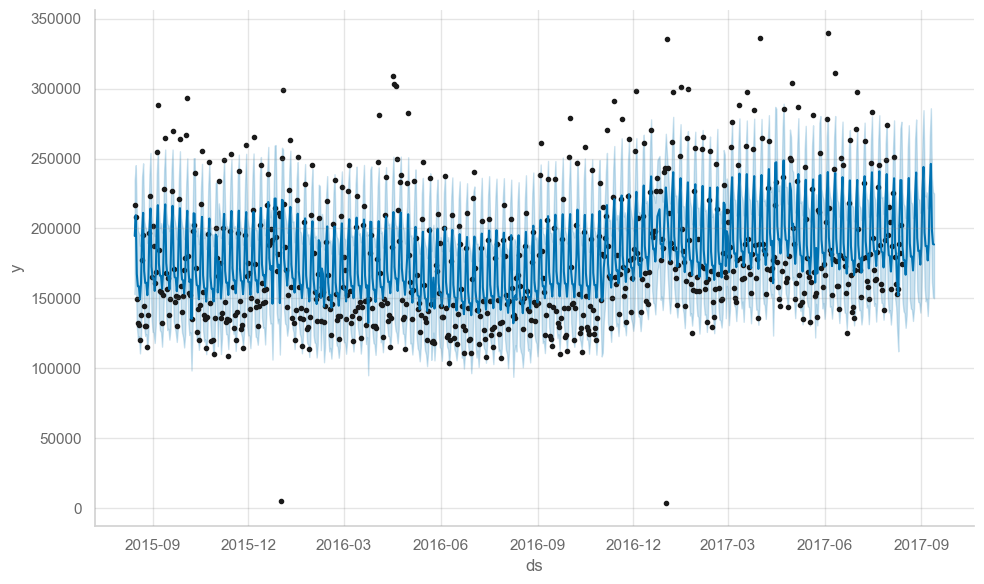

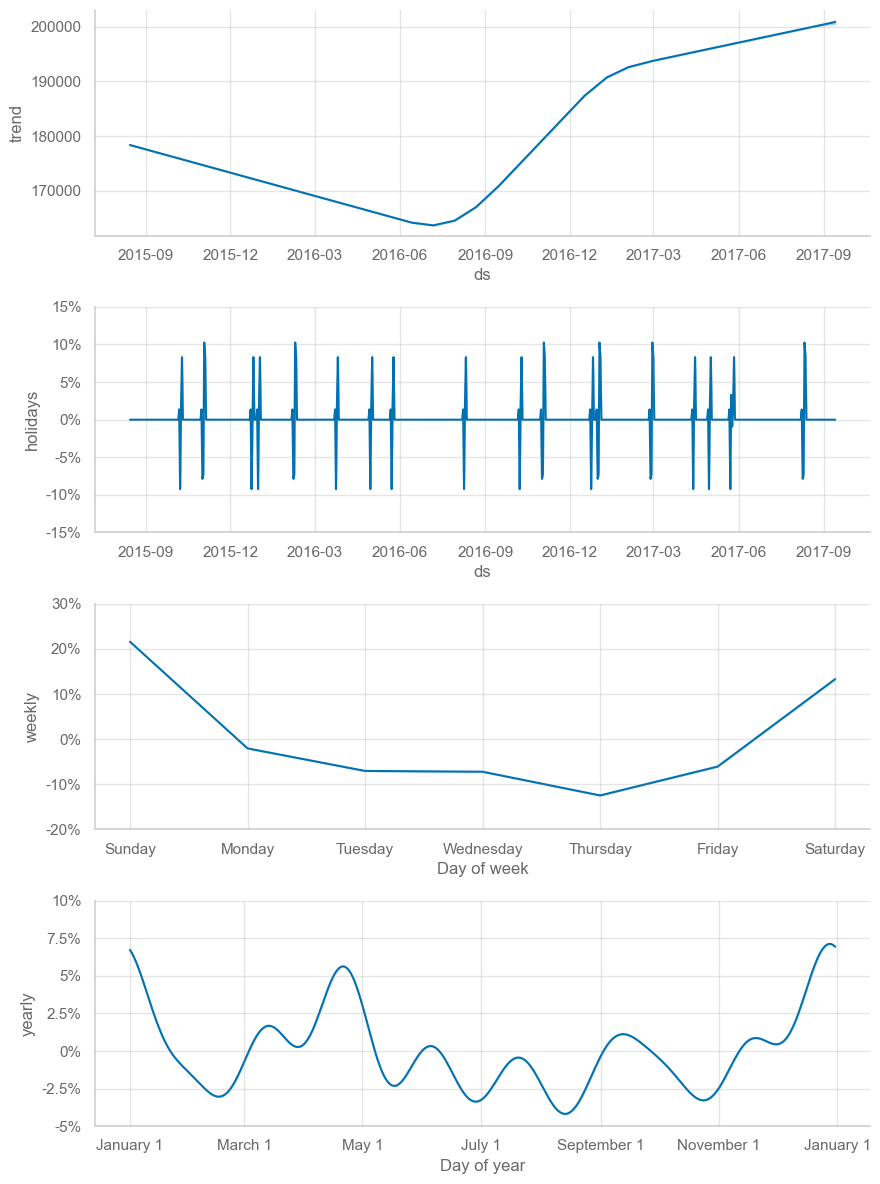

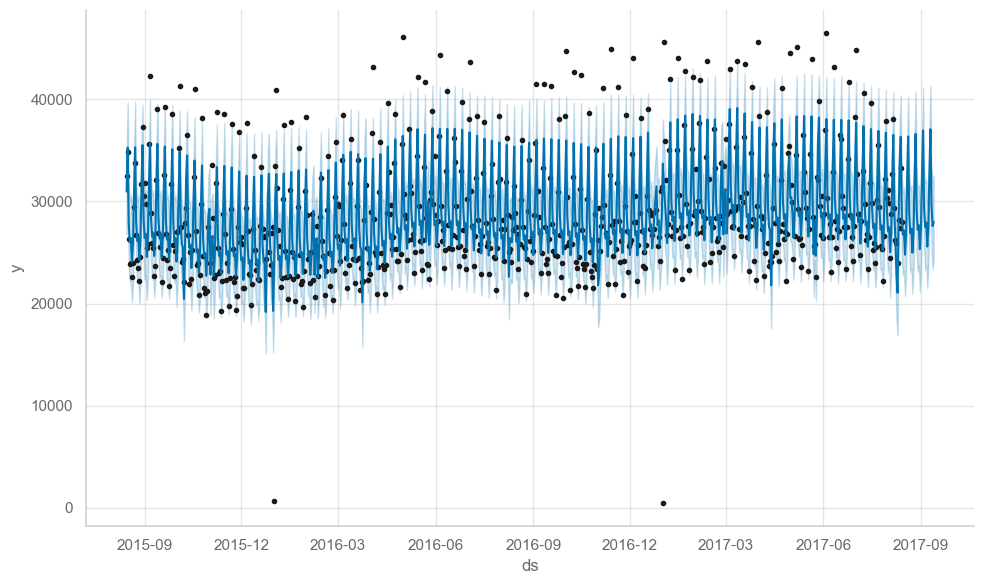

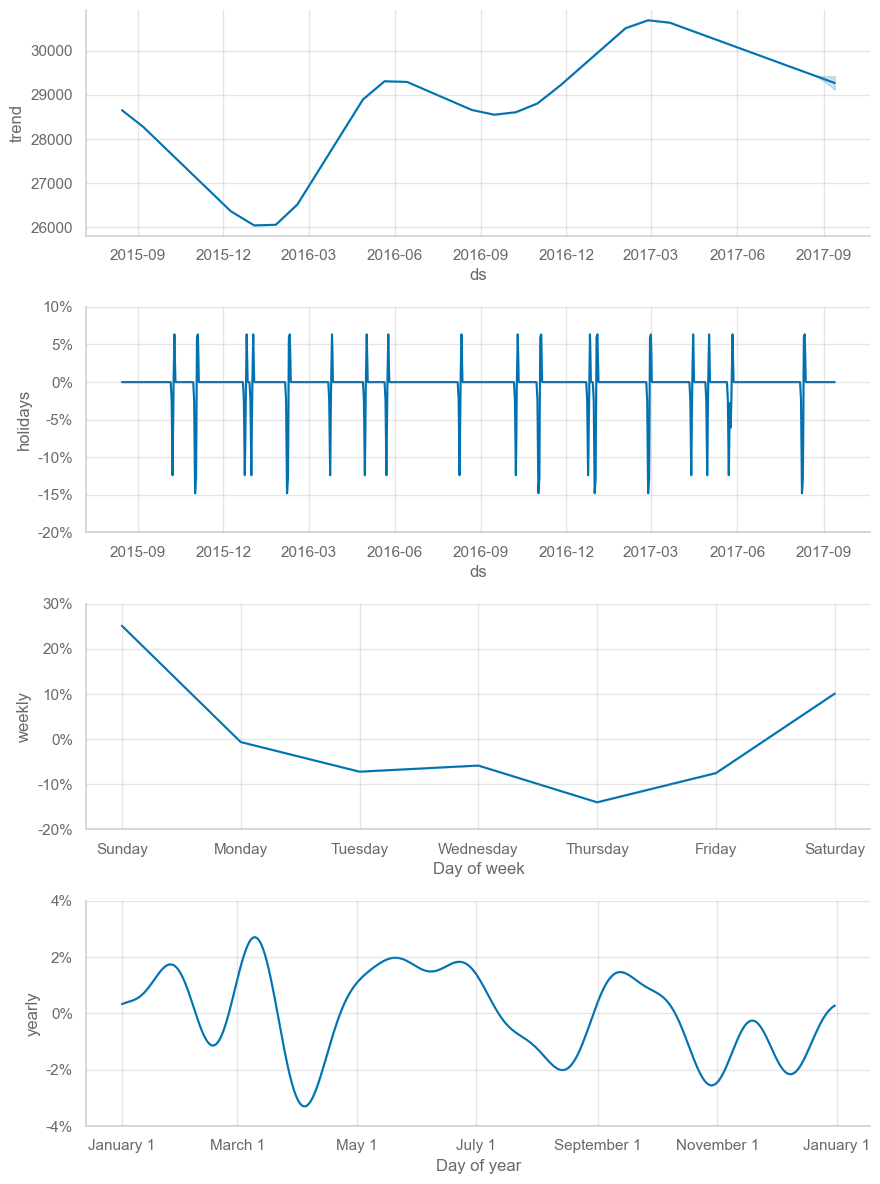

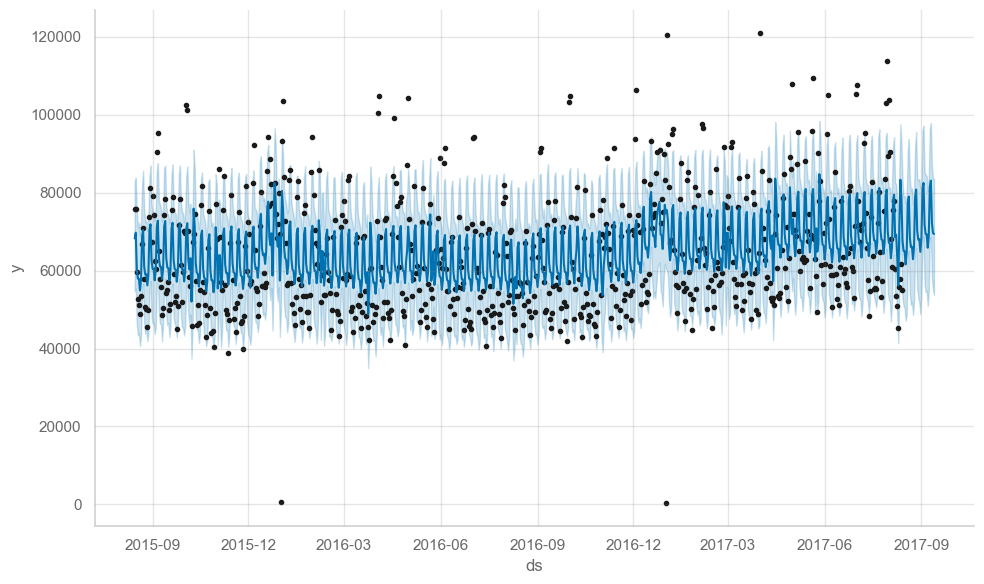

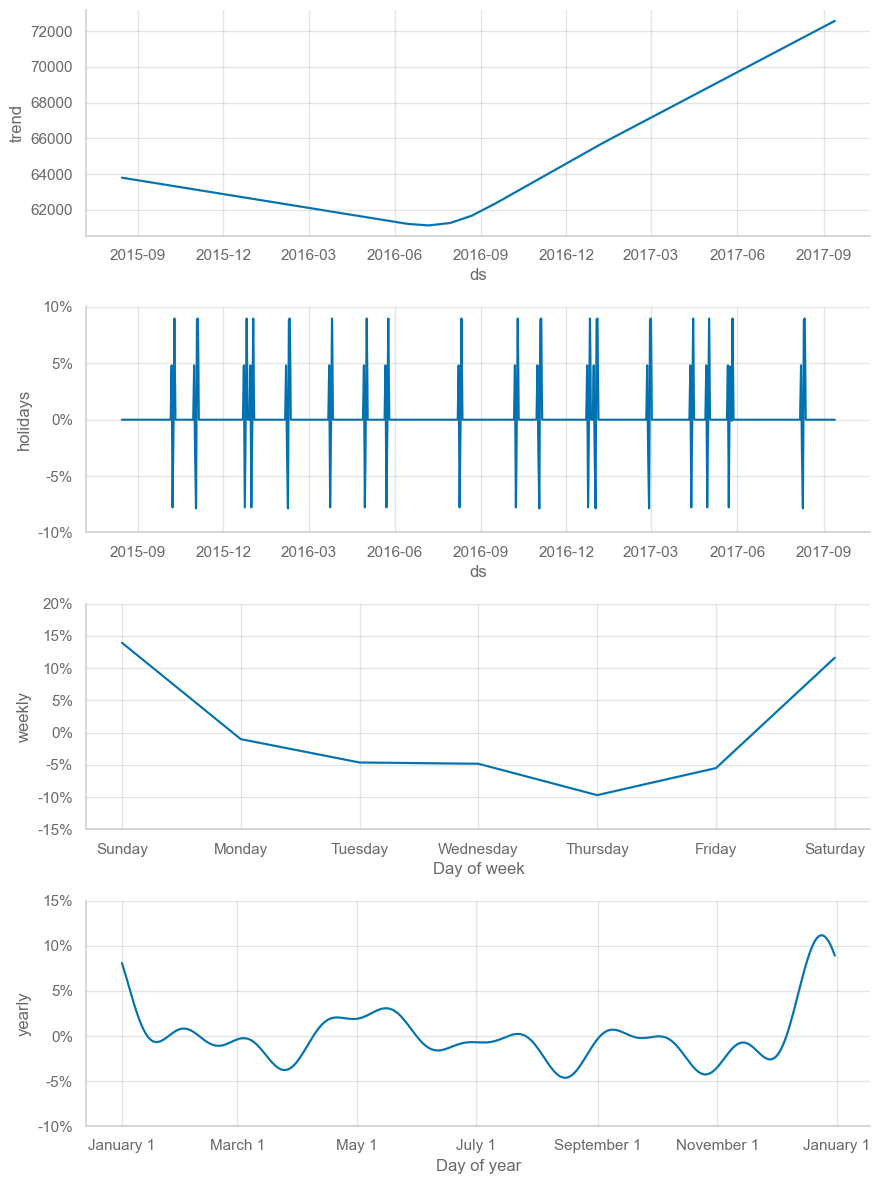

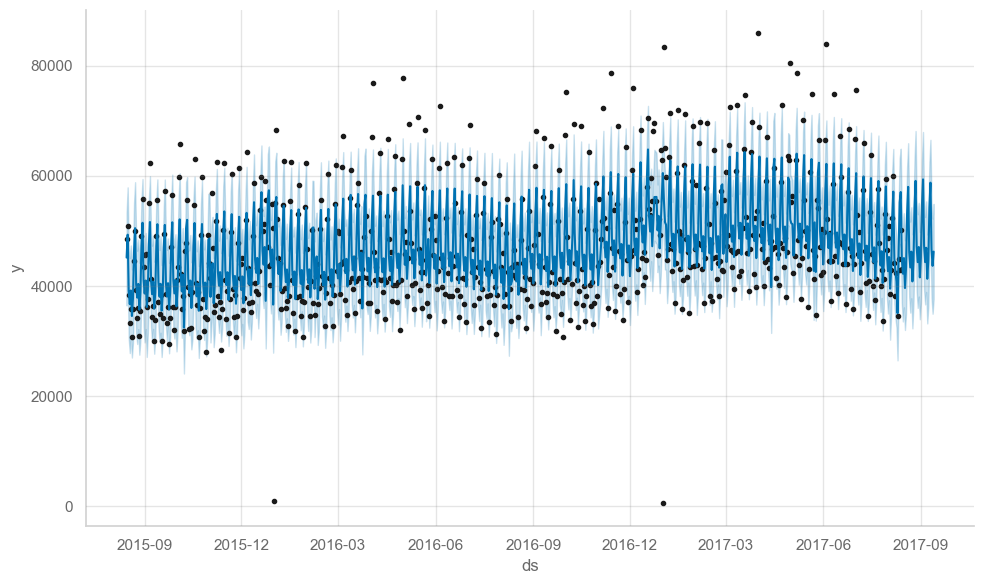

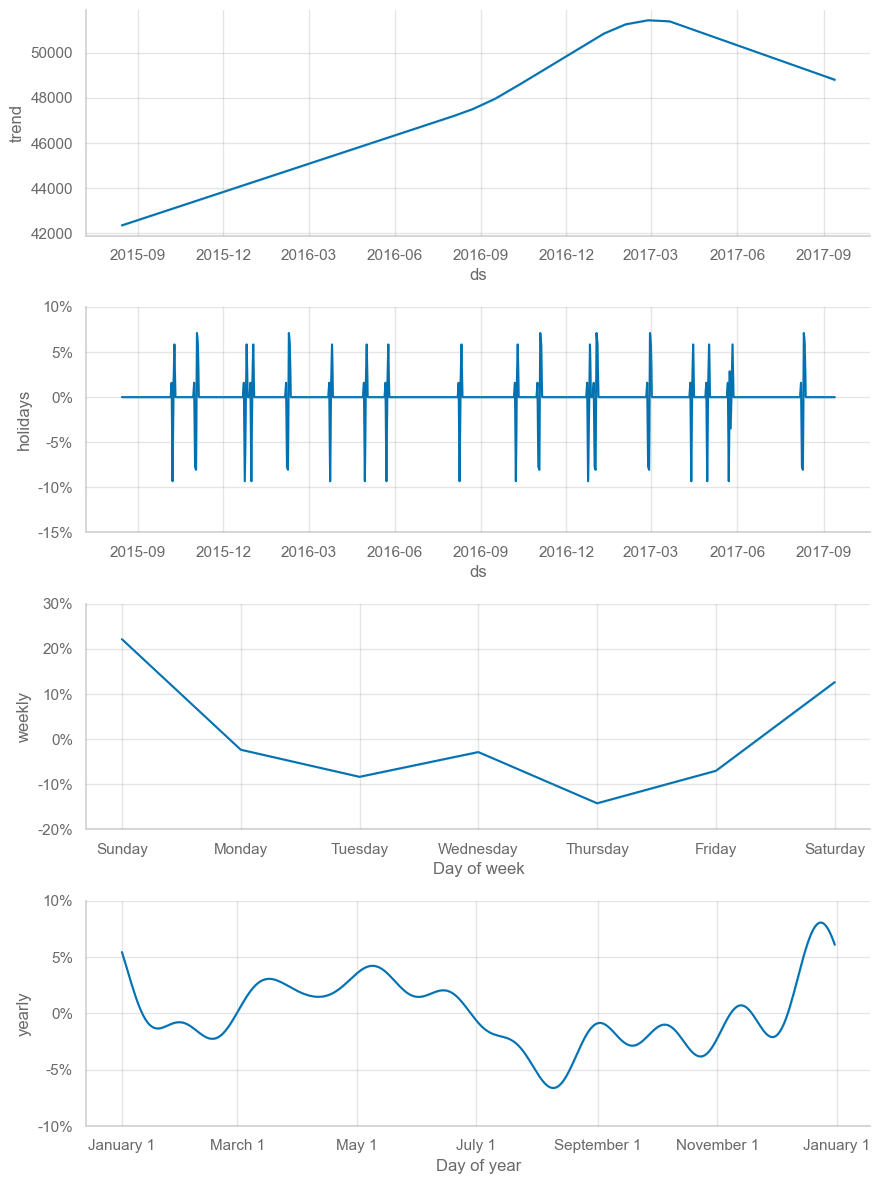

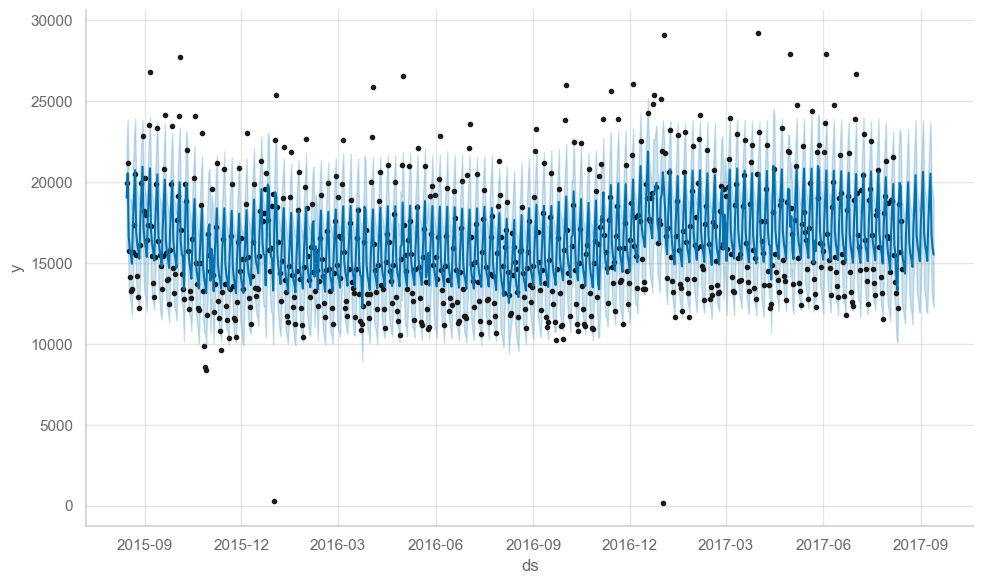

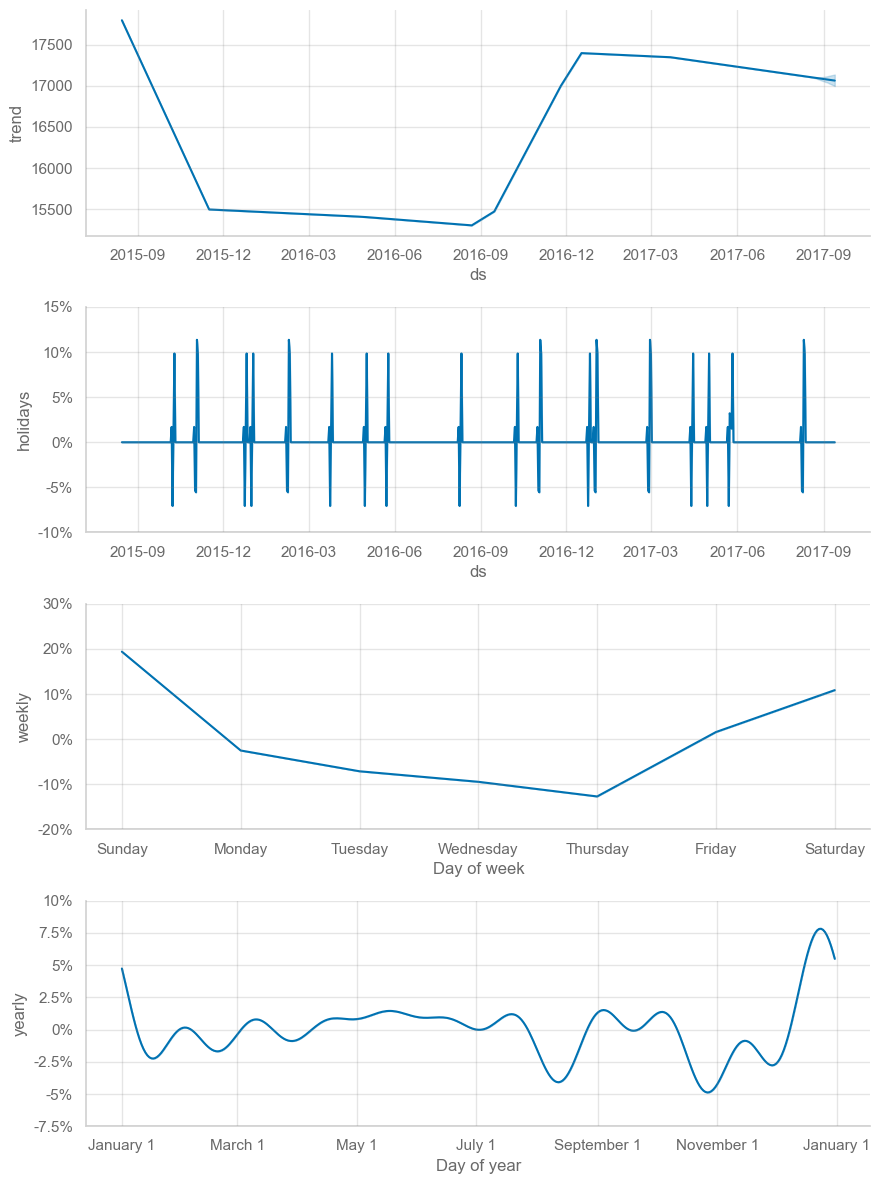

In [38]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [39]:
total_sales_df.columns

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')